In [86]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [87]:
start_day_to_analyze = '2020-04-17'
end_day_to_analyze = '2020-04-18'

In [88]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [89]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [90]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [91]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [92]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2060,403,ACBI,buy,569,11.21,"{'avg': 10.9218, 'rsi': 68.82873400083025, 'ma...",2020-04-17T19:09:46.73870953Z,2020-04-17 19:09:46.830035,11.18,11.86
1,2071,403,ADVM,buy,604,12.39,"{'avg': 12.2387, 'rsi': 69.26714925831344, 'ma...",2020-04-17T19:13:36.871368655Z,2020-04-17 19:13:36.985457,12.32,12.96
2,2094,403,ADVM,sell,604,12.37,"{'avg': 12.2455, 'rsi': 78.91418827172821, 'vw...",2020-04-17T19:20:23.353236148Z,2020-04-17 19:20:23.847890,12.32,12.96
3,2095,403,AIMT,buy,804,16.10,"{'avg': 15.8826, 'rsi': 66.32740256022281, 'ma...",2020-04-17T19:20:29.243266053Z,2020-04-17 19:20:29.913251,16.04,16.52
4,2155,403,AIMT,sell,804,16.08,"{'avg': 15.9087, 'rsi': 43.64879511888685, 'vw...",2020-04-17T19:43:26.504088293Z,2020-04-17 19:43:26.693394,16.04,16.52
...,...,...,...,...,...,...,...,...,...,...,...
342,2147,403,XENT,sell,1072,9.92,"{'avg': 9.8609, 'rsi': 78.82757424313968, 'vwa...",2020-04-17T19:33:35.386880476Z,2020-04-17 19:33:35.869499,9.86,10.22
343,1840,401,XNET,buy,551,3.54,"{'avg': 3.4669, 'rsi': 65.27936007269729, 'mac...",2020-04-17T13:57:14.750045339Z,2020-04-17 13:57:14.857085,3.36,4.08
344,1890,401,XNET,sell,551,3.62,"{'avg': 3.4991, 'rsi': 76.15592744148334, 'vwa...",2020-04-17T14:08:12.372958753Z,2020-04-17 14:08:12.648687,3.36,4.08
345,1891,401,XNET,buy,365,3.63,"{'avg': 3.5011, 'rsi': 76.7298450666956, 'macd...",2020-04-17T14:08:36.157239147Z,2020-04-17 14:08:36.436013,3.36,4.44


In [93]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [94]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [95]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
13,401,momentum_long,PAPER,v0.1-300-g62d6983,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-17 13:49:43.286899,NaT,None


,symbol,count,revenue
70,RM,2,-131.30
68,STXS,2,-122.36
54,NESR,2,-116.74
5,AM,4,-103.12
34,TGI,2,-96.57
27,TPC,3,-96.56
59,TV,2,-92.04
64,TRGP,2,-90.74
28,RAD,3,-90.64
76,GCO,2,-86.14


TOTAL REVENUE: -2203.82 $


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
15,403,momentum_long,PAPER,v0.1-300-g62d6983,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 360}",2020-04-17 18:49:07.490990,2020-04-17 20:10:00.713500,market close


,symbol,count,revenue
48,COWN,1,-17859.19
41,ORI,1,-13827.44
35,HCKT,1,-12520.28
51,HRTG,1,-11996.58
50,NCR,1,-10882.88
47,HBNC,1,-10647.96
20,PFS,2,-9170.59
43,IMO,1,-8534.72
37,LOB,1,-8191.70
36,RDFN,1,-7606.20


TOTAL REVENUE: -193709.23 $


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
12,400,momentum_long,PAPER,v0.1-300-g62d6983,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-17 13:45:44.881897,NaT,None


,symbol,count,revenue
2,ERX,1,-2749.40
1,CNQ,1,-1912.16
0,VET,1,-1100.80


TOTAL REVENUE: -5762.36 $


In [81]:

minute_history = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df

In [103]:
minute_history['FLXN'][:2534]

,open,high,low,close,volume
timestamp,,,,,
2020-04-07 08:00:00-04:00,7.76,7.76,7.7600,7.76,2000
2020-04-07 08:06:00-04:00,7.79,7.79,7.7900,7.79,100
2020-04-07 08:27:00-04:00,7.75,7.75,7.7500,7.75,49335
2020-04-07 08:29:00-04:00,7.76,7.76,7.7600,7.76,1000
2020-04-07 08:39:00-04:00,8.00,8.00,8.0000,8.00,200
...,...,...,...,...,...
2020-04-17 09:53:00-04:00,8.14,8.16,8.1200,8.13,4890
2020-04-17 09:54:00-04:00,8.15,8.15,8.1200,8.12,6474
2020-04-17 09:55:00-04:00,8.16,8.24,8.1450,8.23,12582


In [84]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-17 10:02:55.568180
now=2020-04-17 10:03:28.695936
now=2020-04-17 10:03:46.233577
now=2020-04-17 10:03:46.568714
now=2020-04-17 10:03:55.290537
now=2020-04-17 10:04:02.032822
now=2020-04-17 10:04:55.987450
OMF analysis for run 401 with profit -45.82


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1821.60,-1821.60,buy,2020-04-17 14:02:55.568180,20.70,"[19.0, 19.67]",[21.26],88,"{'avg': 19.9153, 'rsi': 78.69671331175765, 'macd': [0.35458482030014693, 0.3539357570772559, 0.3637527501980422, 0.369691958481301, 0.3813002617404777], 'vwap': 20.71, 'sell_macd': [0.20244657700041202, 0.2019407924916301, 0.20827471634853012, 0.21206381654418394, 0.21953501388438212], 'slow macd': [0.3200845306034843, 0.32543661613120634, 0.33271906408592855, 0.33936681957871784, 0.3471793018300602], 'macd_signal': [0.3719746648836857, 0.36836688332239975, 0.3674440566975282, 0.3678936370542828, 0.3705749619915218], 'resistances': [21.26], 'sell_macd_signal': [0.2154267383541592, 0.21272954918165338, 0.21183858261502872, 0.21188362940085975, 0.21341390629756424]}",24.07,19.59
1,-1.76,1819.84,sell,2020-04-17 14:03:23.014551,20.68,None,None,88,"{'avg': 19.9429, 'rsi': 78.1383135972299, 'vwap': 20.7, 'reasons': 'rsi max', 'movement': -0.00048285852245299674, 'sell_macd': [0.2019407924916301, 0.20827471634853012, 0.21206381654418394, 0.21953501388438212, 0.221986141501624], 'sell_macd_signal': [0.21272954918165338, 0.21183858261502872, 0.21188362940085975, 0.21341390629756424, 0.21512835333837618]}",24.07,19.59
2,-1822.48,-1820.72,buy,2020-04-17 14:03:28.695936,20.69,"[19.0, 19.67]",[20.69],88,"{'avg': 19.9509, 'rsi': 78.69671331175763, 'macd': [0.3539357570772559, 0.3637527501980422, 0.369691958481301, 0.3813002617404777, 0.3860497841031929], 'vwap': 20.7001, 'sell_macd': [0.2019407924916301, 0.20827471634853012, 0.21206381654418394, 0.21953501388438212, 0.22250562202109947], 'slow macd': [0.32543661613120634, 0.33271906408592855, 0.33936681957871784, 0.3471793018300602, 0.35381177062374647], 'macd_signal': [0.36836688332239975, 0.3674440566975282, 0.3678936370542828, 0.3705749619915218, 0.373669926413856], 'resistances': [21.26], 'sell_macd_signal': [0.21272954918165338, 0.21183858261502872, 0.21188362940085975, 0.21341390629756424, 0.2152322494422713]}",24.07,19.59
3,0.00,1822.48,sell,2020-04-17 14:03:39.726224,20.71,None,None,88,"{'avg': 19.9823, 'rsi': 78.84787272750208, 'vwap': 20.6955, 'reasons': 'rsi max', 'movement': 0.0004828585224528252, 'sell_macd': [0.2019407924916301, 0.20827471634853012, 0.21206381654418394, 0.21953501388438212, 0.22302510254058205], 'sell_macd_signal': [0.21272954918165338, 0.21183858261502872, 0.21188362940085975, 0.21341390629756424, 0.2153361455461678]}",24.07,19.59
4,-1451.80,-1451.80,buy,2020-04-17 14:03:46.233577,20.74,"[19.0, 19.67]",[21.26],70,"{'avg': 19.9908, 'rsi': 79.28874845646445, 'macd': [0.3539357570772559, 0.3637527501980422, 0.369691958481301, 0.3813002617404777, 0.3892406672940716], 'vwap': 20.7121, 'sell_macd': [0.2019407924916301, 0.20827471634853012, 0.21206381654418394, 0.21953501388438212, 0.22458354409902626], 'slow macd': [0.32543661613120634, 0.33271906408592855, 0.33936681957871784, 0.3471793018300602, 0.35445151472610803], 'macd_signal': [0.36836688332239975, 0.3674440566975282, 0.3678936370542828, 0.3705749619915218, 0.37430810305203177], 'resistances': [21.26], 'sell_macd_signal': [0.21272954918165338, 0.21183858261502872, 0.21188362940085975, 0.21341390629756424, 0.21564783385785663]}",24.23,19.59
5,-1762.90,-311.10,buy,2020-04-17 14:03:46.568714,20.74,"[19.0, 19.67]",[21.26],15,"{'avg': 19.9908, 'rsi': 79.28874845646445, 'macd': [0.3539357570772559, 0.3637527501980422, 0.369691958481301, 0.3813002617404777, 0.3892406672940716], 'vwap': 20.7121, 'sell_macd': [0.2019407924916301, 0.20827471634853012, 0.21206381654418394, 0.21953501388438212, 0.22458354409902626], 'slow macd': [0.32543661613120634, 0.33271906408592855, 0.33936681957871784, 0.3471793018300602, 0.35445151472610803], 'macd_signal': [0.36836688332239975, 0.3674440566975282, 0.3678936370542828, 0.3705749619915218, 0.37430810305203177], 'resistances': [21.26], 'sell_macd_signal': [0.21272954918165338, 0.21183858261502872, 0.2118836294

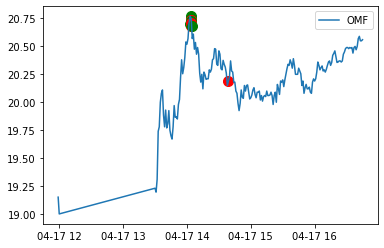

now=2020-04-17 09:53:27.251813
now=2020-04-17 09:53:27.486554
now=2020-04-17 09:53:27.555301
now=2020-04-17 09:53:28.013132
now=2020-04-17 09:53:28.104009
now=2020-04-17 10:28:15.263373
SDC analysis for run 401 with profit -53.35


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1455.15,-1455.15,buy,2020-04-17 13:53:27.251813,4.45,"[4.26, 4.28]",[4.5],327,"{'avg': 4.3541, 'rsi': 72.58053304000707, 'macd': [0.03194396359349483, 0.0315222760242051, 0.030633235609243137, 0.03856195624584835, 0.045132185163463845], 'vwap': 4.45, 'sell_macd': [0.018906344929094487, 0.01857201333964742, 0.01794043010969304, 0.02305945057843406, 0.027268304832278822], 'slow macd': [0.019933208597917584, 0.02054792227893998, 0.02104063099182163, 0.02325956750696445, 0.02542379567622266], 'macd_signal': [0.033206596848307214, 0.032869732683486794, 0.032422433268638064, 0.03365033786408012, 0.03594670732395687], 'resistances': [4.5], 'sell_macd_signal': [0.020118162226316044, 0.019808932448982318, 0.019435231981124464, 0.020160075700586384, 0.02158172152692487]}",4.99,4.27
1,-1944.65,-489.50,buy,2020-04-17 13:53:27.486554,4.45,"[4.26, 4.28]",[4.5],110,"{'avg': 4.3541, 'rsi': 72.58053304000707, 'macd': [0.03194396359349483, 0.0315222760242051, 0.030633235609243137, 0.03856195624584835, 0.045132185163463845], 'vwap': 4.45, 'sell_macd': [0.018906344929094487, 0.01857201333964742, 0.01794043010969304, 0.02305945057843406, 0.027268304832278822], 'slow macd': [0.019933208597917584, 0.02054792227893998, 0.02104063099182163, 0.02325956750696445, 0.02542379567622266], 'macd_signal': [0.033206596848307214, 0.032869732683486794, 0.032422433268638064, 0.03365033786408012, 0.03594670732395687], 'resistances': [4.5], 'sell_macd_signal': [0.020118162226316044, 0.019808932448982318, 0.019435231981124464, 0.020160075700586384, 0.02158172152692487]}",4.99,4.27
2,-2354.05,-409.40,buy,2020-04-17 13:53:27.555301,4.45,"[4.26, 4.28]",[4.5],92,"{'avg': 4.3541, 'rsi': 72.58053304000707, 'macd': [0.03194396359349483, 0.0315222760242051, 0.030633235609243137, 0.03856195624584835, 0.045132185163463845], 'vwap': 4.45, 'sell_macd': [0.018906344929094487, 0.01857201333964742, 0.01794043010969304, 0.02305945057843406, 0.027268304832278822], 'slow macd': [0.019933208597917584, 0.02054792227893998, 0.02104063099182163, 0.02325956750696445, 0.02542379567622266], 'macd_signal': [0.033206596848307214, 0.032869732683486794, 0.032422433268638064, 0.03365033786408012, 0.03594670732395687], 'resistances': [4.5], 'sell_macd_signal': [0.020118162226316044, 0.019808932448982318, 0.019435231981124464, 0.020160075700586384, 0.02158172152692487]}",4.99,4.27
3,-2362.95,-8.90,buy,2020-04-17 13:53:28.013132,4.45,"[4.26, 4.28]",[4.5],2,"{'avg': 4.3541, 'rsi': 72.58053304000707, 'macd': [0.03194396359349483, 0.0315222760242051, 0.030633235609243137, 0.03856195624584835, 0.045132185163463845], 'vwap': 4.45, 'sell_macd': [0.018906344929094487, 0.01857201333964742, 0.01794043010969304, 0.02305945057843406, 0.027268304832278822], 'slow macd': [0.019933208597917584, 0.02054792227893998, 0.02104063099182163, 0.02325956750696445, 0.02542379567622266], 'macd_signal': [0.033206596848307214, 0.032869732683486794, 0.032422433268638064, 0.03365033786408012, 0.03594670732395687], 'resistances': [4.5], 'sell_macd_signal': [0.020118162226316044, 0.019808932448982318, 0.019435231981124464, 0.020160075700586384, 0.02158172152692487]}",4.99,4.27
4,-2447.31,-84.36,buy,2020-04-17 13:53:28.104009,4.44,"[4.26, 4.28]",[4.5],19,"{'avg': 4.3541, 'rsi': 72.58053304000707, 'macd': [0.03194396359349483, 0.0315222760242051, 0.030633235609243137, 0.03856195624584835, 0.045132185163463845], 'vwap': 4.45, 'sell_macd': [0.018906344929094487, 0.01857201333964742, 0.01794043010969304, 0.02305945057843406, 0.027268304832278822], 'slow macd': [0.019933208597917584, 0.02054792227893998, 0.02104063099182163, 0.02325956750696445, 0.02542379567622266], 'macd_signal': [0.033206596848307214, 0.032869732683486794, 0.032422433268638064, 0.03365033786408012, 0.03594670732395687], 'resistances': [4.5], 'sell_macd_signal': [0.020118162226316044, 0.019808932448982318, 0.019435231981124464, 0.020160075700586384, 0.02158172152692487]}",

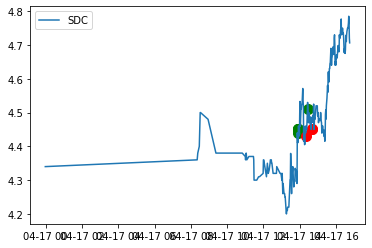

now=2020-04-17 10:45:58.855376
SGRY analysis for run 401 with profit 91.65


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2130.36,-2130.36,buy,2020-04-17 14:45:58.855376,8.66,"[7.06, 8.22, 8.3201, 8.5331]",[8.9385],246,"{'avg': 8.4132, 'rsi': 63.66613877344075, 'macd': [0.007147999692014295, 0.006128958920127658, 0.010238497245058653, 0.016548380579461508, 0.032934205065624056], 'vwap': 8.6775, 'sell_macd': [0.0008110645361778523, 0.0004512490037793526, 0.003406571329135133, 0.007753490396567031, 0.018614031353051175], 'slow macd': [0.14932226568467755, 0.14536988862896116, 0.14249907728960842, 0.14027287449032322, 0.14033221709763488], 'macd_signal': [0.0004738174724601995, 0.0016048457619936914, 0.003331576058606684, 0.0059749369627776485, 0.011366790583346931], 'resistances': [8.9385], 'sell_macd_signal': [-0.005582546282636168, -0.004375787225353063, -0.0028193155144554238, -0.0007047543322509326, 0.003159002804809489]}",9.85,8.29
1,-1040.58,1089.78,sell,2020-04-17 14:54:33.925289,8.86,None,None,123,"{'avg': 8.448, 'rsi': 65.84142555629553, 'vwap': 8.8787, 'reasons': 'scale-out', 'movement': 0.02092551622418874, 'sell_macd': [0.050018754730210446, 0.05079636317671543, 0.04882571569117822, 0.04998072134282161, 0.056356300794195846], 'sell_macd_signal': [0.027817908435612486, 0.03241359938383308, 0.035696022645302104, 0.038552962384806, 0.04211363006668397]}",9.85,8.29
2,-1013.01,27.57,sell,2020-04-17 14:55:30.787627,9.19,None,None,3,"{'avg': 8.4754, 'rsi': 74.70968531394948, 'vwap': 9.0502, 'reasons': 'scale-out', 'movement': 0.03386004514672694, 'sell_macd': [0.05079636317671543, 0.04882571569117822, 0.04998072134282161, 0.05895370339159989, 0.07816701793101544], 'sell_macd_signal': [0.03241359938383308, 0.035696022645302104, 0.038552962384806, 0.04263311058616478, 0.04973989205513491]}",9.85,8.29
3,-479.99,533.02,sell,2020-04-17 14:55:31.041482,9.19,None,None,58,"{'avg': 8.4754, 'rsi': 74.70968531394948, 'vwap': 9.0502, 'reasons': 'scale-out', 'movement': 0.03386004514672694, 'sell_macd': [0.05079636317671543, 0.04882571569117822, 0.04998072134282161, 0.05895370339159989, 0.07816701793101544], 'sell_macd_signal': [0.03241359938383308, 0.035696022645302104, 0.038552962384806, 0.04263311058616478, 0.04973989205513491]}",9.85,8.29
4,91.65,571.64,sell,2020-04-17 14:55:51.843518,9.22,None,None,62,"{'avg': 8.5072, 'rsi': 78.07576888563365, 'vwap': 9.312, 'reasons': 'rsi max', 'movement': 0.01913755458515284, 'sell_macd': [0.05079636317671543, 0.04882571569117822, 0.04998072134282161, 0.05895370339159989, 0.08727351143750894], 'sell_macd_signal': [0.03241359938383308, 0.035696022645302104, 0.038552962384806, 0.04263311058616478, 0.05156119075643361]}",9.85,8.29


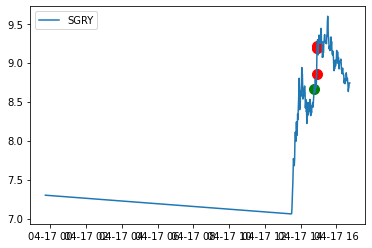

now=2020-04-17 10:00:09.965587
now=2020-04-17 10:53:47.887946
FLXN analysis for run 401 with profit -0.78


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2403.66,-2403.66,buy,2020-04-17 14:00:09.965587,8.26,"[7.535, 7.93]","[8.8, 8.82, 8.83]",291,"{'avg': 8.0492, 'rsi': 76.70494651682685, 'macd': [0.09610720935735984, 0.09380555457804718, 0.0929275566218557, 0.10194989376020303, 0.1062614126718966], 'vwap': 8.2514, 'sell_macd': [0.05629651848982764, 0.05466757679125145, 0.0539870043405255, 0.05976854523164299, 0.0624584661178158], 'slow macd': [0.06877360979004798, 0.07021081048465394, 0.07182062877987594, 0.07534598239130563, 0.07814904305917203], 'macd_signal': [0.09905078236923678, 0.09800173681099886, 0.09698690077317022, 0.09797949937057679, 0.09963588203084076], 'resistances': [8.75, 8.79, 8.8, 8.82, 8.83], 'sell_macd_signal': [0.05912582058023822, 0.05823417182244087, 0.057384738326057796, 0.057861499707174836, 0.05878089298930303]}",9.28,7.92
1,-32.01,2371.65,sell,2020-04-17 14:27:32.031020,8.15,None,None,291,"{'avg': 8.1158, 'rsi': 45.0396860459802, 'vwap': 8.15, 'reasons': 'below cost & macd negative', 'movement': -0.013317191283292909, 'sell_macd': [0.00988638892265925, 0.005872042303659342, 0.0031872002329613736, 0.0007939830319898533, -0.0013409132678834368], 'sell_macd_signal': [0.021765834697700024, 0.018587076218891888, 0.015507101021705785, 0.012564477423762599, 0.009783399285433392]}",9.28,7.92
2,-2919.05,-2887.04,buy,2020-04-17 14:53:47.887946,8.32,"[7.535, 7.93, 8.06, 8.185]","[8.8, 8.82, 8.83]",347,"{'avg': 8.1259, 'rsi': 68.73844297082469, 'macd': [0.031178400294885833, 0.0324018422453225, 0.034586569217939456, 0.036701821755254826, 0.040333978908362766], 'vwap': 8.32, 'sell_macd': [0.019715512249167233, 0.02042881713253486, 0.02175829084512415, 0.02303114970110265, 0.025282323488863057], 'slow macd': [0.04341926634456783, 0.04356191847234747, 0.04394336384305042, 0.04438396054141691, 0.04519814573165171], 'macd_signal': [0.013245284241482852, 0.017076595842250783, 0.020578590517388518, 0.02380323676496178, 0.027109385193641977], 'resistances': [8.8], 'sell_macd_signal': [0.007802876056992235, 0.01032806427210076, 0.012614109586705438, 0.01469751760958488, 0.016814478785440515]}",9.15,8.04
3,-253.08,2665.97,sell,2020-04-17 16:09:10.031355,8.41,None,None,317,"{'avg': 8.2324, 'rsi': 41.40231349000887, 'vwap': 8.42, 'reasons': 'below cost & macd negative', 'movement': -0.012895662368112478, 'sell_macd': [0.010918325501759085, 0.007683610075202907, 0.004024304417169944, 0.0011206337171802971, -0.001676001032384633], 'sell_macd_signal': [0.015792413948943273, 0.0141706531741952, 0.012141383422790149, 0.009937233481668178, 0.007614586578857616]}",9.15,8.04
4,-0.78,252.30,sell,2020-04-17 16:09:10.406126,8.41,None,None,30,"{'avg': 8.2324, 'rsi': 41.40231349000887, 'vwap': 8.42, 'reasons': 'below cost & macd negative', 'movement': -0.012895662368112478, 'sell_macd': [0.010918325501759085, 0.007683610075202907, 0.004024304417169944, 0.0011206337171802971, -0.001676001032384633], 'sell_macd_signal': [0.015792413948943273, 0.0141706531741952, 0.012141383422790149, 0.009937233481668178, 0.007614586578857616]}",9.15,8.04


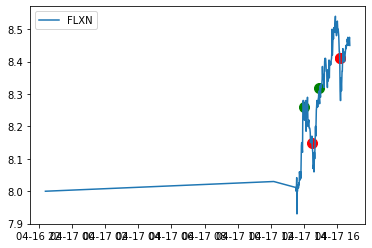

now=2020-04-17 10:00:39.401626
now=2020-04-17 10:48:18.748079
FRTA analysis for run 401 with profit -20.83


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1986.87,-1986.87,buy,2020-04-17 14:00:39.401626,6.43,"[5.7, 5.95, 6.17]","[6.86, 6.9301]",309,"{'avg': 6.2203, 'rsi': 69.88196727311644, 'macd': [0.10873731381292817, 0.1056580188395495, 0.10602998979955647, 0.11189372784742968, 0.1219933091915193], 'vwap': 6.4043, 'sell_macd': [0.06611565032564926, 0.06379830319862467, 0.06376143136979184, 0.06732021395291188, 0.07363458721309701], 'slow macd': [0.052497894629348174, 0.05458039133507331, 0.05720874133688625, 0.060894866242453105, 0.0655482824530651], 'macd_signal': [0.10547374026207348, 0.10551059597756869, 0.10561447474196625, 0.10687032536305893, 0.109894922128751], 'resistances': [6.86, 6.9301], 'sell_macd_signal': [0.06551115117790748, 0.06516858158205092, 0.0648871515395991, 0.06537376402226167, 0.06702592866042874]}",7.39,6.11
1,-71.07,1915.80,sell,2020-04-17 14:30:01.917970,6.20,None,None,309,"{'avg': 6.2473, 'rsi': 48.17670679280741, 'vwap': 6.23, 'reasons': 'below cost & macd negative', 'movement': -0.03110419906687392, 'sell_macd': [0.003369666473449051, 0.0031317223068798583, 0.0023861590302436397, 0.00099499077532883, -0.0003616986541539191], 'sell_macd_signal': [0.015083403787157779, 0.012693067491102194, 0.010631685798930483, 0.008704346794210152, 0.0068911377045373385]}",7.39,6.11
2,-2828.54,-2757.47,buy,2020-04-17 14:48:18.748079,6.31,"[5.7, 5.95, 6.14, 6.17, 6.18, 6.28]","[6.4, 6.46]",437,"{'avg': 6.2429, 'rsi': 61.98378021706493, 'macd': [-0.0018708841026651157, 0.002817518753442272, 0.007655241575139193, 0.011358241032877636, 0.015725454385432158], 'vwap': 6.2929, 'sell_macd': [-0.0025512322295009326, 0.0006452878670417661, 0.003906923164775478, 0.006397717901129418, 0.009294470709962255], 'slow macd': [0.04106788866110733, 0.040867954681647056, 0.04085855048114073, 0.040784550774107586, 0.04097111153820965], 'macd_signal': [-0.007622966788547727, -0.005534869680149728, -0.0028968474290919435, -4.58297366980275e-05, 0.0031084270877280097], 'resistances': [6.4, 6.4, 6.415], 'sell_macd_signal': [-0.007254019744208596, -0.005674158221958524, -0.003757941944611724, -0.0017268099754634953, 0.0004774461616216547]}",6.97,6.09
3,-1424.62,1403.92,sell,2020-04-17 14:54:54.004839,6.44,None,None,218,"{'avg': 6.2544, 'rsi': 71.34378237547426, 'vwap': 6.44, 'reasons': 'scale-out', 'movement': 0.02060221870047556, 'sell_macd': [0.011512255428113072, 0.016401370452160613, 0.02118248124424671, 0.02307448340373952, 0.027885465821477773], 'sell_macd_signal': [0.003879366011998657, 0.006383766900031048, 0.00934350976887418, 0.012089704495847248, 0.015248856760973354]}",6.97,6.09
4,-20.83,1403.79,sell,2020-04-17 16:26:23.890332,6.41,None,None,219,"{'avg': 6.3345, 'rsi': 38.187082191214344, 'vwap': 6.4553, 'reasons': 'below cost & macd negative', 'movement': -0.019011406844106463, 'sell_macd': [0.01109567085558627, 0.010273974960683496, 0.008461303159970512, 0.0038220614560389166, -0.00036204976073861417], 'sell_macd_signal': [0.010520053569406907, 0.010470837847662225, 0.010068930910123883, 0.00881955701930689, 0.006983235663297789]}",6.97,6.09


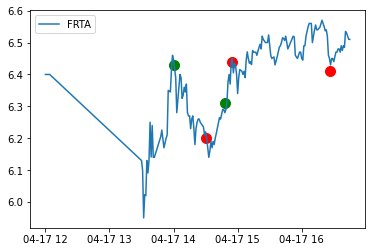

now=2020-04-17 10:06:05.420451
now=2020-04-17 10:50:28.843653
AM analysis for run 401 with profit -103.12


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1821.66,-1821.66,buy,2020-04-17 14:06:05.420451,3.13,"[2.92, 2.98]",[3.3],582,"{'avg': 3.0148, 'rsi': 69.33391415585018, 'macd': [0.028944706035052725, 0.03048229270661862, 0.03133957807372445, 0.03404725660266772, 0.03657837503300598], 'vwap': 3.1205, 'sell_macd': [0.016935458961468086, 0.01790956564813051, 0.018436018057891967, 0.02016525346734399, 0.021770303741367236], 'slow macd': [0.02241383452065726, 0.023248051621356236, 0.02397837602848263, 0.025091755859223852, 0.026235906185932745], 'macd_signal': [0.02708479138814815, 0.027764291651842243, 0.028479348936218684, 0.02959293046950849, 0.030990019382207988], 'resistances': [3.26, 3.26, 3.26, 3.3], 'sell_macd_signal': [0.015844438147656216, 0.016257463647751075, 0.016693174529779253, 0.0173875903172922, 0.01826413300210721]}",3.64,2.96
1,-46.56,1775.10,sell,2020-04-17 14:32:14.317614,3.05,None,None,582,"{'avg': 3.0368, 'rsi': 41.52681043776531, 'vwap': 3.055, 'reasons': 'below cost & macd negative', 'movement': -0.02396166134185295, 'sell_macd': [0.004293150436045057, 0.0034914305913780197, 0.0020421497956455426, 0.00010709787954699124, -0.0014021256639003], 'sell_macd_signal': [0.0051967405735658685, 0.004855678577128299, 0.004292972820831747, 0.003455797832574796, 0.002484213133279777]}",3.64,2.96
2,-2591.76,-2545.20,buy,2020-04-17 14:50:28.843653,3.15,"[2.92, 2.98, 3.05, 3.06]",[3.3],808,"{'avg': 3.0534, 'rsi': 71.28817835434272, 'macd': [0.009001142876482682, 0.008770624674537597, 0.008490069106922071, 0.011364390880364006, 0.015010490379437691], 'vwap': 3.1591, 'sell_macd': [0.005471609777372599, 0.005315749823610716, 0.005125264796996376, 0.006988195103569517, 0.009341281120333278], 'slow macd': [0.016020993493893076, 0.0158616824987301, 0.015689742742686974, 0.016146203218645905, 0.01684581567058796], 'macd_signal': [0.003591289230654303, 0.004627156319430962, 0.005399738876929184, 0.006592669277616149, 0.008276233497980456], 'resistances': [3.22, 3.26, 3.26, 3.26, 3.26, 3.26, 3.3], 'sell_macd_signal': [0.0017876815646208628, 0.0024932952164188333, 0.003019689132534342, 0.003813390326741377, 0.004918968485459757]}",3.52,3.04
3,-103.12,2488.64,sell,2020-04-17 15:03:09.920130,3.08,None,None,808,"{'avg': 3.0619, 'rsi': 43.88762053953718, 'vwap': 3.0871, 'reasons': 'below cost & macd negative', 'movement': -0.02187331835016307, 'sell_macd': [0.005077069932120093, 0.0037731499644459987, 0.0022925220680187763, 0.0007453766673219953, -0.0002101311340951817], 'sell_macd_signal': [0.006891675486695238, 0.00626797038224539, 0.005472880719400068, 0.0045273799089844535, 0.0035798777003685266]}",3.52,3.04


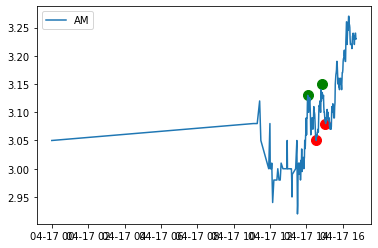

now=2020-04-17 10:42:51.949591
now=2020-04-17 10:42:52.475996
NRZ analysis for run 401 with profit 131.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1336.20,-1336.20,buy,2020-04-17 14:42:51.949591,5.10,"[4.9, 5.0186, 5.0199, 5.085]",[5.21],262,"{'avg': 5.06, 'rsi': 63.67041313502103, 'macd': [-0.00678934760423644, -0.005586837930500188, -0.0025867310587068815, 0.000989839636386769, 0.005376157535546433], 'vwap': 5.1057, 'sell_macd': [-0.004700213196373149, -0.0038460124019801256, -0.0018317518816477474, 0.0005408115352558696, 0.0034214997622559196], 'slow macd': [0.025532671998444556, 0.024822039074596347, 0.02452837473470293, 0.024458868479191764, 0.024675674009841053], 'macd_signal': [-0.006969008516801824, -0.006692574399541497, -0.005871405731374573, -0.004499156657822305, -0.0025240938191485574], 'resistances': [5.21], 'sell_macd_signal': [-0.005267046507962623, -0.004982839686766124, -0.004352622125742449, -0.003373935393542785, -0.0020148483623830442]}",5.44,5.0
1,-4467.60,-3131.40,buy,2020-04-17 14:42:52.475996,5.10,"[4.9, 5.0186, 5.0199, 5.085]",[5.21],614,"{'avg': 5.06, 'rsi': 63.67041313502103, 'macd': [-0.00678934760423644, -0.005586837930500188, -0.0025867310587068815, 0.000989839636386769, 0.005376157535546433], 'vwap': 5.1057, 'sell_macd': [-0.004700213196373149, -0.0038460124019801256, -0.0018317518816477474, 0.0005408115352558696, 0.0034214997622559196], 'slow macd': [0.025532671998444556, 0.024822039074596347, 0.02452837473470293, 0.024458868479191764, 0.024675674009841053], 'macd_signal': [-0.006969008516801824, -0.006692574399541497, -0.005871405731374573, -0.004499156657822305, -0.0025240938191485574], 'resistances': [5.21], 'sell_macd_signal': [-0.005267046507962623, -0.004982839686766124, -0.004352622125742449, -0.003373935393542785, -0.0020148483623830442]}",5.44,5.0
2,-2181.24,2286.36,sell,2020-04-17 15:21:17.585920,5.22,None,None,438,"{'avg': 5.075, 'rsi': 67.89114661564469, 'vwap': 5.21, 'reasons': 'scale-out', 'movement': 0.021526418786692647, 'sell_macd': [0.010351241827998514, 0.009546717524867354, 0.009580247710415435, 0.00947676152109711, 0.010312009146029588], 'sell_macd_signal': [0.01219275141480148, 0.011663544636814654, 0.01124688525153481, 0.01089286050544727, 0.010776690233563733]}",5.44,5.0
3,131.40,2312.64,sell,2020-04-17 15:23:12.694926,5.28,None,None,438,"{'avg': 5.0795, 'rsi': 78.53413228591572, 'vwap': 5.2812, 'reasons': 'rsi max', 'movement': 0.012452107279693562, 'sell_macd': [0.009580247710415435, 0.00947676152109711, 0.0110912299252508, 0.014542877643743957, 0.017303344987456448], 'sell_macd_signal': [0.01124688525153481, 0.01089286050544727, 0.010932534389407975, 0.011654603040275172, 0.012784351429711427]}",5.44,5.0


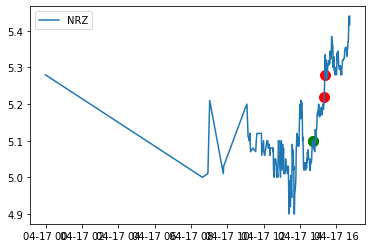

now=2020-04-17 10:04:49.345254
now=2020-04-17 10:40:55.746237
NOV analysis for run 401 with profit -55.61


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4140.00,-4140.00,buy,2020-04-17 14:04:49.345254,11.50,"[10.85, 10.995, 11.0001, 11.25]",[11.5],360,"{'avg': 11.1502, 'rsi': 67.71677403498373, 'macd': [0.08918316184954911, 0.08844734626079465, 0.09324467198173281, 0.09354748077184993, 0.09790384115417261], 'vwap': 11.505, 'sell_macd': [0.05190150334466104, 0.05133974046180079, 0.05439109743019799, 0.054503958737647906, 0.05726068237023796], 'slow macd': [0.07726183036782075, 0.07851575152997192, 0.08082331234084172, 0.08233726842898648, 0.0846380536689324], 'macd_signal': [0.08975837131047018, 0.08949616630053507, 0.09024586743677462, 0.09090619010378968, 0.09230572031386627], 'resistances': [12.06, 12.075, 12.11, 12.13], 'sell_macd_signal': [0.05280452538098538, 0.05251156839714846, 0.05288747420375837, 0.05321077111053628, 0.054020753362476616]}",12.33,11.23
1,-50.40,4089.60,sell,2020-04-17 14:34:09.874830,11.36,None,None,360,"{'avg': 11.2589, 'rsi': 45.24314685709552, 'vwap': 11.3806, 'reasons': 'below cost & macd negative', 'movement': -0.01086484137331595, 'sell_macd': [0.011524014970827778, 0.010719663548522718, 0.006317316160382447, 0.0022853920116947535, -0.00036656696145875856], 'sell_macd_signal': [0.011166392590341672, 0.011077046781977882, 0.010125100657658795, 0.008557158928465987, 0.006772413750481038]}",12.33,11.23
2,-6047.11,-5996.71,buy,2020-04-17 14:40:55.746237,11.51,"[10.85, 10.995, 11.0001, 11.25, 11.34, 11.34]","[12.06, 12.11, 12.13]",521,"{'avg': 11.2648, 'rsi': 61.75495234172491, 'macd': [-0.006174648562096152, -0.00686706929512404, -0.006134725774900929, -0.0003058557715949206, 0.007854151846625967], 'vwap': 11.51, 'sell_macd': [-0.006877261253608324, -0.007107451880616011, -0.006415295851263991, -0.0024160145835718794, 0.003069347632600028], 'slow macd': [0.05720322429380964, 0.055420164253698445, 0.05393095921199098, 0.05351417207172027, 0.05376483824603007], 'macd_signal': [0.009250064957108346, 0.006026638106661869, 0.0035943653303493095, 0.0028143211099604633, 0.0038222872572935642], 'resistances': [12.06, 12.13], 'sell_macd_signal': [0.0024041359210975667, 0.0005018183607548511, -0.0008816044816489174, -0.0011884865020335097, -0.00033691967510680225]}",12.06,11.33
3,-55.61,5991.50,sell,2020-04-17 15:48:29.996919,11.50,None,None,521,"{'avg': 11.3328, 'rsi': 36.514535179758006, 'vwap': 11.5068, 'reasons': 'below cost & macd negative', 'movement': -0.0004344048653344053, 'sell_macd': [-0.001514819010916213, -0.0028697420089400794, -0.004147997046246132, -0.0048304295812098275, -0.00685790389960772], 'sell_macd_signal': [0.002694919799803982, 0.0015819874380551698, 0.00043599054119490923, -0.000617293483286038, -0.0018654155665503746]}",12.06,11.33


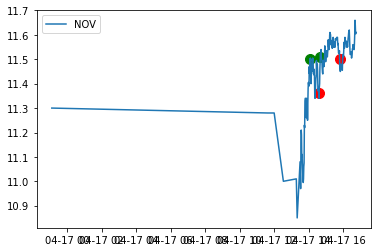

now=2020-04-17 09:53:38.474469
now=2020-04-17 10:03:22.593126
OIS analysis for run 401 with profit 22.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3339.40,-3339.40,buy,2020-04-17 13:53:38.474469,2.36,"[2.22, 2.23, 2.25, 2.3, 2.3, 2.32]","[2.46, 2.46]",1415,"{'avg': 2.3301, 'rsi': 59.96800811213788, 'macd': [0.019067479647832286, 0.019998593713754342, 0.023292217626214917, 0.02401181222855575, 0.025099679085335058], 'vwap': 2.3567, 'sell_macd': [0.011526160169466504, 0.01208612740154047, 0.014183684629110793, 0.014594980070995245, 0.015245405349463503], 'slow macd': [0.00921126073588363, 0.00987575784021466, 0.011031097626582387, 0.011756532435828415, 0.012565088759831866], 'macd_signal': [0.017370168383962707, 0.017895853449921034, 0.018975126285179812, 0.019982463473855, 0.021005906596151012], 'resistances': [2.46, 2.46], 'sell_macd_signal': [0.010635301477168225, 0.010925466662042674, 0.011577110255456298, 0.012180684218564088, 0.01279362844474397]}",2.57,2.29
1,70.75,3410.15,sell,2020-04-17 14:02:04.646061,2.41,None,None,1415,"{'avg': 2.3398, 'rsi': 66.71223470810988, 'vwap': 2.42, 'reasons': 'bail', 'movement': 0.025423728813559344, 'sell_macd': [0.01682729081629919, 0.015840109636067634, 0.01642360339645732, 0.017703941347456897, 0.019510647006060644], 'sell_macd_signal': [0.014125175325334607, 0.014468162187481213, 0.014859250429276435, 0.015428188612912527, 0.01624468029154215]}",2.57,2.29
2,-1593.80,-1664.55,buy,2020-04-17 14:03:22.593126,2.43,"[2.22, 2.23, 2.25, 2.3, 2.3, 2.32, 2.35]","[2.46, 2.46]",685,"{'avg': 2.3427, 'rsi': 68.62768013020771, 'macd': [0.026301691070993005, 0.02728596679517059, 0.029341613396219213, 0.03221322696232587, 0.03529254554588768], 'vwap': 2.435, 'sell_macd': [0.015840109636067634, 0.01642360339645732, 0.017703941347456897, 0.019510647006060644, 0.02144430535034836], 'slow macd': [0.01471559741407047, 0.015519322540739289, 0.016553826429704266, 0.017798999617545164, 0.01915603580577052], 'macd_signal': [0.023837493195392346, 0.024527187915347994, 0.025490073011522237, 0.026834703801682964, 0.028526272150523908], 'resistances': [2.46, 2.46], 'sell_macd_signal': [0.014468162187481213, 0.014859250429276435, 0.015428188612912527, 0.01624468029154215, 0.01728460530330339]}",2.87,2.29
3,22.80,1616.60,sell,2020-04-17 14:20:06.578004,2.36,None,None,685,"{'avg': 2.3539, 'rsi': 43.13963558781667, 'vwap': 2.3625, 'reasons': 'below cost & macd negative', 'movement': -0.029774127310061696, 'sell_macd': [0.008494102894743172, 0.005802318757953007, 0.003629469836325061, 0.0014995944449740506, -0.0001795239696495976], 'sell_macd_signal': [0.014999800587564092, 0.013160304221641874, 0.011254137344578512, 0.00930322876465762, 0.007406678217796177]}",2.87,2.29


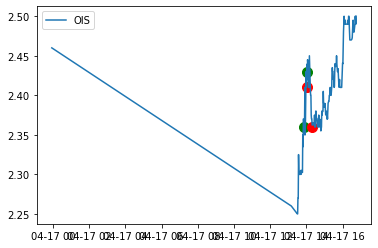

now=2020-04-17 09:57:14.857085
now=2020-04-17 10:08:36.436013
XNET analysis for run 401 with profit -3.37


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1950.54,-1950.54,buy,2020-04-17 13:57:14.857085,3.54,"[3.31, 3.34, 3.38, 3.4, 3.4099, 3.41]",[3.59],551,"{'avg': 3.4669, 'rsi': 65.27936007269729, 'macd': [0.028979357790413385, 0.030614568007506282, 0.03154683164759309, 0.03470975237247487, 0.03798885262846552], 'vwap': 3.5351, 'sell_macd': [0.01796791190214364, 0.01893524654823331, 0.019443101512091943, 0.021404506659097766, 0.023434114479373935], 'slow macd': [0.011520150543836483, 0.012613248895723572, 0.01359876121563941, 0.015043490845092933, 0.016588532394070654], 'macd_signal': [0.024512930841874336, 0.025733258275000725, 0.026895972949519197, 0.028458728834110332, 0.03036475359298137], 'resistances': [3.59], 'sell_macd_signal': [0.015412136073417534, 0.01611675816838069, 0.01678202683712294, 0.017706522801517903, 0.01885204113708911]}",4.08,3.36
1,44.08,1994.62,sell,2020-04-17 14:08:12.648687,3.62,None,None,551,"{'avg': 3.4991, 'rsi': 76.15592744148334, 'vwap': 3.625, 'reasons': 'bail', 'movement': 0.02401129943502824, 'sell_macd': [0.026870828484545584, 0.027018583819604203, 0.027302307667447234, 0.028207776799955564, 0.02932622317853406], 'sell_macd_signal': [0.025327701721907715, 0.025665878141447013, 0.025993164046647057, 0.02643608659730876, 0.02701411391355382]}",4.08,3.36
2,-1280.87,-1324.95,buy,2020-04-17 14:08:36.436013,3.63,"[3.31, 3.34, 3.38, 3.4, 3.4099, 3.41]","[3.86, 3.88, 3.89, 3.89, 3.9, 3.9, 3.9]",365,"{'avg': 3.5011, 'rsi': 76.7298450666956, 'macd': [0.044556037513785895, 0.04494274926186126, 0.04553128126662864, 0.04706894843541631, 0.049332716747880756], 'vwap': 3.6271, 'sell_macd': [0.026870828484545584, 0.027018583819604203, 0.027302307667447234, 0.028207776799955564, 0.029585963438274465], 'slow macd': [0.0253104232264727, 0.02640128992079127, 0.027522633025127252, 0.028830157995530126, 0.030306885034680153], 'macd_signal': [0.04148598941104339, 0.04217734138120696, 0.0428481293582913, 0.0436922931737163, 0.04482037788854919], 'resistances': [3.86, 3.9], 'sell_macd_signal': [0.025327701721907715, 0.025665878141447013, 0.025993164046647057, 0.02643608659730876, 0.0270660619655019]}",4.44,3.36
3,-3.37,1277.50,sell,2020-04-17 14:32:12.236703,3.50,None,None,365,"{'avg': 3.5171, 'rsi': 39.56253354553978, 'vwap': 3.5303, 'reasons': 'below cost & macd negative', 'movement': -0.02892561983471074, 'sell_macd': [0.0043442167991960545, 0.003127303416959215, 0.0021384448929175903, 0.0008206532521981558, -0.0009960759905989214], 'sell_macd_signal': [0.00936910305669789, 0.008120743128750154, 0.006924283481583642, 0.005703557435706544, 0.004363630750445451]}",4.44,3.36


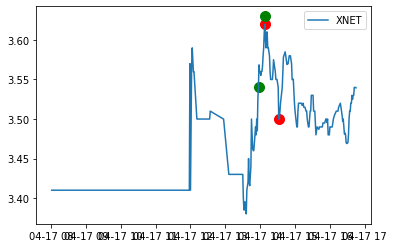

now=2020-04-17 10:09:08.383008
now=2020-04-17 10:09:08.876283
HOMB analysis for run 401 with profit -26.46


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-117.99,-117.99,buy,2020-04-17 14:09:08.383008,13.11,"[11.75, 12.495, 12.52, 12.65]",[13.36],9,"{'avg': 12.7362, 'rsi': 70.61549250079658, 'macd': [0.08107427230979347, 0.08277803109396409, 0.08875359104060543, 0.10598511417782319, 0.12386183328330347], 'vwap': 13.099, 'sell_macd': [0.04003058687017358, 0.04156160221890204, 0.0458512037605221, 0.05742944906879188, 0.06934198503538092], 'slow macd': [0.17030576420582832, 0.16957749564260816, 0.16975580194147177, 0.1723672611921394, 0.17561376206819546], 'macd_signal': [0.10382715283622002, 0.09961732848776883, 0.09744458099833615, 0.09915268763423356, 0.10409451676404755], 'resistances': [13.36, 13.5903], 'sell_macd_signal': [0.053521834143052824, 0.05112978775822267, 0.050074070958682555, 0.05154514658070442, 0.05510451427163972]}",15.12,12.44
1,-1927.17,-1809.18,buy,2020-04-17 14:09:08.876283,13.11,"[11.75, 12.495, 12.52, 12.65]",[13.36],138,"{'avg': 12.7362, 'rsi': 70.61549250079658, 'macd': [0.08107427230979347, 0.08277803109396409, 0.08875359104060543, 0.10598511417782319, 0.12386183328330347], 'vwap': 13.099, 'sell_macd': [0.04003058687017358, 0.04156160221890204, 0.0458512037605221, 0.05742944906879188, 0.06934198503538092], 'slow macd': [0.17030576420582832, 0.16957749564260816, 0.16975580194147177, 0.1723672611921394, 0.17561376206819546], 'macd_signal': [0.10382715283622002, 0.09961732848776883, 0.09744458099833615, 0.09915268763423356, 0.10409451676404755], 'resistances': [13.36, 13.5903], 'sell_macd_signal': [0.053521834143052824, 0.05112978775822267, 0.050074070958682555, 0.05154514658070442, 0.05510451427163972]}",15.12,12.44
2,-1293.60,633.57,sell,2020-04-17 14:38:09.066741,12.93,None,None,49,"{'avg': 12.8331, 'rsi': 42.365509635832815, 'vwap': 12.96, 'reasons': 'below cost & macd negative', 'movement': -0.011441647597253897, 'sell_macd': [0.024775853132124936, 0.01750814490523922, 0.010578656093311878, 0.00426244849839108, -0.00045488791970882403], 'sell_macd_signal': [0.0378426394479642, 0.0337757405394192, 0.029136323650197738, 0.024161548619836406, 0.01923826131192736]}",15.12,12.44
3,-26.46,1267.14,sell,2020-04-17 14:38:09.507932,12.93,None,None,98,"{'avg': 12.8331, 'rsi': 42.365509635832815, 'vwap': 12.96, 'reasons': 'below cost & macd negative', 'movement': -0.011441647597253897, 'sell_macd': [0.024775853132124936, 0.01750814490523922, 0.010578656093311878, 0.00426244849839108, -0.00045488791970882403], 'sell_macd_signal': [0.0378426394479642, 0.0337757405394192, 0.029136323650197738, 0.024161548619836406, 0.01923826131192736]}",15.12,12.44


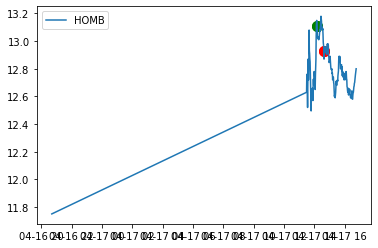

now=2020-04-17 09:53:55.309526
now=2020-04-17 10:02:55.860493
TSE analysis for run 401 with profit -15.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2380.00,-2380.00,buy,2020-04-17 13:53:55.309526,20.00,"[18.325, 18.3601, 19.46]","[20.85, 20.91, 21.01, 21.01, 21.07]",119,"{'avg': 19.4331, 'rsi': 77.76390162098686, 'macd': [0.28602734239503036, 0.28103177539501445, 0.28639158158708256, 0.29479380488186635, 0.3099830817665925], 'vwap': 20.0943, 'sell_macd': [0.17245043001353366, 0.16849408920671038, 0.17134766664026913, 0.1762082767620008, 0.18549955378202299], 'slow macd': [0.17305395004333946, 0.1782587734739387, 0.18526367696050983, 0.19290911007317035, 0.20203366231304898], 'macd_signal': [0.2778637717659623, 0.2784973724917727, 0.2800762143108347, 0.283019732425041, 0.2884124022933513], 'resistances': [20.85, 20.91, 21.01, 21.01, 21.07], 'sell_macd_signal': [0.17053233238392385, 0.17012468374848116, 0.17036928032683876, 0.17153707961387116, 0.17432957444750152]}",22.59,19.27
1,24.99,2404.99,sell,2020-04-17 13:58:47.582976,20.21,None,None,119,"{'avg': 19.4967, 'rsi': 78.07502451652697, 'vwap': 20.29, 'reasons': 'rsi max', 'movement': 0.009452736318407847, 'sell_macd': [0.18452937907992606, 0.17943230211706052, 0.17261078367694438, 0.16920946042910145, 0.17838752724339102], 'sell_macd_signal': [0.17579602888047977, 0.17652328352779592, 0.17574078355762562, 0.1744345189319208, 0.17522512059421486]}",22.59,19.27
2,-4277.30,-4302.29,buy,2020-04-17 14:02:55.860493,20.39,"[18.325, 18.3601, 19.46, 19.94]","[20.85, 20.91, 21.01, 21.01, 21.07]",211,"{'avg': 19.5539, 'rsi': 79.91291707312834, 'macd': [0.2973678038692462, 0.3075008493909088, 0.3183173283678151, 0.3231642298070696, 0.3240765972616728], 'vwap': 20.39, 'sell_macd': [0.17475116360702714, 0.18095572240012459, 0.18759621337656185, 0.19033430747019509, 0.19051549367990717], 'slow macd': [0.22860412476417125, 0.23601103699221682, 0.2437276547006384, 0.25043738150122863, 0.2563699412142064], 'macd_signal': [0.29353825325706273, 0.29633077248383194, 0.3007280836606286, 0.30521531288991677, 0.308987569764268], 'resistances': [20.91, 21.01, 21.01, 21.07], 'sell_macd_signal': [0.17449784786694206, 0.17578942277357856, 0.17815078089417521, 0.1805874862093792, 0.1825730877034848]}",21.80,19.92
3,-15.10,4262.20,sell,2020-04-17 14:03:28.973607,20.20,None,None,211,"{'avg': 19.5567, 'rsi': 78.35806726146326, 'vwap': 20.37, 'reasons': 'rsi max', 'movement': -0.000980872976949464, 'sell_macd': [0.18095572240012459, 0.18759621337656185, 0.19033430747019509, 0.19051549367990717, 0.1871434895098112], 'sell_macd_signal': [0.17578942277357856, 0.17815078089417521, 0.1805874862093792, 0.1825730877034848, 0.18348716806475007]}",21.80,19.92


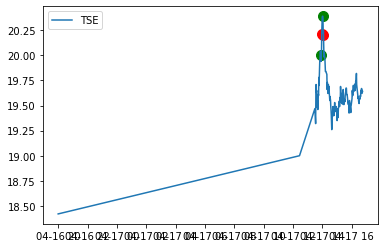

now=2020-04-17 09:58:39.156007
now=2020-04-17 10:52:17.856271
DK analysis for run 401 with profit 45.73


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1982.03,-1982.03,buy,2020-04-17 13:58:39.156007,15.13,"[13.93, 14.11, 14.42, 14.75]","[15.325, 15.34, 15.4, 15.78]",131,"{'avg': 14.5931, 'rsi': 70.85997837227481, 'macd': [0.16327270581875553, 0.1619233697865905, 0.17178444987778363, 0.1838547040816767, 0.19528462171627403], 'vwap': 15.1414, 'sell_macd': [0.09738820429502759, 0.09616459074010919, 0.10227392315523609, 0.10981010525591728, 0.11690570033104564], 'slow macd': [0.09771296304621657, 0.10110372126325728, 0.10662060241973847, 0.11278927940149686, 0.11909994258319401], 'macd_signal': [0.16628054481030854, 0.16540910980556495, 0.1666841778200087, 0.17011828307234228, 0.17515155080112862], 'resistances': [15.78], 'sell_macd_signal': [0.10125142677135784, 0.10023405956510811, 0.1006420322831337, 0.10247564687769042, 0.10536165756836147]}",17.41,14.38
1,-24.89,1957.14,sell,2020-04-17 14:37:31.048816,14.94,None,None,131,"{'avg': 14.8787, 'rsi': 47.53551404997622, 'vwap': 14.9832, 'reasons': 'below cost & macd negative', 'movement': -0.009907529722589192, 'sell_macd': [0.01145120044848369, 0.008990705861402049, 0.006437194418724701, 0.0022859232371725824, -0.0004590403229602913], 'sell_macd_signal': [0.022158368770839754, 0.019524836188952212, 0.01690730783490671, 0.013983030915359884, 0.011094616667695848]}",17.41,14.38
2,-3309.79,-3284.90,buy,2020-04-17 14:52:17.856271,15.35,"[13.93, 14.11, 14.42, 14.75, 14.9, 14.96, 14.98]","[15.4, 15.78]",214,"{'avg': 14.9478, 'rsi': 70.41680089251726, 'macd': [0.05832806381892475, 0.059656004467202095, 0.05921885250254988, 0.06378554139061343, 0.07301829717025754], 'vwap': 15.37, 'sell_macd': [0.034825347169576304, 0.035649641494318374, 0.03530948588380056, 0.03822222844854295, 0.04415134955810096], 'slow macd': [0.09195779074805976, 0.09187971660280603, 0.09150100109915016, 0.09212577983633352, 0.09383274215337245], 'macd_signal': [0.0371969558728499, 0.04168876559172034, 0.04519478297388625, 0.04891293465723169, 0.05373400715983686], 'resistances': [15.78], 'sell_macd_signal': [0.020542729342903625, 0.023564111773186576, 0.025913186595309372, 0.028374994965956087, 0.03153026588438506]}",16.72,14.92
3,45.73,3355.52,sell,2020-04-17 15:12:22.828518,15.68,None,None,214,"{'avg': 15.0577, 'rsi': 69.26435633656924, 'vwap': 15.69, 'reasons': 'bail', 'movement': 0.020819778789850377, 'sell_macd': [0.06341465911473065, 0.0629346142403513, 0.060704259607842204, 0.059216914964228096, 0.05988629686577163], 'sell_macd_signal': [0.06721209770952025, 0.06635660101568645, 0.0652261327341176, 0.0640242891801397, 0.0631966907172661]}",16.72,14.92


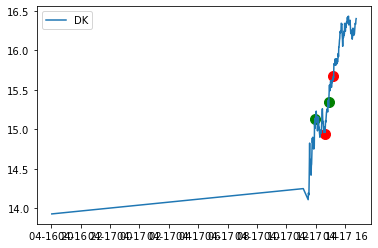

now=2020-04-17 09:54:42.663535
now=2020-04-17 10:41:56.618629
CATM analysis for run 401 with profit 21.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2817.92,-2817.92,buy,2020-04-17 13:54:42.663535,19.04,"[17.5, 18.41]",[19.48],148,"{'avg': 18.4215, 'rsi': 72.94798213968463, 'macd': [0.25341592517209577, 0.24318430416207804, 0.2619124152891317, 0.2696120759694267, 0.29091964971074447], 'vwap': 19.04, 'sell_macd': [0.1451210302174708, 0.1382693064952356, 0.15035537493901074, 0.15522302080508155, 0.1689481601707854], 'slow macd': [0.2307369786043303, 0.23254541048301292, 0.23975493471768772, 0.24520479298442766, 0.25350519470367416], 'macd_signal': [0.2961606164285493, 0.28556535397525507, 0.2808347662380304, 0.2785902281843097, 0.2810561124895966], 'resistances': [19.48], 'sell_macd_signal': [0.17539995265163086, 0.1679738234203518, 0.1644501337240836, 0.1626047111402832, 0.16387340094638364]}",21.06,18.38
1,16.28,2834.20,sell,2020-04-17 14:02:04.931321,19.15,None,None,148,"{'avg': 18.4669, 'rsi': 80.15129656968983, 'vwap': 19.51, 'reasons': 'rsi max', 'movement': 0.024146981627296633, 'sell_macd': [0.17744894201197425, 0.1859242403036525, 0.19237870338413288, 0.2051123278184832, 0.21964356338007107], 'sell_macd_signal': [0.16658850915950177, 0.1704556553883319, 0.1748402649874921, 0.18089467755369032, 0.18864445471896646]}",21.06,18.38
2,-2687.40,-2703.68,buy,2020-04-17 14:41:56.618629,19.04,"[17.5, 18.41, 18.51, 18.78]",[19.51],142,"{'avg': 18.6155, 'rsi': 63.649427215270414, 'macd': [-0.05760241594819604, -0.046007813943809595, -0.03081537289827807, -0.01297724532245681, 0.011516754861705891], 'vwap': 19.04, 'sell_macd': [-0.04499582294130988, -0.036527772876258524, -0.025818542008995138, -0.013502017411010314, 0.0030238721122408663], 'slow macd': [0.16990424457067377, 0.16586718401605438, 0.1630072299687768, 0.1612348256574343, 0.16142545275738485], 'macd_signal': [-0.03953203717891941, -0.04082719253189745, -0.03882482860517357, -0.033655311948630216, -0.024620898586562995], 'resistances': [19.51], 'sell_macd_signal': [-0.03744205476198134, -0.03725919838483678, -0.03497106710966845, -0.03067725716993682, -0.023937031313501285]}",21.07,18.36
3,21.96,2709.36,sell,2020-04-17 15:40:23.180259,19.08,None,None,142,"{'avg': 18.823, 'rsi': 43.45066742349046, 'vwap': 19.09, 'reasons': 'below cost & macd negative', 'movement': -0.02051282051282044, 'sell_macd': [0.019354516945107036, 0.012636849985593557, 0.005939488069277132, 0.0014228490686498674, -0.0031540494911723727], 'sell_macd_signal': [0.03671376701555758, 0.031898383609564776, 0.026706604501507247, 0.02164985341493577, 0.016689072833714142]}",21.07,18.36


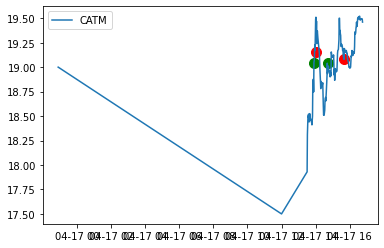

now=2020-04-17 10:57:49.415752
NRGU analysis for run 401 with profit 103.25


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3332.34,-3332.34,buy,2020-04-17 14:57:49.415752,2.42,"[2.04, 2.06, 2.19, 2.32, 2.3501, 2.37]",[2.4651],1377,"{'avg': 2.3047, 'rsi': 61.086384482632894, 'macd': [0.003364399758678527, 0.0019627871309140232, 0.0016400104324554299, 0.0029638747236067076, 0.005562755581646872], 'vwap': 2.4031, 'sell_macd': [0.0017823605317497382, 0.0008887414169214125, 0.0007003532570948323, 0.0015834228305147136, 0.0032899260977186096], 'slow macd': [0.02177641483974213, 0.021020324126740597, 0.020451013440165422, 0.02021439291094973, 0.020284236409802148], 'macd_signal': [0.0021074439447124156, 0.002078512581952737, 0.0019908121520532756, 0.002185424666363962, 0.002860890849420544], 'resistances': [2.45, 2.4651], 'sell_macd_signal': [0.0007620681737203043, 0.0007874028223605259, 0.0007699929093073871, 0.0009326788935488525, 0.001404128334382804]}",2.63,2.35
1,-1598.58,1733.76,sell,2020-04-17 15:42:37.671930,2.52,None,None,688,"{'avg': 2.3377, 'rsi': 74.57838748783396, 'vwap': 2.5299, 'reasons': 'scale-out', 'movement': 0.02016210331061729, 'sell_macd': [0.009635119668463865, 0.010253191421660812, 0.010523725366727632, 0.011449807332146733, 0.012204549028159484], 'sell_macd_signal': [0.008934062582397376, 0.009197888350250063, 0.009463055753545576, 0.009860406069265807, 0.010329234661044542]}",2.63,2.35
2,-956.38,642.20,sell,2020-04-17 15:57:24.961812,2.47,None,None,260,"{'avg': 2.3469, 'rsi': 39.381204870189364, 'vwap': 2.47, 'reasons': 'below cost & macd negative', 'movement': -0.02367682517095531, 'sell_macd': [0.004172457851346678, 0.003088751831692438, 0.0017106854289523632, 0.00035491049916869244, -0.0009658869850674989], 'sell_macd_signal': [0.00793189507424805, 0.0069632664257369276, 0.005912750226380015, 0.004801182280937751, 0.0036477684277367007]}",2.63,2.35
3,103.25,1059.63,sell,2020-04-17 15:57:25.305696,2.47,None,None,429,"{'avg': 2.3469, 'rsi': 39.381204870189364, 'vwap': 2.47, 'reasons': 'below cost & macd negative', 'movement': -0.02367682517095531, 'sell_macd': [0.004172457851346678, 0.003088751831692438, 0.0017106854289523632, 0.00035491049916869244, -0.0009658869850674989], 'sell_macd_signal': [0.00793189507424805, 0.0069632664257369276, 0.005912750226380015, 0.004801182280937751, 0.0036477684277367007]}",2.63,2.35


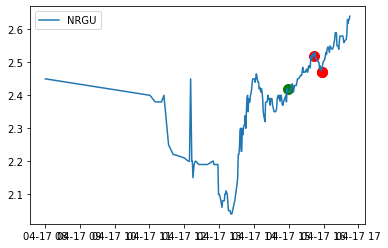

now=2020-04-17 10:57:13.818978
ERX analysis for run 401 with profit 98.66


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5370.30,-5370.30,buy,2020-04-17 14:57:13.818978,11.70,"[10.8, 11.27, 11.46, 11.46, 11.52]",[11.8335],459,"{'avg': 11.4838, 'rsi': 65.02106698324516, 'macd': [0.004285145428267967, 0.00932248295520921, 0.013960596596485075, 0.019828513590686825, 0.025795360083685992], 'vwap': 11.7, 'sell_macd': [0.0027971757420033327, 0.006061026580907125, 0.009045052863417169, 0.012811241487925784, 0.016618515201985318], 'slow macd': [0.040929489919156126, 0.040890002792291824, 0.040948211552755964, 0.04141608260897911, 0.04210017176129277], 'macd_signal': [0.00194478234137998, 0.003420322464145826, 0.0055283772906136765, 0.008388404550628305, 0.011869795657239843], 'resistances': [11.8335], 'sell_macd_signal': [0.0012186994574656985, 0.0021871648821539837, 0.003558742478406621, 0.0054092422803104535, 0.007651096864645426]}",12.33,11.49
1,-2636.04,2734.26,sell,2020-04-17 15:34:57.505758,11.94,None,None,229,"{'avg': 11.5616, 'rsi': 69.39222252630664, 'vwap': 11.94, 'reasons': 'scale-out', 'movement': 0.020512820512820534, 'sell_macd': [0.01860909947187217, 0.018377637568558924, 0.017958607026125506, 0.01895730261609785, 0.02104774979508761], 'sell_macd_signal': [0.023241666336408055, 0.02226886058283823, 0.021406809871495687, 0.02091690842041612, 0.020943076695350418]}",12.33,11.49
2,98.66,2734.70,sell,2020-04-17 15:55:08.806351,11.89,None,None,230,"{'avg': 11.597, 'rsi': 45.484100677028486, 'vwap': 11.8967, 'reasons': 'below cost & macd negative', 'movement': -0.004187604690117164, 'sell_macd': [0.005630839825407463, 0.0037468731806207245, 0.003580835883635558, 0.002049107653730786, -0.00020482483260764184], 'sell_macd_signal': [0.0165324877133112, 0.013975364806773105, 0.011896459022145596, 0.009926988748462633, 0.007900626032248578]}",12.33,11.49


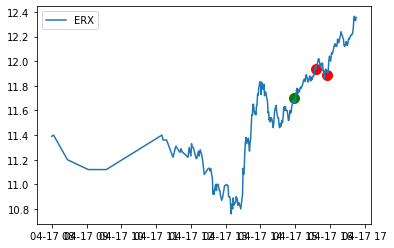

now=2020-04-17 10:56:05.182245
PBF analysis for run 401 with profit 42.46


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2833.24,-2833.24,buy,2020-04-17 14:56:05.182245,7.34,"[6.52, 6.92, 7.07, 7.13, 7.15]","[7.49, 7.6]",386,"{'avg': 7.066, 'rsi': 69.76590094590495, 'macd': [0.019629136281945847, 0.020821861600071934, 0.020673462785496532, 0.025506786075667698, 0.029800623000152626], 'vwap': 7.34, 'sell_macd': [0.011628316576207887, 0.012393493734244032, 0.012278131860840702, 0.015405406610645045, 0.018161654381782633], 'slow macd': [0.04904303400876575, 0.048644638160237896, 0.04803076874796108, 0.04842875491643728, 0.048877395921634204], 'macd_signal': [0.014777228681367115, 0.01598615526510808, 0.01692361676918577, 0.018640250630482157, 0.02087232510441625], 'resistances': [7.49, 7.6], 'sell_macd_signal': [0.0082924081021509, 0.009112625228569527, 0.009745726555023763, 0.010877662566148019, 0.012334460929274942]}",8.09,7.09
1,-1387.67,1445.57,sell,2020-04-17 15:40:22.844636,7.49,None,None,193,"{'avg': 7.1419, 'rsi': 69.33790337998234, 'vwap': 7.4873, 'reasons': 'scale-out', 'movement': 0.020435967302452365, 'sell_macd': [0.009407613013666882, 0.0101049460825271, 0.010776829693553758, 0.012978598355476656, 0.01504518954196854], 'sell_macd_signal': [0.00992707113300064, 0.00996264612290593, 0.010125482837035496, 0.010696105940723729, 0.01156592266097269]}",8.09,7.09
2,42.46,1430.13,sell,2020-04-17 15:52:15.621557,7.41,None,None,193,"{'avg': 7.1739, 'rsi': 45.008993669684365, 'vwap': 7.4099, 'reasons': 'below cost & macd negative', 'movement': -0.010680907877169568, 'sell_macd': [0.0135941859255162, 0.009879109746144366, 0.0045182827265550785, 0.0019290891693870549, -0.00020182904619048259], 'sell_macd_signal': [0.016810381042957293, 0.015424126783594708, 0.013242957972186782, 0.010980184211626836, 0.008743781560063373]}",8.09,7.09


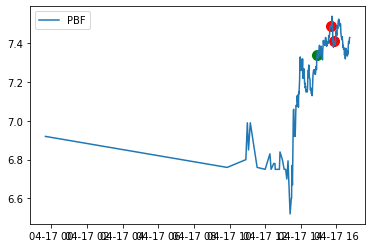

now=2020-04-17 09:53:00.723588
now=2020-04-17 09:53:00.883654
MOV analysis for run 401 with profit -58.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-144.45,-144.45,buy,2020-04-17 13:53:00.723588,9.63,"[9.03, 9.06, 9.065, 9.07, 9.08, 9.12, 9.26, 9.3, 9.46]",[9.85],15,"{'avg': 9.4359, 'rsi': 68.98405940967264, 'macd': [0.049392630855320974, 0.05526331073885693, 0.06157836408648443, 0.06746761256013478, 0.08008776321544353], 'vwap': 9.6433, 'sell_macd': [0.029214460633962602, 0.03294961275851982, 0.036959476585986195, 0.040674182469908615, 0.04875480806166799], 'slow macd': [0.037801501852746, 0.0398629291657393, 0.042165964963635005, 0.04454686120957696, 0.04842541171620596], 'macd_signal': [0.051075897111443724, 0.051913379836926364, 0.05384637668683798, 0.05657062386149734, 0.061274051732286575], 'resistances': [9.85], 'sell_macd_signal': [0.030841593189567217, 0.03126319710335774, 0.03240245299988343, 0.03405679889388847, 0.036996400727444374]}",10.97,9.21
1,-2166.75,-2022.30,buy,2020-04-17 13:53:00.883654,9.63,"[9.03, 9.06, 9.065, 9.07, 9.08, 9.12, 9.26, 9.3, 9.46]",[9.85],210,"{'avg': 9.4359, 'rsi': 68.98405940967264, 'macd': [0.049392630855320974, 0.05526331073885693, 0.06157836408648443, 0.06746761256013478, 0.08008776321544353], 'vwap': 9.6433, 'sell_macd': [0.029214460633962602, 0.03294961275851982, 0.036959476585986195, 0.040674182469908615, 0.04875480806166799], 'slow macd': [0.037801501852746, 0.0398629291657393, 0.042165964963635005, 0.04454686120957696, 0.04842541171620596], 'macd_signal': [0.051075897111443724, 0.051913379836926364, 0.05384637668683798, 0.05657062386149734, 0.061274051732286575], 'resistances': [9.85], 'sell_macd_signal': [0.030841593189567217, 0.03126319710335774, 0.03240245299988343, 0.03405679889388847, 0.036996400727444374]}",10.97,9.21
2,-58.50,2108.25,sell,2020-04-17 14:19:22.518745,9.37,None,None,225,"{'avg': 9.4868, 'rsi': 39.24111670814624, 'vwap': 9.398, 'reasons': 'below cost & macd negative', 'movement': -0.02797927461139892, 'sell_macd': [0.020764113142607954, 0.012594278521872226, 0.004506170005431187, 0.0007426286938496673, -0.006874970103408984], 'sell_macd_signal': [0.035979859379061216, 0.03130274320762342, 0.025943428567184974, 0.020903268592517912, 0.015347620853332532]}",10.97,9.21


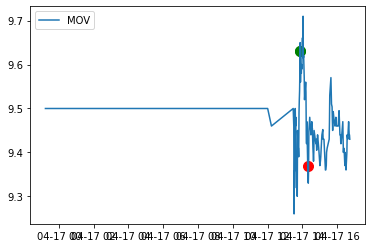

now=2020-04-17 10:49:38.028500
now=2020-04-17 10:49:38.274511
QNST analysis for run 401 with profit 45.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1579.5,-1579.5,buy,2020-04-17 14:49:38.028500,8.1,"[7.31, 7.33, 7.56, 7.85, 7.92, 7.97]","[8.22, 8.315, 8.36, 8.62]",195,"{'avg': 7.973, 'rsi': 69.62173427989214, 'macd': [0.0027386054713405272, 0.002923641074859873, 0.005428456535453208, 0.010519939229246766, 0.019973152858523413], 'vwap': 8.1117, 'sell_macd': [-0.0017789657497333522, -0.0014300275109038196, 0.00041888575975423947, 0.003932079402347632, 0.010254930560182451], 'slow macd': [0.06280751030299392, 0.06141872860648423, 0.06052258242571895, 0.060241045963646656, 0.061005228457415406], 'macd_signal': [0.01586187388293504, 0.013274227321320007, 0.011705073164146648, 0.011468046377166672, 0.01316906767343802], 'resistances': [8.22, 8.315, 8.36, 8.395, 8.62], 'sell_macd_signal': [0.005898528013200186, 0.004432816908379385, 0.0036300306786543556, 0.003690440423393011, 0.005003338450750899]}",8.75,7.91
1,-3701.7,-2122.2,buy,2020-04-17 14:49:38.274511,8.1,"[7.31, 7.33, 7.56, 7.85, 7.92, 7.97]","[8.22, 8.315, 8.36, 8.62]",262,"{'avg': 7.973, 'rsi': 69.62173427989214, 'macd': [0.0027386054713405272, 0.002923641074859873, 0.005428456535453208, 0.010519939229246766, 0.019973152858523413], 'vwap': 8.1117, 'sell_macd': [-0.0017789657497333522, -0.0014300275109038196, 0.00041888575975423947, 0.003932079402347632, 0.010254930560182451], 'slow macd': [0.06280751030299392, 0.06141872860648423, 0.06052258242571895, 0.060241045963646656, 0.061005228457415406], 'macd_signal': [0.01586187388293504, 0.013274227321320007, 0.011705073164146648, 0.011468046377166672, 0.01316906767343802], 'resistances': [8.22, 8.315, 8.36, 8.395, 8.62], 'sell_macd_signal': [0.005898528013200186, 0.004432816908379385, 0.0036300306786543556, 0.003690440423393011, 0.005003338450750899]}",8.75,7.91
2,45.7,3747.4,sell,2020-04-17 15:53:26.953945,8.2,None,None,457,"{'avg': 8.0403, 'rsi': 80.14768134107906, 'vwap': 8.23, 'reasons': 'rsi max', 'movement': 0.0135467980295568, 'sell_macd': [0.004457811717637483, 0.003949433689717452, 0.0037565490745894436, 0.005375644841052463, 0.010203827972828705], 'sell_macd_signal': [0.0048898888011848045, 0.004701797778891334, 0.004512748038030956, 0.004685327398635257, 0.005789027513473947]}",8.75,7.91


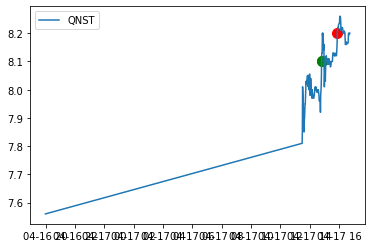

now=2020-04-17 10:43:37.561434
now=2020-04-17 10:43:37.753084
APPS analysis for run 401 with profit 55.02


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2525.00,-2525.00,buy,2020-04-17 14:43:37.561434,5.00,"[4.85, 4.86, 4.89, 4.9, 4.9102, 4.955]","[5.0, 5.0]",505,"{'avg': 4.9512, 'rsi': 64.6965278624736, 'macd': [-0.006136426230858305, -0.005448177524995934, -0.0016559806468992022, 0.0029294269430275577, 0.007884610360285649], 'vwap': 5.0048, 'sell_macd': [-0.004104486023486231, -0.0036023156495259556, -0.0010863086613817075, 0.0019272852080991498, 0.005159601402394465], 'slow macd': [0.014548748229727515, 0.01405860831708683, 0.014224923242214693, 0.014675059567584192, 0.015345616723283939], 'macd_signal': [-0.007111581112225969, -0.006778900394779961, -0.005754316445203809, -0.004017567767557535, -0.0016371321419888984], 'resistances': [5.07], 'sell_macd_signal': [-0.005085403849166196, -0.004788786209238148, -0.0040482906996668604, -0.002853175518113658, -0.0012506201340120333]}",5.37,4.88
1,-3930.00,-1405.00,buy,2020-04-17 14:43:37.753084,5.00,"[4.85, 4.86, 4.89, 4.9, 4.9102, 4.955]","[5.0, 5.0]",281,"{'avg': 4.9512, 'rsi': 64.6965278624736, 'macd': [-0.006136426230858305, -0.005448177524995934, -0.0016559806468992022, 0.0029294269430275577, 0.007884610360285649], 'vwap': 5.0048, 'sell_macd': [-0.004104486023486231, -0.0036023156495259556, -0.0010863086613817075, 0.0019272852080991498, 0.005159601402394465], 'slow macd': [0.014548748229727515, 0.01405860831708683, 0.014224923242214693, 0.014675059567584192, 0.015345616723283939], 'macd_signal': [-0.007111581112225969, -0.006778900394779961, -0.005754316445203809, -0.004017567767557535, -0.0016371321419888984], 'resistances': [5.07], 'sell_macd_signal': [-0.005085403849166196, -0.004788786209238148, -0.0040482906996668604, -0.002853175518113658, -0.0012506201340120333]}",5.37,4.88
2,55.02,3985.02,sell,2020-04-17 15:20:20.547323,5.07,None,None,786,"{'avg': 4.9605, 'rsi': 78.78223996520765, 'vwap': 5.0744, 'reasons': 'rsi max', 'movement': 0.015492253873063404, 'sell_macd': [0.00927154244588646, 0.009196633164590295, 0.009740903423780978, 0.0100385048799847, 0.01221795400326009], 'sell_macd_signal': [0.009187954423637724, 0.009189690171828238, 0.009299932822218786, 0.009447647233771969, 0.010001708587669593]}",5.37,4.88


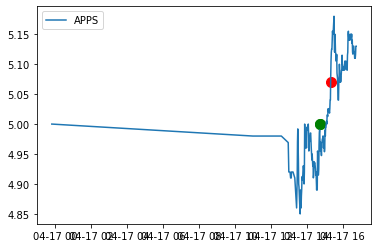

now=2020-04-17 10:11:12.666774
CLAR analysis for run 401 with profit -60.03


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1970.64,-1970.64,buy,2020-04-17 14:11:12.666774,9.52,"[8.89, 8.89, 8.9, 8.9, 8.9, 8.93, 8.95, 8.96, 8.96, 9.03, 9.1, 9.22]",[9.68],207,"{'avg': 9.1974, 'rsi': 70.24912856741894, 'macd': [0.0994243458515367, 0.12345098553745792, 0.1456547518379665, 0.1558069362404968, 0.15719902446195988], 'vwap': 9.52, 'sell_macd': [0.06341757289630934, 0.07869448087109454, 0.0926934418790939, 0.09876154861417064, 0.09909044284131951], 'slow macd': [0.025379029907208306, 0.03308355904386495, 0.041078675920024565, 0.047249187406775306, 0.0518910707260023], 'macd_signal': [0.051537763031381884, 0.06592040753259709, 0.08186727639367097, 0.09665520836303614, 0.10876397158282089], 'resistances': [9.65], 'sell_macd_signal': [0.03281829032733561, 0.0419935284360874, 0.0521335111246887, 0.06145911862258509, 0.06898538346633197]}",10.95,9.04
1,-1878.34,92.30,sell,2020-04-17 15:40:22.969488,9.23,None,None,10,"{'avg': 9.2523, 'rsi': 41.98389854709386, 'vwap': 9.26, 'reasons': 'below cost & macd negative', 'movement': -0.02731092436974788, 'sell_macd': [0.0033358097751055027, 0.004622090683902513, 0.004005918785772167, 0.0024347988809196863, -0.0019379542771584823], 'sell_macd_signal': [0.00755996946642095, 0.0069723937099172625, 0.0063790987250882435, 0.005590238756254532, 0.004084600149571929]}",10.95,9.04
2,-60.03,1818.31,sell,2020-04-17 15:40:23.043881,9.23,None,None,197,"{'avg': 9.2523, 'rsi': 41.98389854709386, 'vwap': 9.26, 'reasons': 'below cost & macd negative', 'movement': -0.02731092436974788, 'sell_macd': [0.0033358097751055027, 0.004622090683902513, 0.004005918785772167, 0.0024347988809196863, -0.0019379542771584823], 'sell_macd_signal': [0.00755996946642095, 0.0069723937099172625, 0.0063790987250882435, 0.005590238756254532, 0.004084600149571929]}",10.95,9.04


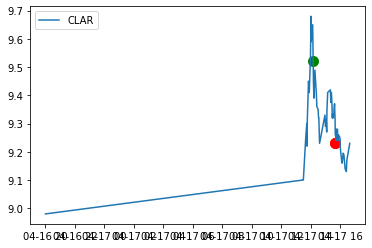

now=2020-04-17 10:29:40.168351
WHD analysis for run 401 with profit -60.75


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2940.75,-2940.75,buy,2020-04-17 14:29:40.168351,13.07,"[12.12, 12.195, 12.39, 12.64, 12.7]","[13.0718, 13.105, 13.11]",225,"{'avg': 12.8708, 'rsi': 65.69363444343647, 'macd': [-0.018375986604613814, -0.0054458936310251005, 0.004347722158891898, 0.012370096670547781, 0.03287343742275084], 'vwap': 13.12, 'sell_macd': [-0.01763987984936044, -0.008742557104948645, -0.0019557789001485304, 0.003617759686710187, 0.017264442225995325], 'slow macd': [0.08043239341782638, 0.08049083756080933, 0.08033590618246578, 0.08014484631589269, 0.08271973310587732], 'macd_signal': [0.008963120266808084, 0.006081317487241447, 0.005734598421571537, 0.007061698071366786, 0.012224045941643596], 'resistances': [13.62], 'sell_macd_signal': [-0.0013896250999589112, -0.002860211500956858, -0.0026793249807951927, -0.0014199080472941166, 0.002316962007363772]}",14.41,12.69
1,-982.35,1958.40,sell,2020-04-17 14:43:32.894366,12.80,None,None,153,"{'avg': 12.8775, 'rsi': 46.4575112290143, 'vwap': 12.82, 'reasons': 'below cost & macd negative', 'movement': -0.022865853658536505, 'sell_macd': [0.005532552498868526, 0.0042797611849234585, 0.003247978846978583, 0.0008433695077094683, -0.002080265945066273], 'sell_macd_signal': [0.01029703748883031, 0.00909358222804894, 0.007924461551834868, 0.006508243143009788, 0.0047905413253945765]}",14.41,12.69
2,-60.75,921.60,sell,2020-04-17 14:43:33.226730,12.80,None,None,72,"{'avg': 12.8775, 'rsi': 46.4575112290143, 'vwap': 12.82, 'reasons': 'below cost & macd negative', 'movement': -0.022865853658536505, 'sell_macd': [0.005532552498868526, 0.0042797611849234585, 0.003247978846978583, 0.0008433695077094683, -0.002080265945066273], 'sell_macd_signal': [0.01029703748883031, 0.00909358222804894, 0.007924461551834868, 0.006508243143009788, 0.0047905413253945765]}",14.41,12.69


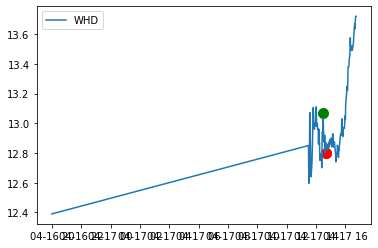

now=2020-04-17 09:55:05.984312
XEC analysis for run 401 with profit 15.98


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1619.33,-1619.33,buy,2020-04-17 13:55:05.984312,19.51,"[18.23, 18.3501, 18.71]",[19.87],83,"{'avg': 18.863, 'rsi': 66.15637956102383, 'macd': [0.19126495463544302, 0.1935415611492779, 0.19391734618263357, 0.19687595444315065, 0.21042385602112645], 'vwap': 19.51, 'sell_macd': [0.11996720478476419, 0.12076657456702478, 0.12034054355882517, 0.12161973311660645, 0.1298110531211556], 'slow macd': [0.047536637499689505, 0.05375843871694386, 0.05955665177013714, 0.06577314982224536, 0.07408865138906151], 'macd_signal': [0.13894493587504145, 0.14986426092988875, 0.15867487798043772, 0.1663150932729803, 0.17513684582260952], 'resistances': [19.87], 'sell_macd_signal': [0.08794793144020183, 0.09451166006556641, 0.09967743676421817, 0.10406589603469582, 0.10921492745198777]}",23.05,18.33
1,-803.02,816.31,sell,2020-04-17 14:27:25.104546,19.91,None,None,41,"{'avg': 19.2336, 'rsi': 66.66887277849915, 'vwap': 19.902, 'reasons': 'scale-out', 'movement': 0.020502306509482243, 'sell_macd': [0.02026950619431034, 0.019164474331365255, 0.019872703083208876, 0.026659989083562152, 0.03939475753730193], 'sell_macd_signal': [0.036303192784781765, 0.032875449094098466, 0.03027489989192055, 0.02955191773024887, 0.03152048569165948]}",23.05,18.33
2,15.98,819.00,sell,2020-04-17 14:35:06.986348,19.50,None,None,42,"{'avg': 19.2612, 'rsi': 46.52666363570422, 'vwap': 19.53, 'reasons': 'below cost & macd negative', 'movement': -0.019085886489201356, 'sell_macd': [0.02357409708416114, 0.015170344209973763, 0.009463908928658782, 0.0033359865155730972, -0.0009628619428774243], 'sell_macd_signal': [0.03022817072273968, 0.027216605420186495, 0.023666066121880953, 0.019600050200619383, 0.015487467771920022]}",23.05,18.33


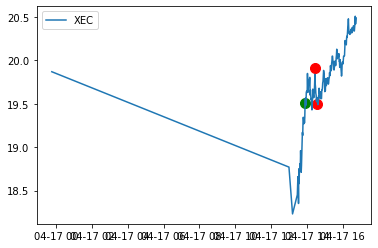

now=2020-04-17 10:14:19.989093
AXGN analysis for run 401 with profit 56.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2729.34,-2729.34,buy,2020-04-17 14:14:19.989093,7.71,"[7.21, 7.23, 7.25, 7.37, 7.46]","[7.76, 7.84, 8.13]",354,"{'avg': 7.5054, 'rsi': 69.54706947585319, 'macd': [0.05485241147440156, 0.06259056602170343, 0.07033310230780376, 0.07479995435750819, 0.07944150562884378], 'vwap': 7.7299, 'sell_macd': [0.03330412972495189, 0.0382262259510906, 0.043123622673392425, 0.045860248396310865, 0.048695797681749475], 'slow macd': [0.030293022890648835, 0.03309412238261267, 0.0360981021672897, 0.03864418976260087, 0.04132470587525994], 'macd_signal': [0.04166829751672144, 0.04585275121771784, 0.050748821435735024, 0.05555904802008966, 0.06033553954184048], 'resistances': [8.13], 'sell_macd_signal': [0.02503692098060001, 0.02767478197469813, 0.03076455011443699, 0.03378368977081177, 0.03676611135299931]}",8.54,7.44
1,-1336.35,1392.99,sell,2020-04-17 14:51:13.764773,7.87,None,None,177,"{'avg': 7.6118, 'rsi': 69.02308185846327, 'vwap': 7.87, 'reasons': 'scale-out', 'movement': 0.020090732339598218, 'sell_macd': [0.01362952309450094, 0.012010734598012718, 0.011112837917656826, 0.012087037414553414, 0.016065802770387272], 'sell_macd_signal': [0.016771912445318653, 0.015819676875857468, 0.014878309084217339, 0.014320054750284554, 0.014669204354305097]}",8.54,7.44
2,56.64,1392.99,sell,2020-04-17 15:24:20.703976,7.87,None,None,177,"{'avg': 7.6804, 'rsi': 41.50182351852464, 'vwap': 7.87, 'reasons': 'below cost & macd negative', 'movement': 0.0, 'sell_macd': [0.012314200855072066, 0.009443667586843674, 0.005525801824759036, 0.0018816752332027065, -0.0009823412697400613], 'sell_macd_signal': [0.02146898239460739, 0.019063919433054646, 0.016356295911395525, 0.013461371775756962, 0.010572629166657558]}",8.54,7.44


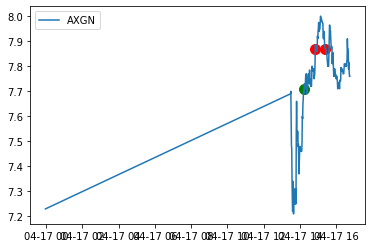

now=2020-04-17 09:52:45.193014
RTRX analysis for run 401 with profit -30.03


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2046.33,-2046.33,buy,2020-04-17 13:52:45.193014,14.31,"[13.26, 13.685]","[14.475, 14.66]",143,"{'avg': 14.0618, 'rsi': 72.03520077771303, 'macd': [0.15758951460904846, 0.17160993698414018, 0.17984120879386545, 0.18104985526822226, 0.1942925286567565], 'vwap': 14.3025, 'sell_macd': [0.09801678864418228, 0.10662449068503221, 0.1114275768118631, 0.11164520786118715, 0.11971550208324189], 'slow macd': [0.050039893255494405, 0.057326732365377, 0.0637792353091502, 0.06897399433849394, 0.07652187300669233], 'macd_signal': [0.12050350274198295, 0.1307247895904144, 0.1405480734311046, 0.14864842979852813, 0.1577772495701738], 'resistances': [14.475, 14.66, 14.68, 14.7, 14.7], 'sell_macd_signal': [0.07563454540458023, 0.08183253446067063, 0.08775154293090912, 0.09253027591696472, 0.09796732115022015]}",16.38,13.62
1,-791.43,1254.90,sell,2020-04-17 14:34:51.260771,14.10,None,None,89,"{'avg': 14.1141, 'rsi': 48.77717979648491, 'vwap': 14.1, 'reasons': 'below cost & macd negative', 'movement': -0.014675052410901527, 'sell_macd': [0.004206202062675857, 0.003041131480543413, 0.001574308540174485, 0.0009303645796254756, -0.00010297311144746857], 'sell_macd_signal': [0.009610700618681639, 0.008296786791053994, 0.0069522911408780915, 0.005747905828627569, 0.004577730040612561]}",16.38,13.62
2,-30.03,761.40,sell,2020-04-17 14:34:51.649546,14.10,None,None,54,"{'avg': 14.1141, 'rsi': 48.77717979648491, 'vwap': 14.1, 'reasons': 'below cost & macd negative', 'movement': -0.014675052410901527, 'sell_macd': [0.004206202062675857, 0.003041131480543413, 0.001574308540174485, 0.0009303645796254756, -0.00010297311144746857], 'sell_macd_signal': [0.009610700618681639, 0.008296786791053994, 0.0069522911408780915, 0.005747905828627569, 0.004577730040612561]}",16.38,13.62


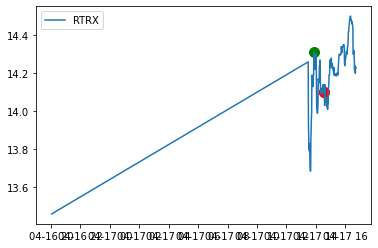

now=2020-04-17 10:03:31.385619
EVOP analysis for run 401 with profit 36.54


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1261.50,-1261.50,buy,2020-04-17 14:03:31.385619,14.50,"[12.79, 12.805, 12.83, 12.84, 12.855, 13.38, 14.0]","[15.0, 15.01, 15.01, 15.04, 15.055]",87,"{'avg': 13.9885, 'rsi': 74.84342613684977, 'macd': [0.29478832485319906, 0.3019789277350178, 0.312946164434619, 0.32275871553049207, 0.3267684496878811], 'vwap': 14.4882, 'sell_macd': [0.1787362110180446, 0.1826169484436111, 0.18898353671751167, 0.19460706606447786, 0.1964616724898498], 'slow macd': [0.15589700838693688, 0.16431279119098718, 0.17355208150180523, 0.18273456797888876, 0.1908904908544784], 'macd_signal': [0.2862878087588095, 0.28942603255405114, 0.2941300589301647, 0.2998557902502302, 0.30523832213776037], 'resistances': [15.0, 15.01, 15.01], 'sell_macd_signal': [0.17701248103554473, 0.178133374517158, 0.18030340695722874, 0.18316413877867857, 0.18582364552091282]}",17.89,13.37
1,-1112.30,149.20,sell,2020-04-17 15:53:48.671322,14.92,None,None,10,"{'avg': 14.2877, 'rsi': 79.51003889726842, 'vwap': 15.11, 'reasons': 'rsi max', 'movement': 0.020256583389601547, 'sell_macd': [0.01822341638323799, 0.024202641334618136, 0.036796808292388405, 0.04671438243750181, 0.06370581186957125], 'sell_macd_signal': [0.01697331376534098, 0.01841917927919641, 0.02209470508183481, 0.02701864055296821, 0.034356074816288815]}",17.89,13.37
2,36.54,1148.84,sell,2020-04-17 15:53:49.207518,14.92,None,None,77,"{'avg': 14.2877, 'rsi': 79.51003889726842, 'vwap': 15.11, 'reasons': 'rsi max', 'movement': 0.020256583389601547, 'sell_macd': [0.01822341638323799, 0.024202641334618136, 0.036796808292388405, 0.04671438243750181, 0.06370581186957125], 'sell_macd_signal': [0.01697331376534098, 0.01841917927919641, 0.02209470508183481, 0.02701864055296821, 0.034356074816288815]}",17.89,13.37


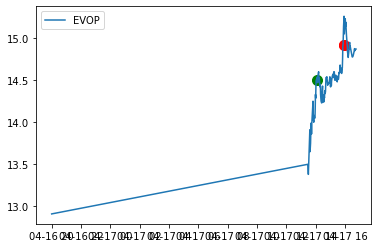

now=2020-04-17 09:53:17.438696
now=2020-04-17 09:53:17.522647
ELF analysis for run 401 with profit -16.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1552.52,-1552.52,buy,2020-04-17 13:53:17.438696,10.49,"[10.1, 10.11, 10.23]",[10.72],148,"{'avg': 10.2227, 'rsi': 61.6035335725276, 'macd': [0.07262983805129508, 0.06914406687611852, 0.06682166419612479, 0.07859959184916576, 0.08892589309471965], 'vwap': 10.5026, 'sell_macd': [0.043130319616183854, 0.040702214704046114, 0.03906080549063873, 0.046625151486805905, 0.05321262691905737], 'slow macd': [0.044239222011658086, 0.045156934992196085, 0.04616894212064615, 0.0499050287396301, 0.05366237188050249], 'macd_signal': [0.0796033688363704, 0.07751150844432002, 0.07537353959468097, 0.07601875004557793, 0.07860017865540628], 'resistances': [10.72], 'sell_macd_signal': [0.048710841384041914, 0.04710911604804276, 0.04549945393656195, 0.04572459344661074, 0.04722220014110007]}",12.29,9.91
1,-1741.34,-188.82,buy,2020-04-17 13:53:17.522647,10.49,"[10.1, 10.11, 10.23]",[10.72],18,"{'avg': 10.2227, 'rsi': 61.6035335725276, 'macd': [0.07262983805129508, 0.06914406687611852, 0.06682166419612479, 0.07859959184916576, 0.08892589309471965], 'vwap': 10.5026, 'sell_macd': [0.043130319616183854, 0.040702214704046114, 0.03906080549063873, 0.046625151486805905, 0.05321262691905737], 'slow macd': [0.044239222011658086, 0.045156934992196085, 0.04616894212064615, 0.0499050287396301, 0.05366237188050249], 'macd_signal': [0.0796033688363704, 0.07751150844432002, 0.07537353959468097, 0.07601875004557793, 0.07860017865540628], 'resistances': [10.72], 'sell_macd_signal': [0.048710841384041914, 0.04710911604804276, 0.04549945393656195, 0.04572459344661074, 0.04722220014110007]}",12.29,9.91
2,-16.60,1724.74,sell,2020-04-17 14:19:13.790298,10.39,None,None,166,"{'avg': 10.2618, 'rsi': 46.47726641441866, 'vwap': 10.4, 'reasons': 'below cost & macd negative', 'movement': -0.009995240361732547, 'sell_macd': [0.009566168226452731, 0.00793835038827595, 0.0034499423275118346, 0.0009466380940903463, -0.0010162825825226207], 'sell_macd_signal': [0.02375088747497896, 0.02058838005763836, 0.017160692511613056, 0.013917881628108513, 0.010931048785982287]}",12.29,9.91


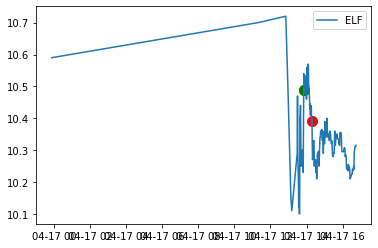

now=2020-04-17 09:59:58.144680
now=2020-04-17 09:59:58.677484
TPC analysis for run 401 with profit -96.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-12.50,-12.50,buy,2020-04-17 13:59:58.144680,6.25,"[5.81, 5.87, 5.93, 6.03]","[6.47, 6.51, 6.52]",2,"{'avg': 5.9679, 'rsi': 69.91747304165249, 'macd': [0.07761989635102662, 0.07837503663627654, 0.07887122874994734, 0.08394521141735378, 0.09095251736569399], 'vwap': 6.2408, 'sell_macd': [0.04475290716588631, 0.045193274883694734, 0.0454689734315501, 0.04872966095674158, 0.0532350062886211], 'slow macd': [0.06827798110442984, 0.06965179063987392, 0.07096427707669761, 0.07317786131613158, 0.07589707198773255], 'macd_signal': [0.08156472292555345, 0.08092678566769806, 0.08051567428414792, 0.08120158171078909, 0.08315176884177007], 'resistances': [6.38], 'sell_macd_signal': [0.04780237170224354, 0.047280552338533774, 0.04691823655713704, 0.04728052143705795, 0.048471418407370584]}",7.3,5.9
1,-1775.00,-1762.50,buy,2020-04-17 13:59:58.677484,6.25,"[5.81, 5.87, 5.93, 6.03]","[6.47, 6.51, 6.52]",282,"{'avg': 5.9679, 'rsi': 69.91747304165249, 'macd': [0.07761989635102662, 0.07837503663627654, 0.07887122874994734, 0.08394521141735378, 0.09095251736569399], 'vwap': 6.2408, 'sell_macd': [0.04475290716588631, 0.045193274883694734, 0.0454689734315501, 0.04872966095674158, 0.0532350062886211], 'slow macd': [0.06827798110442984, 0.06965179063987392, 0.07096427707669761, 0.07317786131613158, 0.07589707198773255], 'macd_signal': [0.08156472292555345, 0.08092678566769806, 0.08051567428414792, 0.08120158171078909, 0.08315176884177007], 'resistances': [6.38], 'sell_macd_signal': [0.04780237170224354, 0.047280552338533774, 0.04691823655713704, 0.04728052143705795, 0.048471418407370584]}",7.3,5.9
2,-96.56,1678.44,sell,2020-04-17 14:12:42.590292,5.91,None,None,284,"{'avg': 6.0669, 'rsi': 35.142626555222215, 'vwap': 5.9041, 'reasons': 'stopped', 'movement': -0.055999999999999946, 'sell_macd': [0.03430905104853643, 0.02780625301894446, 0.020300095424211406, 0.01210958177345578, 0.00037529085373133597], 'sell_macd_signal': [0.04763617854324229, 0.04367019343838273, 0.038996173835548466, 0.03361885542312993, 0.02697014250925021]}",7.3,5.9


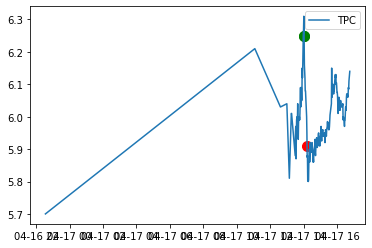

now=2020-04-17 10:11:42.768377
RAD analysis for run 401 with profit -90.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4968.72,-4968.72,buy,2020-04-17 14:11:42.768377,12.06,"[11.533, 11.6458, 11.83, 11.85]","[12.57, 12.6098, 12.75]",412,"{'avg': 11.846, 'rsi': 68.75557725412851, 'macd': [0.05298212470192354, 0.05639193383171026, 0.061611676781467395, 0.06662644203519186, 0.07049810778058685], 'vwap': 12.0646, 'sell_macd': [0.028362254358526684, 0.03068985768463328, 0.034182927059720924, 0.03752060544213087, 0.04009125605904451], 'slow macd': [0.0683223003841178, 0.06938956633885063, 0.07090025034384162, 0.07250300240066387, 0.07400237084254435], 'macd_signal': [0.06462389380576498, 0.06297750181095405, 0.06270433680505672, 0.06348875785108374, 0.06489062783698436], 'resistances': [12.57, 12.6098, 12.75, 14.92], 'sell_macd_signal': [0.035869919089417356, 0.03483390680846054, 0.034703710858712614, 0.03526708977539626, 0.03623192303212591]}",12.79,11.83
1,-4566.16,402.56,sell,2020-04-17 14:30:06.631778,11.84,None,None,34,"{'avg': 11.8636, 'rsi': 39.23492890107149, 'vwap': 11.8426, 'reasons': 'below cost & macd negative', 'movement': -0.01857621051933846, 'sell_macd': [0.011017317777788804, 0.00988907109482895, 0.007323046782198972, 0.0010725986583040026, -0.004071550511723032], 'sell_macd_signal': [0.014052307159340425, 0.01321965994643813, 0.012040337313590298, 0.009846789582533039, 0.007063121563681825]}",12.79,11.83
2,-90.64,4475.52,sell,2020-04-17 14:30:06.846460,11.84,None,None,378,"{'avg': 11.8636, 'rsi': 39.23492890107149, 'vwap': 11.8426, 'reasons': 'below cost & macd negative', 'movement': -0.01857621051933846, 'sell_macd': [0.011017317777788804, 0.00988907109482895, 0.007323046782198972, 0.0010725986583040026, -0.004071550511723032], 'sell_macd_signal': [0.014052307159340425, 0.01321965994643813, 0.012040337313590298, 0.009846789582533039, 0.007063121563681825]}",12.79,11.83


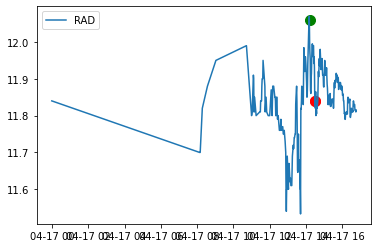

now=2020-04-17 10:52:19.786332
REAL analysis for run 401 with profit -48.07


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2555.30,-2555.30,buy,2020-04-17 14:52:19.786332,10.10,"[8.2992, 8.31, 8.38, 8.38, 8.4201, 8.43, 8.49, 8.54, 8.555, 8.58, 8.5806]",None,253,"{'avg': 9.8818, 'rsi': 58.399492344041526, 'macd': [-0.03930364108884099, -0.02107449709996878, -0.01924397691381685, -0.004029250535335649, 0.008734757317155228], 'vwap': 10.13, 'sell_macd': [-0.027594172831923558, -0.015358247051908691, -0.013889236742132383, -0.003733004854746369, 0.004748903172497876], 'slow macd': [0.056680494557973304, 0.057448176352130176, 0.05551800566158427, 0.05637230602880017, 0.05722806609311526], 'macd_signal': [-0.025802086985034715, -0.02485656900802153, -0.023734050589180593, -0.019793090578411603, -0.014087520999298237], 'resistances': [10.25], 'sell_macd_signal': [-0.02020685917334249, -0.01923713674905573, -0.01816755674767106, -0.015280646369086121, -0.011274736460769322]}",11.27,9.75
1,-494.02,2061.28,sell,2020-04-17 14:53:46.133528,9.91,None,None,208,"{'avg': 9.8866, 'rsi': 46.78371791441779, 'vwap': 9.9442, 'reasons': 'below cost & macd negative', 'movement': -0.020730503455083992, 'sell_macd': [-0.015358247051908691, -0.013889236742132383, -0.003733004854746369, 0.002670981094576419, -0.0012047568812043608], 'sell_macd_signal': [-0.01923713674905573, -0.01816755674767106, -0.015280646369086121, -0.011690320876353614, -0.009593208077323763]}",11.27,9.75
2,-48.07,445.95,sell,2020-04-17 14:53:46.286939,9.91,None,None,45,"{'avg': 9.8866, 'rsi': 46.78371791441779, 'vwap': 9.9442, 'reasons': 'below cost & macd negative', 'movement': -0.020730503455083992, 'sell_macd': [-0.015358247051908691, -0.013889236742132383, -0.003733004854746369, 0.002670981094576419, -0.0012047568812043608], 'sell_macd_signal': [-0.01923713674905573, -0.01816755674767106, -0.015280646369086121, -0.011690320876353614, -0.009593208077323763]}",11.27,9.75


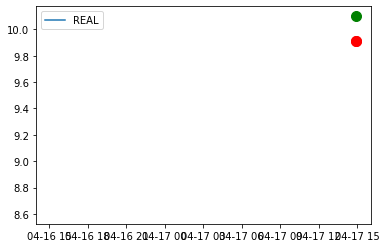

now=2020-04-17 10:47:03.891502
CVI analysis for run 401 with profit 240.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6345.5,-6345.5,buy,2020-04-17 14:47:03.891502,17.15,"[16.38, 16.6474, 16.92, 16.92]",[17.53],370,"{'avg': 16.9966, 'rsi': 59.46136834511414, 'macd': [-0.005507379601358053, 0.0010174699464045034, 0.00930881964968222, 0.015299947540857062, 0.02101607397934302], 'vwap': 17.15, 'sell_macd': [-0.003514873995495549, 0.0008125307822446359, 0.0062519042352597864, 0.010149443234553246, 0.01383389643875077], 'slow macd': [0.04651077028936612, 0.04628182314599982, 0.04663690724457226, 0.04680903874470488, 0.047132444753035685], 'macd_signal': [-0.017654606778847455, -0.013920191433797063, -0.009274389217101206, -0.004359521865509552, 0.0007155973034609622], 'resistances': [17.5], 'sell_macd_signal': [-0.012288832692350826, -0.009668559997431733, -0.006484467150893429, -0.0031576850738040934, 0.00024063122870687965]}",17.93,16.89
1,-3037.7,3307.8,sell,2020-04-17 16:19:53.628180,17.88,None,None,185,"{'avg': 17.1752, 'rsi': 64.24783843478438, 'vwap': 17.8756, 'reasons': 'scale-out', 'movement': 0.02054794520547942, 'sell_macd': [0.024726501822748048, 0.02414551049709246, 0.022859731405709738, 0.021560945991570435, 0.023385776240402834], 'sell_macd_signal': [0.02753660540833335, 0.026858386426085172, 0.026058655422010087, 0.025159113535922158, 0.024804446076818292]}",17.93,16.89
2,240.5,3278.2,sell,2020-04-17 16:28:13.339834,17.72,None,None,185,"{'avg': 17.1889, 'rsi': 41.521158105229745, 'vwap': 17.72, 'reasons': 'below cost & macd negative', 'movement': -0.008948545861297548, 'sell_macd': [0.017767005171442918, 0.011742795856946486, 0.006896102938419801, 0.0025104188078977074, -0.0014590807588419352], 'sell_macd_signal': [0.022432150785301874, 0.020294279799630797, 0.0176146444273886, 0.014593799303490421, 0.01138322329102395]}",17.93,16.89


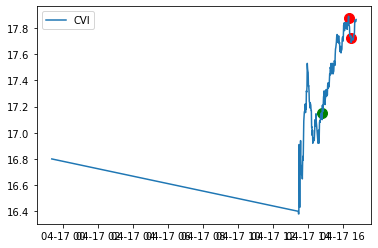

now=2020-04-17 10:03:13.156610
CEIX analysis for run 401 with profit -53.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1254.33,-1254.33,buy,2020-04-17 14:03:13.156610,5.43,"[4.78, 4.795, 4.84]","[5.505, 5.51]",231,"{'avg': 5.179, 'rsi': 72.12361424168986, 'macd': [0.07817509211725682, 0.07598306716348002, 0.07821799841435606, 0.08466168530989293, 0.09353167720457378], 'vwap': 5.44, 'sell_macd': [0.04627122785953208, 0.04468646920618724, 0.046008910915189105, 0.050078230286940695, 0.055715644988475255], 'slow macd': [0.04383538727033365, 0.045256440311905344, 0.047457486808270666, 0.05052617055113462, 0.05422826435766126], 'macd_signal': [0.08505186203022227, 0.08323810305687382, 0.08223408212837027, 0.0827196027646748, 0.0848820176526546], 'resistances': [5.505, 5.54, 5.54, 5.56], 'sell_macd_signal': [0.05181750590852537, 0.05039129856805775, 0.049514821037484016, 0.04962750288737535, 0.05084513130759533]}",6.73,5.01
1,-349.53,904.80,sell,2020-04-17 14:32:09.985897,5.20,None,None,174,"{'avg': 5.2328, 'rsi': 37.32806471952163, 'vwap': 5.21, 'reasons': 'below cost & macd negative', 'movement': -0.04227941176470596, 'sell_macd': [0.013780222268169773, 0.012356716696871217, 0.007450651099795813, 0.0019725395812981716, -0.003360697180925243], 'sell_macd_signal': [0.019566121587153096, 0.01812424060909672, 0.01598952270723654, 0.013186126082048865, 0.009876761429454043]}",6.73,5.01
2,-53.13,296.40,sell,2020-04-17 14:32:10.597935,5.20,None,None,57,"{'avg': 5.2328, 'rsi': 37.32806471952163, 'vwap': 5.21, 'reasons': 'below cost & macd negative', 'movement': -0.04227941176470596, 'sell_macd': [0.013780222268169773, 0.012356716696871217, 0.007450651099795813, 0.0019725395812981716, -0.003360697180925243], 'sell_macd_signal': [0.019566121587153096, 0.01812424060909672, 0.01598952270723654, 0.013186126082048865, 0.009876761429454043]}",6.73,5.01


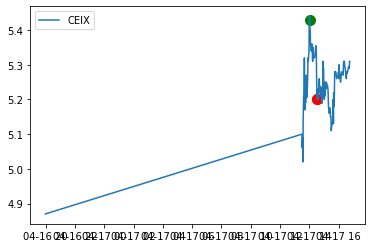

now=2020-04-17 09:55:14.193067
GBX analysis for run 401 with profit -37.68


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2625.04,-2625.04,buy,2020-04-17 13:55:14.193067,16.72,"[15.58, 16.0, 16.05, 16.0902, 16.1]",[16.9],157,"{'avg': 16.3539, 'rsi': 66.74747604490689, 'macd': [0.11657035254863146, 0.11670159861694174, 0.12233489284576393, 0.13269334396127164, 0.15221984162771207], 'vwap': 16.72, 'sell_macd': [0.06306978215848957, 0.06334304875867858, 0.06720087924248119, 0.07411346300592925, 0.08695296382152407], 'slow macd': [0.15181028102662353, 0.15255951619731078, 0.1543802887134902, 0.15727995940716255, 0.16228716549612976], 'macd_signal': [0.13849155981634506, 0.13413356757646439, 0.1317738326303243, 0.13195773489651377, 0.13601015624275342], 'resistances': [16.9], 'sell_macd_signal': [0.07746200789957207, 0.07463821607139337, 0.07315074870561093, 0.0733432915656746, 0.07606522601684448]}",18.61,16.09
1,-37.68,2587.36,sell,2020-04-17 14:20:05.816770,16.48,None,None,157,"{'avg': 16.4693, 'rsi': 45.245211522879266, 'vwap': 16.504, 'reasons': 'below cost & macd negative', 'movement': -0.013277511961722355, 'sell_macd': [0.040566085133328045, 0.025013586105107066, 0.014154319510321756, 0.005430808923343022, -0.000502196844735181], 'sell_macd_signal': [0.06990827383177146, 0.06092933628643858, 0.05157433293121522, 0.04234562812964078, 0.03377606313476559]}",18.61,16.09


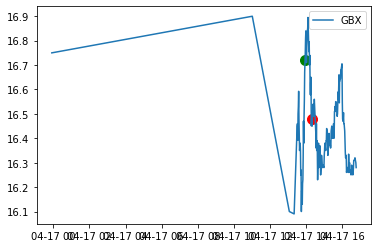

now=2020-04-17 10:40:56.803943
PBA analysis for run 401 with profit -84.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5983.88,-5983.88,buy,2020-04-17 14:40:56.803943,19.88,"[19.43, 19.58, 19.58, 19.61, 19.635]","[20.165, 20.29]",301,"{'avg': 19.687, 'rsi': 67.17350406336926, 'macd': [-0.006996878884084623, -0.0011144948122598919, -0.0004816925359065749, 0.00561160488899759, 0.01988627831433476], 'vwap': 19.8783, 'sell_macd': [-0.005321485522159719, -0.0013844958298783183, -0.0008961337861528307, 0.0031376046087778775, 0.012468600700817234], 'slow macd': [0.03544051269104642, 0.03541829438705335, 0.03454152609635486, 0.03480077841891216, 0.03690127281336686], 'macd_signal': [-0.005462995288274113, -0.004593295193071269, -0.00377097466163833, -0.0018944587515111458, 0.0024616886616580357], 'resistances': [20.165, 20.29], 'sell_macd_signal': [-0.004914304735979457, -0.004208342954759229, -0.003545901121037949, -0.0022091999750747833, 0.0007263601601036201]}",20.84,19.56
1,-84.28,5899.60,sell,2020-04-17 14:49:41.692580,19.60,None,None,301,"{'avg': 19.6942, 'rsi': 39.027205160614805, 'vwap': 19.61, 'reasons': 'below cost & macd negative', 'movement': -0.01358148893360159, 'sell_macd': [0.02426886059686595, 0.020943126182434213, 0.017040695129853844, 0.008064246320962809, -7.408062519687064e-05], 'sell_macd_signal': [0.01688214295115785, 0.017694339597413122, 0.017563610703901267, 0.015663737827313576, 0.012516174136811487]}",20.84,19.56


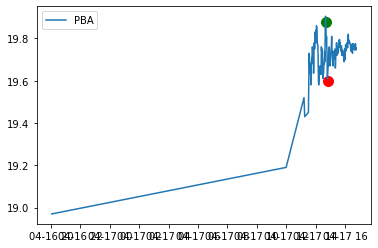

now=2020-04-17 09:57:58.732827
TGI analysis for run 401 with profit -96.57


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1980.99,-1980.99,buy,2020-04-17 13:57:58.732827,7.59,"[6.0, 6.04, 6.08, 6.08, 6.32, 6.335, 6.34, 6.39, 6.44]","[7.5976, 7.8]",261,"{'avg': 6.9563, 'rsi': 70.10839921097158, 'macd': [0.2563563086351852, 0.25398754937798085, 0.2552360992547813, 0.2612828423291429, 0.26942450322980616], 'vwap': 7.6, 'sell_macd': [0.14968261890237056, 0.1478245310640265, 0.14836336481253642, 0.15205124351510868, 0.15710606791302162], 'slow macd': [0.19490100312817837, 0.19920234640089962, 0.204043842396473, 0.20977119422223467, 0.21598452959775916], 'macd_signal': [0.26808538302860063, 0.2652658162984767, 0.2632598728897376, 0.26286446677761865, 0.26417647406805617], 'resistances': [7.8], 'sell_macd_signal': [0.15958047867502825, 0.1572292891528279, 0.1554561042847696, 0.15477513213083743, 0.15524131928727428]}",8.74,7.22
1,-96.57,1884.42,sell,2020-04-17 14:18:58.551230,7.22,None,None,261,"{'avg': 7.1584, 'rsi': 42.8411393932872, 'vwap': 7.2198, 'reasons': 'stopped', 'movement': -0.04999999999999999, 'sell_macd': [0.0430082654580195, 0.034311492163787705, 0.02633593515316779, 0.014194774688358613, 0.00299134088865749], 'sell_macd_signal': [0.0747077535485589, 0.06662850127160466, 0.058569988047917285, 0.04969494537600555, 0.04035422447853594]}",8.74,7.22


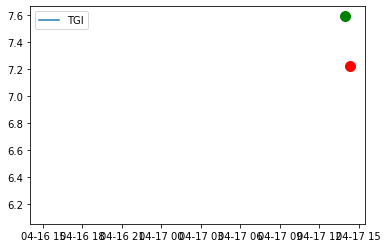

now=2020-04-17 10:55:43.410113
CMO analysis for run 401 with profit 86.94


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4462.92,-4462.92,buy,2020-04-17 14:55:43.410113,4.62,"[4.24, 4.49, 4.49, 4.5, 4.52, 4.53, 4.55]",[4.7],966,"{'avg': 4.5308, 'rsi': 64.73247851331647, 'macd': [0.0062361193466999865, 0.008585937515300124, 0.011126838501920311, 0.01299077131477766, 0.015898516153173503], 'vwap': 4.62, 'sell_macd': [0.003443545077063348, 0.004979578416318908, 0.00663129818176067, 0.007832231788834854, 0.009705267952933916], 'slow macd': [0.019810138048528714, 0.019974666801554797, 0.020254027854536005, 0.020478655472085272, 0.02097243936896387], 'macd_signal': [0.007820347524525682, 0.00797346552268057, 0.008604140118528518, 0.009481466357778346, 0.010764876316857377], 'resistances': [4.7], 'sell_macd_signal': [0.004455993925823837, 0.004560710823922851, 0.004974828295490415, 0.005546308994159302, 0.0063781007859142255]}",4.92,4.52
1,86.94,4549.86,sell,2020-04-17 15:23:14.522268,4.71,None,None,966,"{'avg': 4.56, 'rsi': 71.67735910879121, 'vwap': 4.713, 'reasons': 'bail', 'movement': 0.021645021645021568, 'sell_macd': [0.017026207956035933, 0.017421137956553423, 0.017242886814664793, 0.016880056225989648, 0.017157330361748713], 'sell_macd_signal': [0.016734107363102085, 0.016871513481792354, 0.016945788148366843, 0.016932641763891403, 0.016977579483462867]}",4.92,4.52


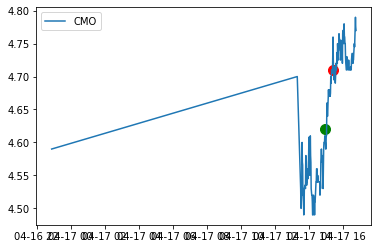

now=2020-04-17 10:57:20.863302
DXC analysis for run 401 with profit -27.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3436.2,-3436.2,buy,2020-04-17 14:57:20.863302,14.94,"[14.35, 14.54, 14.54, 14.63]",[15.145],230,"{'avg': 14.6309, 'rsi': 68.76832906797193, 'macd': [0.022159689424880114, 0.025326451585090837, 0.03390067890052606, 0.0394343250433824, 0.04887254552518172], 'vwap': 14.9498, 'sell_macd': [0.014786299679121484, 0.01673745665639359, 0.022196313305482107, 0.025642223508597795, 0.03160991686805481], 'slow macd': [0.05905308501094453, 0.05870962163433724, 0.05957921471066285, 0.060124043503059, 0.061642298152115416], 'macd_signal': [0.0069544770830948874, 0.010628871983494078, 0.015283233366900476, 0.02011345170219686, 0.025865270466793832], 'resistances': [15.145], 'sell_macd_signal': [0.0048656687198692546, 0.007240026307174121, 0.01023128370683572, 0.013313471667188135, 0.01697276070736147]}",16.21,14.53
1,-27.6,3408.6,sell,2020-04-17 15:44:53.671508,14.82,None,None,230,"{'avg': 14.6889, 'rsi': 37.29613213214205, 'vwap': 14.84, 'reasons': 'below cost & macd negative', 'movement': -0.0073312998341092984, 'sell_macd': [0.009677996057906313, 0.009873268362060372, 0.009897204334620824, 0.005631476464738938, -0.00036300598536165296], 'sell_macd_signal': [0.008219494856180948, 0.008550249557356834, 0.008819640512809632, 0.008182007703195493, 0.0064730049654840634]}",16.21,14.53


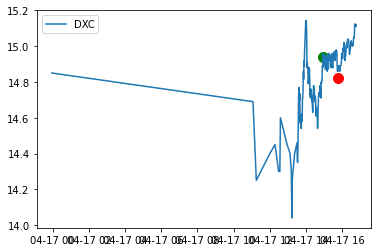

now=2020-04-17 10:01:19.106085
SLB analysis for run 401 with profit -46.55


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1446.85,-1446.85,buy,2020-04-17 14:01:19.106085,15.23,"[14.245, 14.33]","[15.47, 15.65, 15.65, 15.65, 15.65, 15.66, 15.66]",95,"{'avg': 14.6651, 'rsi': 74.04894820002572, 'macd': [0.16919645848773257, 0.18311896118577486, 0.19792298510947504, 0.20926034875215294, 0.22134221087958217], 'vwap': 15.2214, 'sell_macd': [0.10432507527304935, 0.11293665852939405, 0.12207637718979925, 0.12891152968894914, 0.13619981047154717], 'slow macd': [0.08295434465630791, 0.08978593226673404, 0.09712713153203723, 0.1041257684705954, 0.11151775588432677], 'macd_signal': [0.12144868599672012, 0.13378274103453108, 0.14661078984951986, 0.15914070163004648, 0.17158100347995361], 'resistances': [15.47, 15.65, 15.65, 15.65, 15.65, 15.66, 15.66, 15.66, 15.66, 15.66, 15.66, 15.66, 15.6698, 15.67, 15.67, 15.67], 'sell_macd_signal': [0.07427376611976803, 0.08200634460169323, 0.09002035111931443, 0.09779858683324137, 0.10547883156090253]}",18.37,14.19
1,-46.55,1400.30,sell,2020-04-17 14:16:10.758004,14.74,None,None,95,"{'avg': 14.75, 'rsi': 41.938890270127025, 'vwap': 14.75, 'reasons': 'below cost & macd negative', 'movement': -0.03151674326986214, 'sell_macd': [0.04411938435429619, 0.02986006020284826, 0.018361105536747857, 0.009229957673074551, -0.00015054660606139691], 'sell_macd_signal': [0.07976111661398701, 0.06978090533175926, 0.05949694537275698, 0.0494435478328205, 0.03952472894504412]}",18.37,14.19


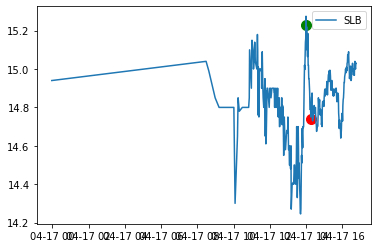

now=2020-04-17 09:58:35.878882
CNQ analysis for run 401 with profit -24.48


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1815.84,-1815.84,buy,2020-04-17 13:58:35.878882,12.61,[11.99],[12.9],144,"{'avg': 12.3773, 'rsi': 66.20217760634277, 'macd': [0.11784379386980426, 0.1189302623613866, 0.11762843269112899, 0.11925658969943242, 0.12146262052132784], 'vwap': 12.6187, 'sell_macd': [0.07276063867656468, 0.07307288308036419, 0.07184771140695645, 0.07255734761719701, 0.07365891677300418], 'slow macd': [0.04160315225279021, 0.045104946679419555, 0.048094634479882714, 0.051568002369105415, 0.0551401525104982], 'macd_signal': [0.10560762126344866, 0.10827214948303625, 0.1101434061246548, 0.11196604283961033, 0.11386535837595382], 'resistances': [12.9], 'sell_macd_signal': [0.06644125914719838, 0.06776758393383155, 0.06858360942845652, 0.06937835706620463, 0.07023446900756454]}",14.68,11.93
1,-24.48,1791.36,sell,2020-04-17 14:15:05.754801,12.44,None,None,144,"{'avg': 12.4698, 'rsi': 42.12340606093971, 'vwap': 12.41, 'reasons': 'below cost & macd negative', 'movement': -0.01653894616719633, 'sell_macd': [0.03424649491982201, 0.024695926214096886, 0.014595535973088047, 0.005756328824601198, -0.000686642055061526], 'sell_macd_signal': [0.05010500360854638, 0.045023188129656486, 0.0389376576983428, 0.03230139192359448, 0.025703785127863275]}",14.68,11.93


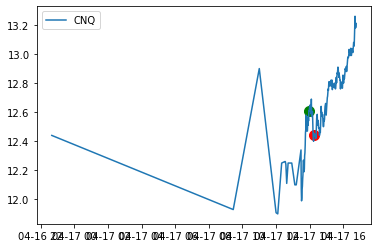

now=2020-04-17 09:52:39.788999
HCC analysis for run 401 with profit -56.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2421.98,-2421.98,buy,2020-04-17 13:52:39.788999,11.99,"[11.3, 11.595, 11.6]","[12.81, 12.81, 12.81]",202,"{'avg': 11.6172, 'rsi': 68.08445725148954, 'macd': [0.08169695544344968, 0.08853883956541075, 0.09687890445224134, 0.10390455181996217, 0.11540436611866056], 'vwap': 11.9991, 'sell_macd': [0.0498472950804274, 0.05409027824985202, 0.05929143035265305, 0.06361321860999603, 0.0708300248026017], 'slow macd': [0.06436541722183442, 0.06703947269202182, 0.07019214911990446, 0.07330032179646473, 0.0774821306895408], 'macd_signal': [0.07163211702957242, 0.07501346153674009, 0.07938655011984033, 0.0842901504598647, 0.09051299359162387], 'resistances': [12.81, 12.81, 12.81, 12.89], 'sell_macd_signal': [0.043918270783537765, 0.04595267227680062, 0.048620423891971104, 0.05161898283557609, 0.05546119122898121]}",13.47,11.51
1,-56.56,2365.42,sell,2020-04-17 14:16:08.745834,11.71,None,None,202,"{'avg': 11.7396, 'rsi': 39.84381078174343, 'vwap': 11.7434, 'reasons': 'below cost & macd negative', 'movement': -0.020000000000000018, 'sell_macd': [0.02606932183512889, 0.022301643719570663, 0.016478756308492493, 0.0075715874646853365, -0.0015453179650961602], 'sell_macd_signal': [0.04523395565907277, 0.04064749327117235, 0.03581374587863638, 0.03016531419584617, 0.023823187763657706]}",13.47,11.51


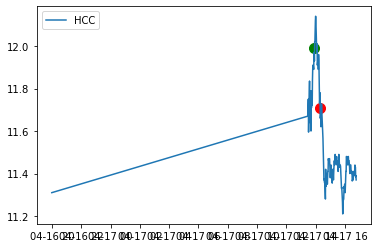

now=2020-04-17 09:58:30.448723
RF analysis for run 401 with profit -59.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3567.96,-3567.96,buy,2020-04-17 13:58:30.448723,9.54,"[9.01, 9.33]",[9.54],374,"{'avg': 9.252, 'rsi': 64.08020584768173, 'macd': [0.07857833956315297, 0.07775633457885256, 0.08699543227401385, 0.0936415010406062, 0.09538823296838395], 'vwap': 9.5422, 'sell_macd': [0.044486239178961995, 0.04391905092601611, 0.0499196957818242, 0.054206955464508155, 0.055285249302125195], 'slow macd': [0.07184668605916755, 0.0729048389945941, 0.07592090878605262, 0.0786543325985285, 0.08056356525031383], 'macd_signal': [0.09504829642874457, 0.09158990405876617, 0.09067100970181571, 0.09126510796957381, 0.09208973296933584], 'resistances': [9.65, 9.7, 9.95, 10.13, 10.13, 10.1499], 'sell_macd_signal': [0.05599724341153622, 0.053581604914432195, 0.052849223087910596, 0.05312076956323011, 0.053553665511009124]}",10.34,9.28
1,-59.84,3508.12,sell,2020-04-17 14:15:50.625506,9.38,None,None,374,"{'avg': 9.3452, 'rsi': 38.60781483824483, 'vwap': 9.38, 'reasons': 'below cost & macd negative', 'movement': -0.017286537454164395, 'sell_macd': [0.03172653117535695, 0.02210416727608333, 0.014662011415921938, 0.007810175532473096, -0.00022775081219528204], 'sell_macd_signal': [0.048376815919648986, 0.04312228619093585, 0.03743023123593307, 0.03150622009524108, 0.025159425913753808]}",10.34,9.28


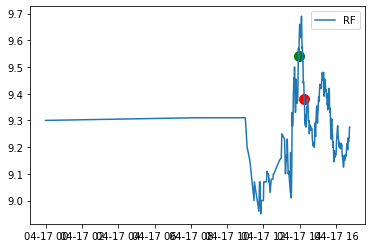

now=2020-04-17 10:03:18.191202
GLNG analysis for run 401 with profit -56.64


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2177.10,-2177.10,buy,2020-04-17 14:03:18.191202,6.15,"[5.46, 5.85, 5.88]",None,354,"{'avg': 5.9588, 'rsi': 74.08532158261193, 'macd': [0.06255114897215286, 0.06266697323645243, 0.06363900679695611, 0.06774371677402247, 0.07170331898655125], 'vwap': 6.15, 'sell_macd': [0.03676297645193749, 0.03677151069850382, 0.03733956971273056, 0.03994663427300171, 0.042446338680057316], 'slow macd': [0.046800984939566526, 0.04799238694985153, 0.049331629843839764, 0.051300550827322766, 0.05333385149892855], 'macd_signal': [0.05682927598532646, 0.05799681543555165, 0.059125253707832545, 0.06084894632107053, 0.06301982085416667], 'resistances': [6.56], 'sell_macd_signal': [0.03330675173352859, 0.033999703526523636, 0.03466767676376502, 0.03572346826561236, 0.03706804234850135]}",6.99,5.87
1,-56.64,2120.46,sell,2020-04-17 14:19:10.001054,5.99,None,None,354,"{'avg': 5.9736, 'rsi': 44.17865462337222, 'vwap': 5.9966, 'reasons': 'below cost & macd negative', 'movement': -0.026016260162601647, 'sell_macd': [0.012334132403037934, 0.0083373654960619, 0.004704334588079284, 0.001812306158638144, -0.00046475893129915846], 'sell_macd_signal': [0.02384131573825888, 0.020740525689819482, 0.017533287469471442, 0.014389091207304782, 0.011418321179583994]}",6.99,5.87


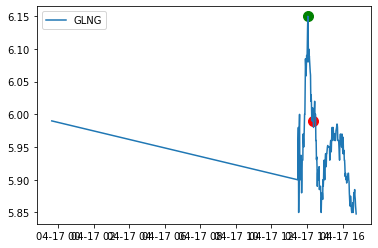

now=2020-04-17 10:45:46.020619
VST analysis for run 401 with profit -56.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9627.66,-9627.66,buy,2020-04-17 14:45:46.020619,17.01,"[16.1, 16.75, 16.82, 16.85, 17.0]",[17.19],566,"{'avg': 16.9012, 'rsi': 62.48961671403017, 'macd': [0.00857940148305758, 0.01013299054637784, 0.013627876672380523, 0.0170084526779668, 0.021856385985159932], 'vwap': 17.0086, 'sell_macd': [0.0049301703046680245, 0.0059668924486402375, 0.008255677334219058, 0.010451410006950823, 0.013585079492109742], 'slow macd': [0.05572358475395944, 0.05478104864730682, 0.05430607872487414, 0.053942172244902054, 0.05400090175333716], 'macd_signal': [0.003007785527183308, 0.004432826531022215, 0.006271836559293876, 0.00841915978302846, 0.011106605023454754], 'resistances': [17.19], 'sell_macd_signal': [0.0008592413134449102, 0.0018807715404839758, 0.003155752699230992, 0.004614884160774958, 0.006408923227041915]}",17.52,16.84
1,-56.60,9571.06,sell,2020-04-17 15:03:07.874089,16.91,None,None,566,"{'avg': 16.9137, 'rsi': 44.1495955227991, 'vwap': 16.925, 'reasons': 'below cost & macd negative', 'movement': -0.004997060552616158, 'sell_macd': [0.009624064370125751, 0.007179830638598617, 0.004662507852494002, 0.0016014445405616584, -0.0005448573199124951], 'sell_macd_signal': [0.012873713826094143, 0.011734937188595038, 0.01032045132137483, 0.008576649965212197, 0.006752348508187259]}",17.52,16.84


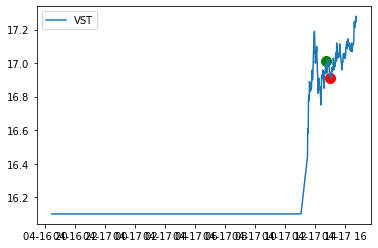

now=2020-04-17 09:52:42.584806
INSE analysis for run 401 with profit -84.46


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-638.60,-638.60,buy,2020-04-17 13:52:42.584806,3.10,"[2.63, 2.6633, 2.8, 2.83]","[3.15, 3.15, 3.15, 3.15, 3.2, 3.23]",206,"{'avg': 3.0186, 'rsi': 70.80505751215487, 'macd': [0.16869221165685833, 0.1807287468087191, 0.19129037694982154, 0.19459318829171313, 0.20174390158474242], 'vwap': 3.1002, 'sell_macd': [0.10060309134965939, 0.1080895411638525, 0.11459730022473202, 0.11636182286665475, 0.12064116748546905], 'slow macd': [0.09731717887296432, 0.10361271915727333, 0.10987884763290978, 0.11490837431500012, 0.12071137607358828], 'macd_signal': [0.16933828830184078, 0.17161638000321644, 0.17555117939253745, 0.17935958117237258, 0.18383644525484655], 'resistances': [3.15, 3.15, 3.15, 3.15, 3.2, 3.23], 'sell_macd_signal': [0.10301265809136398, 0.10402803470586168, 0.10614188780963575, 0.10818587482103956, 0.11067693335392545]}",4.54,2.62
1,-84.46,554.14,sell,2020-04-17 14:13:07.489766,2.69,None,None,206,"{'avg': 2.9674, 'rsi': 39.67369502896367, 'vwap': 2.695, 'reasons': 'below cost & macd negative', 'movement': -0.13064516129032266, 'sell_macd': [0.022716364419561152, 0.023266364001762962, 0.017075891416442612, 0.006497914188706488, -0.001751131887304691], 'sell_macd_signal': [0.03990715743085782, 0.03657899874503885, 0.032678377279319604, 0.02744228466119698, 0.021603601351496644]}",4.54,2.62


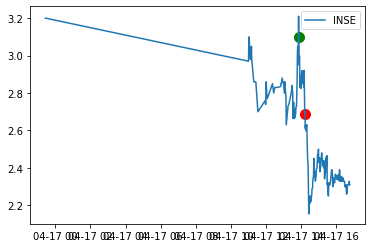

now=2020-04-17 10:00:40.447126
SIX analysis for run 401 with profit -46.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2304.66,-2304.66,buy,2020-04-17 14:00:40.447126,16.23,"[15.47, 15.58, 15.7925]",[16.26],142,"{'avg': 15.9697, 'rsi': 60.13797799347077, 'macd': [0.1644871167836559, 0.1663097178235855, 0.16983101815032775, 0.17464307945304114, 0.1851979072035661], 'vwap': 16.2647, 'sell_macd': [0.09376801763167286, 0.09496947139628276, 0.0972697019739499, 0.10039624915169121, 0.10724295800250516], 'slow macd': [0.16159913120743674, 0.16413642059708522, 0.1670079748566593, 0.1701824708390074, 0.1745902218873976], 'macd_signal': [0.16025010923893976, 0.16146203095586892, 0.16313582839476068, 0.16543727860641677, 0.16938940432584665], 'resistances': [16.7, 16.7, 16.7, 16.72, 16.93, 16.95, 16.95, 16.99], 'sell_macd_signal': [0.09119607754882025, 0.09195075631831276, 0.09301454544944018, 0.09449088618989039, 0.09704130055241335]}",18.36,15.56
1,-46.86,2257.80,sell,2020-04-17 14:16:07.679539,15.90,None,None,142,"{'avg': 16.0257, 'rsi': 43.281355218941734, 'vwap': 15.9087, 'reasons': 'below cost & macd negative', 'movement': -0.021525215252152608, 'sell_macd': [0.044799779023641406, 0.025297199515197377, 0.019901719385043037, 0.008685738512390628, -0.0001667886417848763], 'sell_macd_signal': [0.07844192773573307, 0.06781298209162592, 0.05823072955030935, 0.048321731342725605, 0.03862402734582351]}",18.36,15.56


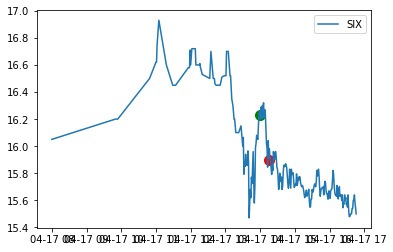

now=2020-04-17 10:05:21.620554
JCAP analysis for run 401 with profit -46.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1987.44,-1987.44,buy,2020-04-17 14:05:21.620554,12.74,"[11.78, 11.8, 11.81, 11.9, 11.92]",[12.81],156,"{'avg': 12.3764, 'rsi': 75.8804414746895, 'macd': [0.1691158260881629, 0.17460184858503425, 0.17930341209585876, 0.18333679191663776, 0.18600298075723032], 'vwap': 12.75, 'sell_macd': [0.10488608572715385, 0.1079258019459104, 0.11045121975343442, 0.11254308791834333, 0.11375047755439915], 'slow macd': [0.07590016948988776, 0.08121087580923536, 0.08644681812734056, 0.09160560101476634, 0.09652520797994235], 'macd_signal': [0.13114090627000002, 0.13983309473300687, 0.14772715820557725, 0.15484908494778934, 0.16107986410967753], 'resistances': [13.06, 13.06], 'sell_macd_signal': [0.08175799754259998, 0.08699155842326206, 0.09168349068929653, 0.09585541013510589, 0.09943442361896454]}",14.66,12.11
1,-46.80,1940.64,sell,2020-04-17 14:36:11.628605,12.44,None,None,156,"{'avg': 12.4646, 'rsi': 47.43190873990637, 'vwap': 12.45, 'reasons': 'below cost & macd negative', 'movement': -0.023529411764705938, 'sell_macd': [0.01758560863457248, 0.010229203180703195, 0.005403053435081517, 0.002611208783493524, -0.0006371274227241486], 'sell_macd_signal': [0.04587175854916643, 0.03874324747547379, 0.032075208667395334, 0.026182408690614972, 0.02081850146794715]}",14.66,12.11


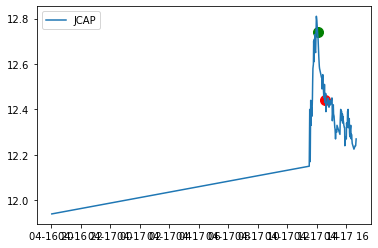

now=2020-04-17 10:01:44.826805
WKHS analysis for run 401 with profit -45.01


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1427.46,-1427.46,buy,2020-04-17 14:01:44.826805,2.22,"[2.01, 2.0101, 2.0101, 2.03, 2.03, 2.03, 2.04, 2.04, 2.05, 2.055, 2.09, 2.11, 2.12, 2.1399]","[2.24, 2.2499]",643,"{'avg': 2.1405, 'rsi': 76.24283896933963, 'macd': [0.01364057892777426, 0.015363835796328829, 0.018134320969170226, 0.022092572076448214, 0.027311229529997316], 'vwap': 2.2247, 'sell_macd': [0.008025236103362587, 0.00913612893865956, 0.010922069733194206, 0.013470568147984974, 0.016824325767977655], 'slow macd': [0.012902923962518464, 0.01342509576619122, 0.01420391101496632, 0.015297568849181431, 0.016754312712088826], 'macd_signal': [0.011460301633862479, 0.012241008466355749, 0.013419670966918644, 0.015154251188824557, 0.017585646857059108], 'resistances': [2.2499], 'sell_macd_signal': [0.006607221916600408, 0.007113003321012239, 0.007874816603448633, 0.008993966912355902, 0.010560038683480252]}",2.69,2.07
1,-45.01,1382.45,sell,2020-04-17 14:26:06.854006,2.15,None,None,643,"{'avg': 2.1537, 'rsi': 48.50844561783526, 'vwap': 2.155, 'reasons': 'below cost & macd negative', 'movement': -0.03133006697532256, 'sell_macd': [0.0014180277836288724, 0.0011036677585849475, 0.0008443785473999377, 0.00011708333677029614, -0.0001966153122499037], 'sell_macd_signal': [0.004389188351067751, 0.0037320842325711903, 0.0031545430955369396, 0.0025470511437836107, 0.001998317852576908]}",2.69,2.07


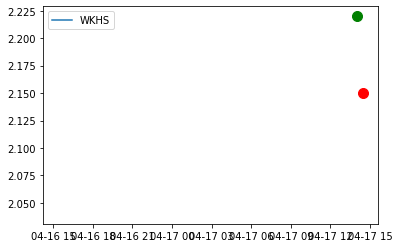

now=2020-04-17 10:29:32.379478
APA analysis for run 401 with profit -43.2


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3768.0,-3768.0,buy,2020-04-17 14:29:32.379478,7.85,"[7.6405, 7.71]",[7.95],480,"{'avg': 7.7172, 'rsi': 58.6384656314599, 'macd': [-0.004064721426557227, 0.00219501188961857, 0.00827092816993158, 0.01094270385200069, 0.013485631194339653], 'vwap': 7.8572, 'sell_macd': [-0.0041558530527439075, 8.440251835040158e-05, 0.00416662241117205, 0.005994759698939589, 0.007715454212799067], 'slow macd': [0.02914094346785756, 0.029524160165282254, 0.03006941605497193, 0.030123137021766944, 0.030239538219890782], 'macd_signal': [-0.009236321046658755, -0.00695005445940329, -0.0039058579335363164, -0.0009361455764289148, 0.0019482097777247988], 'resistances': [7.95], 'sell_macd_signal': [-0.008446749513864807, -0.0067405191074217646, -0.004559090803703002, -0.0024483207031744834, -0.00041556571997977297]}",8.46,7.66
1,-43.2,3724.8,sell,2020-04-17 14:33:32.688514,7.76,None,None,480,"{'avg': 7.7189, 'rsi': 42.892225337813464, 'vwap': 7.7608, 'reasons': 'below cost & macd negative', 'movement': -0.012370819121315475, 'sell_macd': [0.00630246719981109, 0.00594090853555862, 0.004023578296718178, 0.002477300470391519, -0.00031820563415418945], 'sell_macd_signal': [-0.0006981631225773683, 0.0006296512090498295, 0.0013084366265834991, 0.0015422093953451031, 0.0011701263894452446]}",8.46,7.66


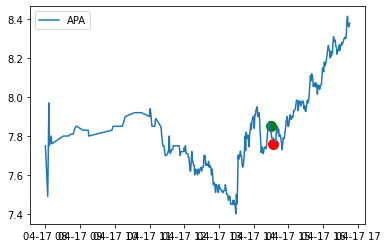

now=2020-04-17 10:04:41.925629
PUMP analysis for run 401 with profit -42.48


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2166.48,-2166.48,buy,2020-04-17 14:04:41.925629,3.06,"[2.83, 2.92]",[3.64],708,"{'avg': 2.9506, 'rsi': 64.1574233457541, 'macd': [0.028931795669401517, 0.029667517207385696, 0.03190014784589312, 0.033285825436223604, 0.03598644662025752], 'vwap': 3.0436, 'sell_macd': [0.017360010012175575, 0.017766239274366935, 0.019150752475108668, 0.01998088285912658, 0.021666947017333626], 'slow macd': [0.012695870309490598, 0.01361355424756061, 0.014835919911099005, 0.01593680744095005, 0.01732401055027566], 'macd_signal': [0.02989646623526248, 0.029850676429687122, 0.03026057071292832, 0.030865621657587376, 0.031889786650121404], 'resistances': [3.64], 'sell_macd_signal': [0.01843695287826775, 0.018302810157487588, 0.018472398621011805, 0.01877409546863476, 0.019352665778374533]}",3.48,2.92
1,-42.48,2124.00,sell,2020-04-17 14:32:48.529519,3.00,None,None,708,"{'avg': 2.9688, 'rsi': 45.519201093258225, 'vwap': 3.0, 'reasons': 'below cost & macd negative', 'movement': -0.01960784313725492, 'sell_macd': [0.004163353778740664, 0.003499303013953181, 0.002494856924327049, 0.0010823683230039016, -3.2328877027421044e-05], 'sell_macd_signal': [0.004807852350522744, 0.004546142483208832, 0.004135885371432476, 0.003525181961746761, 0.0028136797939919246]}",3.48,2.92


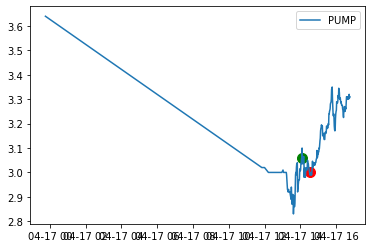

now=2020-04-17 10:07:06.899255
PE analysis for run 401 with profit -48.99


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1429.23,-1429.23,buy,2020-04-17 14:07:06.899255,6.71,[6.27],"[6.72, 6.72, 6.75, 6.75, 6.8, 6.81, 6.9, 6.9]",213,"{'avg': 6.4658, 'rsi': 71.02703121143932, 'macd': [0.07419358911519325, 0.07371280509299805, 0.07169836968993337, 0.07450417249733299, 0.07583744623535527], 'vwap': 6.7132, 'sell_macd': [0.04464837464781901, 0.04416968779445174, 0.04270357222306931, 0.04439356564506891, 0.04512351421227567], 'slow macd': [0.04335625100290308, 0.04491893182123796, 0.04612487058001591, 0.04820338541473301, 0.05003539224920939], 'macd_signal': [0.06899208358406501, 0.06993622788585162, 0.07028865624666797, 0.07113175949680098, 0.07207289684451183], 'resistances': [6.8], 'sell_macd_signal': [0.04198725542318941, 0.04242374189744187, 0.04247970796256736, 0.04286247949906767, 0.04331468644170927]}",8.11,6.25
1,-48.99,1380.24,sell,2020-04-17 14:17:07.006052,6.48,None,None,213,"{'avg': 6.4939, 'rsi': 39.33404885452374, 'vwap': 6.495, 'reasons': 'below cost & macd negative', 'movement': -0.032762472077438536, 'sell_macd': [0.020532725784085493, 0.013789007467238434, 0.006796642448042789, 0.0010000379857082464, -0.0035297841665746787], 'sell_macd_signal': [0.03363501909951687, 0.029665816773061182, 0.025091981908057504, 0.020273593123587653, 0.015512917665555187]}",8.11,6.25


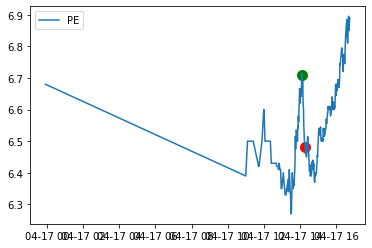

now=2020-04-17 09:59:10.324745
NVT analysis for run 401 with profit -42.48


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3162.99,-3162.99,buy,2020-04-17 13:59:10.324745,17.87,"[16.73, 17.35]","[18.21, 18.235, 18.27]",177,"{'avg': 17.5065, 'rsi': 73.52665588055758, 'macd': [0.16705165024038848, 0.1669603199273304, 0.17136784951194173, 0.17765445702681504, 0.1852778166806175], 'vwap': 17.8792, 'sell_macd': [0.09704974729079652, 0.09680989832536824, 0.09952157577665233, 0.10345896631302409, 0.10825876457106531], 'slow macd': [0.13780531752203729, 0.14063034165996768, 0.1442840238569829, 0.14837438236953915, 0.1528471602215653], 'macd_signal': [0.17934839112923354, 0.17687077688885292, 0.17577019141347067, 0.17614704453613955, 0.17797319896503513], 'resistances': [18.15, 18.1625, 18.21, 18.235, 18.27], 'sell_macd_signal': [0.10649245912153094, 0.10455594696229839, 0.10354907272516918, 0.10353105144274016, 0.10447659406840519]}",19.56,17.32
1,-42.48,3120.51,sell,2020-04-17 14:20:17.754686,17.63,None,None,177,"{'avg': 17.6484, 'rsi': 43.48257980144795, 'vwap': 17.6528, 'reasons': 'below cost & macd negative', 'movement': -0.012539710949035736, 'sell_macd': [0.041471844766096666, 0.02416905714854778, 0.011930923197880361, 0.004317689948035053, -0.002449994271945144], 'sell_macd_signal': [0.06674021713662007, 0.05822598513900561, 0.04896697275078056, 0.04003711619023146, 0.03153969409779614]}",19.56,17.32


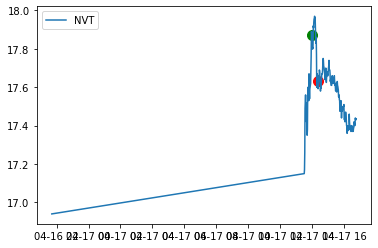

now=2020-04-17 10:10:07.310877
USAC analysis for run 401 with profit -34.41


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-758.88,-758.88,buy,2020-04-17 14:10:07.310877,8.16,"[6.45, 6.48, 6.77, 6.78, 6.78, 6.81, 6.82, 6.82, 6.822, 6.83, 6.8301, 6.87, 6.88, 6.9428, 6.944, 7.0492, 7.09, 7.0901, 7.1]",[8.22],93,"{'avg': 7.5799, 'rsi': 77.77738139640395, 'macd': [0.1562260044103132, 0.15519006707479743, 0.15260988748629067, 0.17357060276610614, 0.19280910501933946], 'vwap': 8.3017, 'sell_macd': [0.08972282135265708, 0.08897768092429992, 0.0872414977213678, 0.10085432252789683, 0.11327400000664767], 'slow macd': [0.14519335837100122, 0.14724817548198033, 0.1489031700723178, 0.155144085654916, 0.16159901184961267], 'macd_signal': [0.16352460049996576, 0.1618576938149321, 0.16000813254920382, 0.1627206265925843, 0.16873832227793534], 'resistances': [8.54, 8.66, 8.66, 8.7, 8.75, 8.75], 'sell_macd_signal': [0.09521306550146222, 0.09396598858602975, 0.09262109041309737, 0.09426773683605726, 0.09806898947017534]}",11.53,7.29
1,-34.41,724.47,sell,2020-04-17 14:29:31.560263,7.79,None,None,93,"{'avg': 7.648, 'rsi': 45.206866171511635, 'vwap': 7.82, 'reasons': 'below cost & macd negative', 'movement': -0.0634730538922155, 'sell_macd': [0.012400013354622708, 0.01083621075212804, 0.006967842350806386, 0.0024760248647011096, -0.0013159890837544097], 'sell_macd_signal': [0.02877923231562347, 0.025190628002924383, 0.021546070872500784, 0.01773206167094085, 0.013922451520001797]}",11.53,7.29


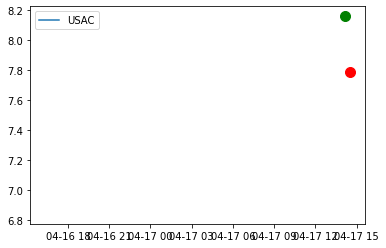

now=2020-04-17 09:53:37.491072
SBGI analysis for run 401 with profit -35.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1960.44,-1960.44,buy,2020-04-17 13:53:37.491072,15.81,"[14.5, 15.24]","[16.24, 16.3, 16.3, 16.35, 16.38, 16.41]",124,"{'avg': 15.378, 'rsi': 67.85770889612664, 'macd': [0.28166832770780914, 0.2795929334541487, 0.27637610965479453, 0.279082289189148, 0.28161183396177236], 'vwap': 15.87, 'sell_macd': [0.1696529358228407, 0.16766194445359162, 0.16497205579633878, 0.1661880898842405, 0.16731502436982204], 'slow macd': [0.16954736664866665, 0.1752688814945298, 0.18057241213601394, 0.1868423579007139, 0.1930317924360878], 'macd_signal': [0.26009497674220877, 0.26399456808459676, 0.2664708763986363, 0.26899315895673864, 0.27151689395774536], 'resistances': [16.3, 16.3, 16.35, 16.38], 'sell_macd_signal': [0.15846886632453938, 0.16030748195034983, 0.16124039671954762, 0.1622299353524862, 0.16324695315595336]}",18.25,15.08
1,-35.96,1924.48,sell,2020-04-17 14:17:58.718919,15.52,None,None,124,"{'avg': 15.5222, 'rsi': 44.55062604797519, 'vwap': 15.5422, 'reasons': 'below cost & macd negative', 'movement': -0.02079395085066163, 'sell_macd': [0.023097608858732244, 0.01826711820332605, 0.010110020053616608, 0.005700462793404526, -0.0009264709521268344], 'sell_macd_signal': [0.052000937066713084, 0.04525417329403568, 0.038225342645951864, 0.031720366675442396, 0.02519099914992855]}",18.25,15.08


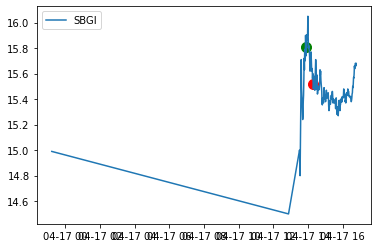

now=2020-04-17 09:52:50.911762
ATI analysis for run 401 with profit -54.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2493.0,-2493.0,buy,2020-04-17 13:52:50.911762,8.31,[7.95],[8.45],300,"{'avg': 8.11, 'rsi': 63.28401229246181, 'macd': [0.10962247551449256, 0.10991292867486102, 0.1104833642999381, 0.11405868150705167, 0.11994750631026463], 'vwap': 8.3023, 'sell_macd': [0.0641697667006138, 0.06421292460753492, 0.06445158109854354, 0.06665765653181666, 0.07036813535603237], 'slow macd': [0.08966460615208849, 0.09156705413457455, 0.0934907904765021, 0.09599081213218774, 0.09901703627501224], 'macd_signal': [0.11410929031082576, 0.11327001798363281, 0.11271268724689387, 0.11298188609892543, 0.11437501014119326], 'resistances': [8.45], 'sell_macd_signal': [0.06809364821872746, 0.06731750349648895, 0.06674431901689987, 0.06672698651988322, 0.06745521628711305]}",9.3,7.98
1,-54.0,2439.0,sell,2020-04-17 14:15:07.880248,8.13,None,None,300,"{'avg': 8.1596, 'rsi': 41.142805839630014, 'vwap': 8.1237, 'reasons': 'below cost & macd negative', 'movement': -0.02166064981949455, 'sell_macd': [0.02503707898218721, 0.01883232571737281, 0.011155474787422293, 0.002950714649962549, -0.002441964868188151], 'sell_macd_signal': [0.03882443155295245, 0.03482601038583652, 0.030091903266153675, 0.02466366554291545, 0.01924253946069473]}",9.3,7.98


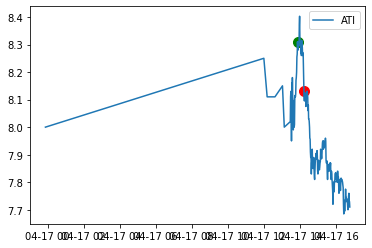

now=2020-04-17 10:07:43.922787
NESR analysis for run 401 with profit -116.74


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4085.90,-4085.90,buy,2020-04-17 14:07:43.922787,4.55,"[4.18, 4.18, 4.19, 4.19, 4.2, 4.21, 4.215, 4.25, 4.45]","[4.56, 4.59, 4.59, 4.595, 4.65, 4.7, 4.705]",898,"{'avg': 4.4254, 'rsi': 71.48161928526152, 'macd': [0.05531495790771501, 0.058588568796265506, 0.06208112924973008, 0.06490770932865875, 0.06797801897079747], 'vwap': 4.55, 'sell_macd': [0.034301038149242125, 0.03626247576701758, 0.03835888851116653, 0.04001377001944917, 0.041822589765911466], 'slow macd': [0.02677021236102295, 0.028745285865380055, 0.030836314649891783, 0.03287074566730919, 0.03500978716607328], 'macd_signal': [0.04226294169481041, 0.04552806711510143, 0.048838679542027155, 0.05205248549935347, 0.05523759219364227], 'resistances': [4.65], 'sell_macd_signal': [0.026261617297643067, 0.028261788991517968, 0.03028120889544768, 0.03222772112024798, 0.034146694849380675]}",4.88,4.44
1,-116.74,3969.16,sell,2020-04-17 14:39:32.648162,4.42,None,None,898,"{'avg': 4.437, 'rsi': 47.00461416926485, 'vwap': 4.42, 'reasons': 'stopped', 'movement': -0.02857142857142855, 'sell_macd': [0.028718172339570636, 0.025000648987985485, 0.021779193792101026, 0.018986122291513752, 0.014485207845712722], 'sell_macd_signal': [0.03424336750176916, 0.03239482379901242, 0.030271697797630143, 0.028014582696406866, 0.02530870772626804]}",4.88,4.44


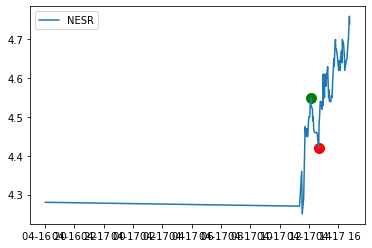

now=2020-04-17 10:03:07.633973
CLR analysis for run 401 with profit -38.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1057.3,-1057.3,buy,2020-04-17 14:03:07.633973,10.9,"[10.0, 10.2536]","[10.9, 11.13, 11.49, 11.5, 11.5, 11.5, 11.6, 11.65, 11.65, 11.65, 11.65]",97,"{'avg': 10.3833, 'rsi': 75.04602378164029, 'macd': [0.15160047582129188, 0.15612096297450329, 0.15389489492674002, 0.162362848508387, 0.16794471700103664], 'vwap': 10.902, 'sell_macd': [0.0910422728149971, 0.09369453923044624, 0.09194702553819134, 0.09718341713464085, 0.10052108049376152], 'slow macd': [0.08658549566678886, 0.09094194750477058, 0.09400489348205099, 0.09907159444958147, 0.10373460626425057], 'macd_signal': [0.12999189353496757, 0.1352177074228747, 0.13895314492364777, 0.14363508564059563, 0.14849701191268383], 'resistances': [11.13], 'sell_macd_signal': [0.07804893646266513, 0.08117805701622136, 0.08333185072061536, 0.08610216400342045, 0.08898594730148866]}",13.97,9.89
1,-38.8,1018.5,sell,2020-04-17 14:16:24.632536,10.5,None,None,97,"{'avg': 10.4778, 'rsi': 41.004877956801025, 'vwap': 10.5122, 'reasons': 'below cost & macd negative', 'movement': -0.037580201649862525, 'sell_macd': [0.04851829500618976, 0.03112647545502334, 0.018209129370282184, 0.008270819052688339, -0.0009833294941739013], 'sell_macd_signal': [0.07195681627636286, 0.06379074811209495, 0.0546744243637324, 0.045393703301523584, 0.036118296742384086]}",13.97,9.89


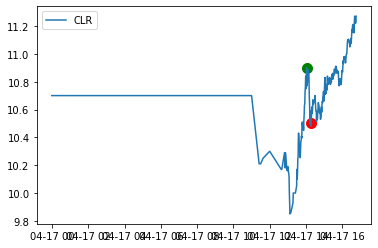

now=2020-04-17 09:56:32.094116
AMSC analysis for run 401 with profit -72.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1710.0,-1710.0,buy,2020-04-17 13:56:32.094116,5.70,"[5.13, 5.15, 5.18, 5.18, 5.19, 5.225, 5.23, 5.32, 5.35, 5.3801]","[5.84, 5.89, 5.89]",300,"{'avg': 5.51, 'rsi': 70.25615053192625, 'macd': [0.05832239483379542, 0.06198032742053705, 0.0649376212999444, 0.07209860515076194, 0.08007830924868742], 'vwap': 5.7, 'sell_macd': [0.03524798544934438, 0.03750509782940892, 0.039296288023883186, 0.043818042876409, 0.04885034480206052], 'slow macd': [0.037731646744249225, 0.0396517777344263, 0.041514878213217976, 0.04428214518196949, 0.04739704030966596], 'macd_signal': [0.04928530033465866, 0.05182430575183434, 0.05444696886145635, 0.05797729611931747, 0.06239749874519146], 'resistances': [5.84, 5.88, 5.89, 5.89, 5.89], 'sell_macd_signal': [0.02976685288631116, 0.03131450187493071, 0.032910859104721205, 0.035092295859058764, 0.03784390564765912]}",6.69,5.37
1,-72.0,1638.0,sell,2020-04-17 14:33:23.547977,5.46,None,None,300,"{'avg': 5.597, 'rsi': 39.41486805843238, 'vwap': 5.49, 'reasons': 'below cost & macd negative', 'movement': -0.036842105263157884, 'sell_macd': [0.01416768919447442, 0.011142100108653352, 0.006042393027382076, 0.0014706421455157326, -0.0036693019461395693], 'sell_macd_signal': [0.025185896878405636, 0.02237713752445518, 0.019110188625040558, 0.015582279329135593, 0.011731963074080561]}",6.69,5.37


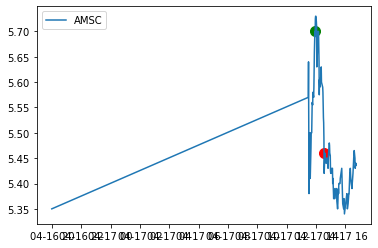

now=2020-04-17 10:04:49.608531
WW analysis for run 401 with profit -67.1


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2459.52,-2459.52,buy,2020-04-17 14:04:49.608531,20.16,"[18.44, 18.5, 18.56, 18.5681, 18.79, 18.82, 18.9, 18.92, 18.94, 18.975, 19.0301, 19.08, 19.09, 19.32]",[20.4998],122,"{'avg': 19.573, 'rsi': 76.5159677092852, 'macd': [0.14616223125969086, 0.15695004022910197, 0.17079291004583297, 0.1804898261695307, 0.19879379377448458], 'vwap': 20.1533, 'sell_macd': [0.0794567986663921, 0.08676656636811941, 0.09601097540364378, 0.10248699575075904, 0.11451393373876328], 'slow macd': [0.1870822131578187, 0.19022067092983974, 0.1942433453199648, 0.19779360537210167, 0.20330259136109774], 'macd_signal': [0.15218027727821254, 0.15313422986839043, 0.15666596590387893, 0.1614307379570093, 0.16890334912050436], 'resistances': [20.4998, 20.75, 20.75, 20.79, 20.99, 21.22], 'sell_macd_signal': [0.08257788988729489, 0.0834156251834598, 0.0859346952274966, 0.08924515533214908, 0.09429891101347192]}",22.59,19.35
1,-67.10,2392.42,sell,2020-04-17 14:33:09.992853,19.61,None,None,122,"{'avg': 19.6304, 'rsi': 38.50585437471917, 'vwap': 19.612, 'reasons': 'below cost & macd negative', 'movement': -0.027182539682539773, 'sell_macd': [0.01802819342950812, 0.013687757762909314, 0.009608356493313153, 0.0005905326924136034, -0.007379077187408711], 'sell_macd_signal': [0.014948980649070704, 0.014696736071838426, 0.013679060156133372, 0.011061354663389419, 0.0073732682932297925]}",22.59,19.35


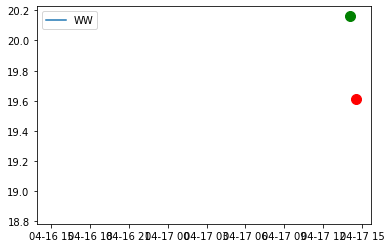

now=2020-04-17 10:30:19.233948
OSW analysis for run 401 with profit -84.84


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2514.90,-2514.90,buy,2020-04-17 14:30:19.233948,4.15,"[3.8, 3.8, 3.8001, 3.85, 3.89, 3.97]","[4.3, 4.3, 4.3, 4.3]",606,"{'avg': 3.9821, 'rsi': 70.73489387960234, 'macd': [0.024662164215195403, 0.027122804418056035, 0.027943843842883176, 0.030661822379794756, 0.03643047425481338], 'vwap': 4.1351, 'sell_macd': [0.013348569353172302, 0.014977317882447494, 0.01553248143925412, 0.017321797438853537, 0.02108851383543975], 'slow macd': [0.03057113010342105, 0.03126845870964834, 0.03170007777725736, 0.03252628935800894, 0.03403408931397722], 'macd_signal': [0.034186089074806636, 0.032773432143456516, 0.03180751448334185, 0.03157837606263243, 0.032548795701068625], 'resistances': [4.3, 4.3, 4.3, 4.3], 'sell_macd_signal': [0.019694409963993728, 0.018750991547684483, 0.01810728952599841, 0.017950191108569435, 0.018577855653943497]}",4.63,3.99
1,-84.84,2430.06,sell,2020-04-17 14:47:11.610902,4.01,None,None,606,"{'avg': 3.9914, 'rsi': 45.62269666225936, 'vwap': 4.01, 'reasons': 'below cost & macd negative', 'movement': -0.03373493975903628, 'sell_macd': [0.004046103279583768, 0.004165136705718275, 0.0038661350026316654, 0.0013231968573350628, -0.0006754977605236689], 'sell_macd_signal': [0.01169499672651533, 0.01018902472235592, 0.008924446778411069, 0.007404196794195868, 0.005788257883251961]}",4.63,3.99


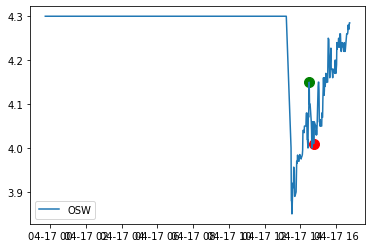

now=2020-04-17 09:57:23.358483
TV analysis for run 401 with profit -92.04


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4056.84,-4056.84,buy,2020-04-17 13:57:23.358483,5.73,"[5.39, 5.5401, 5.61]",[5.94],708,"{'avg': 5.6282, 'rsi': 76.11184575297023, 'macd': [0.05290181083577661, 0.05054206836634911, 0.049712730894674095, 0.05168732141236809, 0.055038498354579524], 'vwap': 5.73, 'sell_macd': [0.031625645978058614, 0.02997037882789577, 0.029330295609224954, 0.030528538612738743, 0.03262420149063505], 'slow macd': [0.031507576222017164, 0.032217011498196335, 0.03313806008855824, 0.034572198659557074, 0.03631616669523474], 'macd_signal': [0.053999043064835196, 0.05330764812513798, 0.0525886646790452, 0.05240839602570978, 0.05293441649148373], 'resistances': [5.9, 5.94], 'sell_macd_signal': [0.033008870052936894, 0.03240117180792867, 0.031786996568187925, 0.03153530497709809, 0.031753084279805485]}",6.15,5.59
1,-92.04,3964.80,sell,2020-04-17 14:16:22.650468,5.60,None,None,708,"{'avg': 5.6467, 'rsi': 45.06418578330975, 'vwap': 5.6, 'reasons': 'below cost & macd negative', 'movement': -0.022687609075043764, 'sell_macd': [0.006589376008728998, 0.004484908021074929, 0.002267336757694416, 0.0010293937374274975, -0.000468086456772987], 'sell_macd_signal': [0.012219001726914546, 0.010672182985746622, 0.008991213740136181, 0.007398849739594445, 0.005825462500320958]}",6.15,5.59


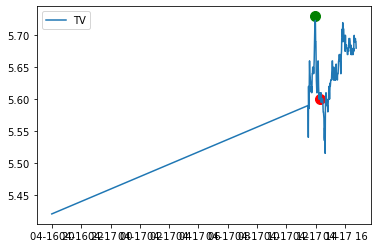

now=2020-04-17 10:00:49.763337
TGH analysis for run 401 with profit 29.7


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1979.1,-1979.1,buy,2020-04-17 14:00:49.763337,7.33,"[6.83, 6.83, 6.85, 6.87]",[7.4],270,"{'avg': 7.0959, 'rsi': 75.41931128910106, 'macd': [0.09167980424529354, 0.09355072541508491, 0.1019276496886814, 0.10732919833963273, 0.11113577693123666], 'vwap': 7.35, 'sell_macd': [0.057576583054943065, 0.058456955392279575, 0.06357858376692693, 0.06674376712682228, 0.06886282211989947], 'slow macd': [0.019154111799678297, 0.022397815736352022, 0.026945665194705093, 0.03108673634340242, 0.035006871396492834], 'macd_signal': [0.06878510840578725, 0.07373823180764678, 0.07937611538385371, 0.08496673197500951, 0.09020054096625493], 'resistances': [7.55, 7.59], 'sell_macd_signal': [0.043704247188343905, 0.04665478882913104, 0.05003954781669022, 0.05338039167871663, 0.0564768777669532]}",8.45,6.98
1,29.7,2008.8,sell,2020-04-17 14:04:59.317187,7.44,None,None,270,"{'avg': 7.1446, 'rsi': 78.83604930422094, 'vwap': 7.4509, 'reasons': 'rsi max', 'movement': 0.014965986394557868, 'sell_macd': [0.06886282211989947, 0.06858075039866218, 0.07058717827303962, 0.07175339248329404, 0.0748471517057876], 'sell_macd_signal': [0.0564768777669532, 0.058897652293294994, 0.06123555748924392, 0.06333912448805394, 0.06564072993160067]}",8.45,6.98


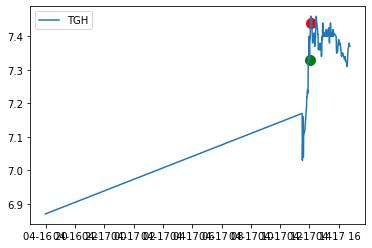

now=2020-04-17 09:58:53.435228
FTAI analysis for run 401 with profit -53.73


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1984.03,-1984.03,buy,2020-04-17 13:58:53.435228,9.97,"[9.14, 9.1415, 9.15, 9.16, 9.18, 9.5, 9.55]",[10.23],199,"{'avg': 9.677, 'rsi': 72.34699725591315, 'macd': [0.11129224406424854, 0.11399356816967376, 0.11640635978310243, 0.11816673657672006, 0.12817082965916526], 'vwap': 9.97, 'sell_macd': [0.06616033747511807, 0.06773067913579389, 0.06911366381767436, 0.07007295494878107, 0.07640392264900875], 'slow macd': [0.07854218739099394, 0.0812348137405916, 0.08390206443050197, 0.08646173479425912, 0.09067763026320286], 'macd_signal': [0.10375561055847227, 0.10580320208071256, 0.10792383362119054, 0.10997241421229645, 0.11361209730167021], 'resistances': [10.23], 'sell_macd_signal': [0.06215517549212633, 0.06327027622085984, 0.06443895374022275, 0.06556575398193441, 0.06773338771534929]}",11.47,9.47
1,-53.73,1930.30,sell,2020-04-17 14:32:39.745425,9.70,None,None,199,"{'avg': 9.7182, 'rsi': 48.448333781592574, 'vwap': 9.7212, 'reasons': 'below cost & macd negative', 'movement': -0.026078234704112312, 'sell_macd': [0.0033510758166421795, 0.0017989487470515542, 0.0005661361116935382, 0.000637111511263555, -0.00035481819701033146], 'sell_macd_signal': [0.008641360099052958, 0.0072728778286526765, 0.0059315294852608485, 0.00487264589046139, 0.0038271530729670454]}",11.47,9.47


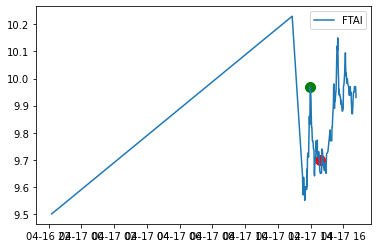

now=2020-04-17 09:52:52.344001
SXC analysis for run 401 with profit -57.82


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2709.28,-2709.28,buy,2020-04-17 13:52:52.344001,3.28,"[3.07, 3.17, 3.17]",[3.38],826,"{'avg': 3.2519, 'rsi': 64.93748852331174, 'macd': [0.02939278768271736, 0.031303656967056614, 0.03244403994519063, 0.03376549054121902, 0.03521374396498844], 'vwap': 3.28, 'sell_macd': [0.017724237512605878, 0.018904341474582864, 0.01957839207515466, 0.02036884199670208, 0.021239727104444217], 'slow macd': [0.018434151847027014, 0.019436019053511, 0.020326683734000817, 0.021273550065416647, 0.02227060933304026], 'macd_signal': [0.026073642117134272, 0.02711964508711874, 0.028184524058733118, 0.0293007173552303, 0.03048332267718193], 'resistances': [3.38], 'sell_macd_signal': [0.015811257419719907, 0.016429874230692497, 0.01705957779958493, 0.01772143063900836, 0.01842508993209553]}",3.64,3.16
1,-57.82,2651.46,sell,2020-04-17 14:11:18.630966,3.21,None,None,826,"{'avg': 3.2641, 'rsi': 41.85960597492092, 'vwap': 3.22, 'reasons': 'below cost & macd negative', 'movement': -0.01829268292682915, 'sell_macd': [0.004969819381606122, 0.003424265094933432, 0.0024352063638253263, 0.0008536644127823401, -0.0009092730089754752], 'sell_macd_signal': [0.01293734024333935, 0.011034725213658166, 0.009314821443691598, 0.0076225900375097464, 0.005916217428212702]}",3.64,3.16


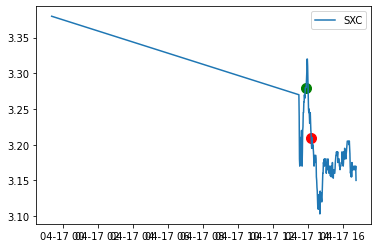

now=2020-04-17 09:52:50.589389
NCR analysis for run 401 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2563.27,-2563.27,buy,2020-04-17 13:52:50.589389,18.71,"[17.58, 17.85]","[18.96, 19.12]",137,"{'avg': 18.0942, 'rsi': 75.00501787591703, 'macd': [0.18909064887002813, 0.19640545772175955, 0.20497169875691412, 0.20866124146244047, 0.21914551291021667], 'vwap': 18.71, 'sell_macd': [0.11320206300830193, 0.11761521722657875, 0.12283046444566992, 0.12485233936384788, 0.1312998738538056], 'slow macd': [0.1312607517241524, 0.13639305536786495, 0.14191399037894215, 0.14662891061043837, 0.15273147590841063], 'macd_signal': [0.16780528779036152, 0.17352532177664112, 0.1798145971726957, 0.18558392603064466, 0.19229624340655907], 'resistances': [18.96, 19.045, 19.12], 'sell_macd_signal': [0.10068588213454918, 0.1040717491529551, 0.10782349221149806, 0.11122926164196803, 0.11524338408433554]}",20.87,17.99
1,0.00,2563.27,sell,2020-04-17 14:35:09.850329,18.71,None,None,137,"{'avg': 18.4856, 'rsi': 37.89183494825186, 'vwap': 18.71, 'reasons': 'below cost & macd negative', 'movement': 0.0, 'sell_macd': [0.026488254606565675, 0.01451652528632863, 0.0049993787343751706, -0.0035204676533098223, -0.011152549674189771], 'sell_macd_signal': [0.04024165113107481, 0.03509662596212557, 0.029077176516575494, 0.02255764768259843, 0.01581560821124079]}",20.87,17.99


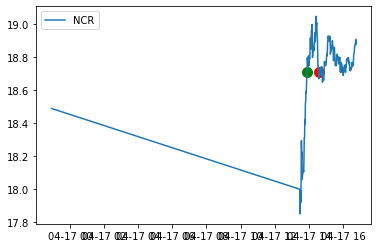

now=2020-04-17 10:01:11.354190
TRGP analysis for run 401 with profit -90.74


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2854.82,-2854.82,buy,2020-04-17 14:01:11.354190,8.18,"[7.525, 7.54, 7.62, 7.68, 7.9, 7.905, 7.93, 7.98, 7.985]",[8.2],349,"{'avg': 7.9595, 'rsi': 67.17479399557008, 'macd': [0.048220386387194836, 0.0509644927510573, 0.05891540807600837, 0.06846196101634305, 0.07595898157055014], 'vwap': 8.18, 'sell_macd': [0.027643370519387034, 0.02939839956305068, 0.03454000142093161, 0.04069527557744923, 0.04548256354905522], 'slow macd': [0.040307423527027986, 0.041689521605614566, 0.04417390768814311, 0.04718865248828141, 0.050046778507939926], 'macd_signal': [0.05413736987933699, 0.05350279445368105, 0.05458531717814651, 0.05736064594578582, 0.06108031307073868], 'resistances': [8.27, 8.33], 'sell_macd_signal': [0.0319077504370542, 0.031405880262253494, 0.032032704493989116, 0.03376521871068114, 0.036108687678355955]}",9.03,7.9
1,-90.74,2764.08,sell,2020-04-17 14:13:06.165893,7.92,None,None,349,"{'avg': 7.9787, 'rsi': 40.26364905820064, 'vwap': 7.92, 'reasons': 'below cost & macd negative', 'movement': -0.031784841075794594, 'sell_macd': [0.023079743629097038, 0.016857310228807876, 0.011270254199637009, 0.003913194252236352, -0.002130140697065741], 'sell_macd_signal': [0.034160956966949416, 0.03070022761932111, 0.026814232935384288, 0.0222340251987547, 0.01736119201959061]}",9.03,7.9


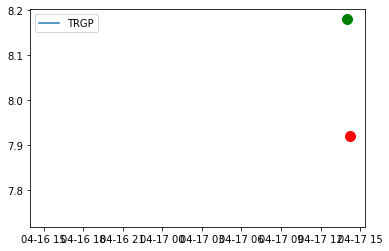

now=2020-04-17 09:52:46.181133
HI analysis for run 401 with profit -51.33


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3447.96,-3447.96,buy,2020-04-17 13:52:46.181133,19.48,"[17.76, 17.77, 18.94]","[19.79, 19.79, 19.79, 20.0, 20.0]",177,"{'avg': 18.7968, 'rsi': 75.15521451683014, 'macd': [0.28988511323766275, 0.2935746697210604, 0.30029925477533226, 0.30214559058964596, 0.3081261033719187], 'vwap': 19.4484, 'sell_macd': [0.17238681653302734, 0.17419902474955862, 0.1780241347267335, 0.17869273815405506, 0.18208784812139456], 'slow macd': [0.193756154932057, 0.20044025896054407, 0.2077086965190027, 0.21406369053577023, 0.22116748360672034], 'macd_signal': [0.3010745131124112, 0.299574544434141, 0.29971948650237923, 0.30020470731983256, 0.30178898653024977], 'resistances': [19.77, 19.79, 19.79, 19.79, 20.0, 20.0], 'sell_macd_signal': [0.1831050370788362, 0.18132383461298068, 0.18066389463573124, 0.180269663339396, 0.18063330029579572]}",21.16,18.92
1,-51.33,3396.63,sell,2020-04-17 14:15:14.667860,19.19,None,None,177,"{'avg': 18.9691, 'rsi': 44.685222479790184, 'vwap': 19.1654, 'reasons': 'below cost & macd negative', 'movement': -0.016940451745379972, 'sell_macd': [0.033110351595624365, 0.026324358446384366, 0.01564534614247748, 0.0035987736181013474, -0.005055682551777352], 'sell_macd_signal': [0.07927859226825729, 0.06868774550388271, 0.058079265631601665, 0.047183167228901604, 0.03673539727276581]}",21.16,18.92


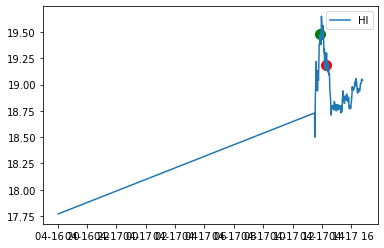

now=2020-04-17 10:53:59.242344
MTDR analysis for run 401 with profit -19.25


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6179.25,-6179.25,buy,2020-04-17 14:53:59.242344,3.21,"[2.91, 3.065, 3.15, 3.17, 3.185]","[3.21, 3.29]",1925,"{'avg': 3.1312, 'rsi': 61.7482309451716, 'macd': [0.00212150365153585, 0.002700421801530073, 0.004423501015326181, 0.005324221185504463, 0.006368099140082961], 'vwap': 3.214, 'sell_macd': [0.0012033559364033053, 0.0015801960971484341, 0.0027000690003635697, 0.003277891145721412, 0.003945312412938939], 'slow macd': [0.01090975515798176, 0.010799887373358352, 0.010942228308219448, 0.010975717943518593, 0.011068943364969552], 'macd_signal': [0.0027402514285507404, 0.002732285503146607, 0.003070528605582522, 0.00352126712156691, 0.004090633525270121], 'resistances': [3.29, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3], 'sell_macd_signal': [0.0015978832421093586, 0.0015943458131171737, 0.001815490450566453, 0.002107970589597445, 0.0024754389542657436]}",3.36,3.17
1,-19.25,6160.00,sell,2020-04-17 15:22:11.965711,3.20,None,None,1925,"{'avg': 3.1387, 'rsi': 39.905161945031686, 'vwap': 3.2008, 'reasons': 'below cost & macd negative', 'movement': -0.004665629860031005, 'sell_macd': [0.002499070918756896, 0.001938432997129258, 0.0014763978244696219, 0.0010816120038978916, -0.00026343684335161655], 'sell_macd_signal': [0.003032402503872836, 0.0028136086025241204, 0.0025461664469132207, 0.002253255558310155, 0.0017499170779778006]}",3.36,3.17


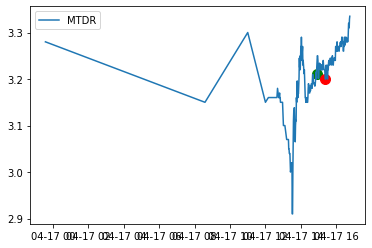

now=2020-04-17 10:47:58.653593
BTU analysis for run 401 with profit -44.22


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1423.08,-1423.08,buy,2020-04-17 14:47:58.653593,3.54,"[3.2001, 3.2638, 3.33, 3.41, 3.4201]",[3.6339],402,"{'avg': 3.4333, 'rsi': 71.41720449891348, 'macd': [-0.02659973807176197, -0.02174184486281483, -0.013699428874462516, -0.006045690662796144, 0.005970721789794631], 'vwap': 3.5265, 'sell_macd': [-0.016581439882754623, -0.013286115972013235, -0.007948381548422478, -0.0029066614579824623, 0.004935025124931602], 'slow macd': [0.012312167776843186, 0.01193406564657895, 0.012366792849967556, 0.012985040800226333, 0.014726203683210759], 'macd_signal': [-0.0315193525350893, -0.029563851000634404, -0.026390966575400028, -0.02232191139287925, -0.016663384756344473], 'resistances': [3.6339], 'sell_macd_signal': [-0.020649464715869717, -0.01917679496709842, -0.01693111228336323, -0.014126222118287077, -0.010313972669643342]}",4.28,3.32
1,-44.22,1378.86,sell,2020-04-17 15:04:11.836532,3.43,None,None,402,"{'avg': 3.4372, 'rsi': 43.38019068933268, 'vwap': 3.43, 'reasons': 'below cost & macd negative', 'movement': -0.03640858523429597, 'sell_macd': [0.005929506091256531, 0.0034643800438161065, 0.001560848317968766, 5.730608590592823e-05, -0.0016345100181158756], 'sell_macd_signal': [0.010194069301000133, 0.008848131449563328, 0.007390674823244415, 0.005924001075776718, 0.004412298856998199]}",4.28,3.32


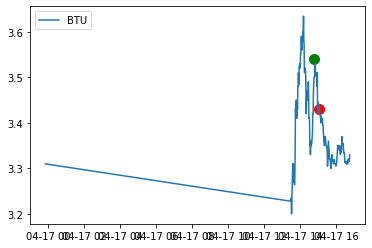

now=2020-04-17 10:03:22.960362
STXS analysis for run 401 with profit -122.36


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1984.36,-1984.36,buy,2020-04-17 14:03:22.960362,3.73,"[3.4, 3.4, 3.4, 3.4, 3.41, 3.415, 3.42, 3.5, 3.6, 3.626]",[3.78],532,"{'avg': 3.6069, 'rsi': 65.42708749726081, 'macd': [0.05654544229280134, 0.05926354284415902, 0.05782999150583068, 0.06212643998428158, 0.06558233050176554], 'vwap': 3.73, 'sell_macd': [0.035024643501250896, 0.03660775687510309, 0.0354854068173891, 0.03810844045011397, 0.04017692846976795], 'slow macd': [0.02353119428272743, 0.02553832139953327, 0.026765129160498002, 0.029069736973907467, 0.03130349292383139], 'macd_signal': [0.04742749921253474, 0.049794707938859595, 0.05140176465225381, 0.053546699718659364, 0.0559538258752806], 'resistances': [3.78], 'sell_macd_signal': [0.029765011789771506, 0.031133560806837823, 0.03200393000894808, 0.03322483209718126, 0.034615251371698595]}",4.29,3.54
1,-122.36,1862.00,sell,2020-04-17 14:27:10.490788,3.50,None,None,532,"{'avg': 3.6211, 'rsi': 38.94850047574718, 'vwap': 3.56, 'reasons': 'below cost & macd negative', 'movement': -0.045576407506702395, 'sell_macd': [0.018593978197813055, 0.015934508376521883, 0.01365525256283373, 0.0054681018955076155, -0.0004630298179351122], 'sell_macd_signal': [0.02540323171874657, 0.023509487050301633, 0.021538640152808052, 0.018324532501347964, 0.014567020037491349]}",4.29,3.54


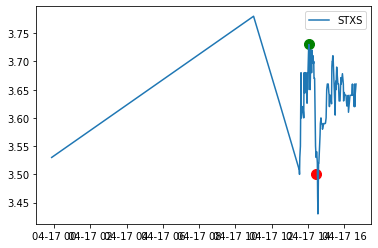

now=2020-04-17 10:34:22.075454
RCKT analysis for run 401 with profit -28.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5761.98,-5761.98,buy,2020-04-17 14:34:22.075454,16.14,"[15.43, 15.46, 15.51, 15.52, 15.52, 15.53, 15.54, 15.8, 15.96, 15.96, 15.98, 16.0]","[16.14, 16.145]",357,"{'avg': 15.826, 'rsi': 66.74020413268352, 'macd': [0.03168235128665131, 0.028098658330074855, 0.03533310221503427, 0.03741555138741148, 0.04978880300238053], 'vwap': 16.0986, 'sell_macd': [0.015700148812610948, 0.013538926078368263, 0.01842707815456457, 0.01992398784829419, 0.028104385170053092], 'slow macd': [0.08393235744246041, 0.08229906735061654, 0.08274233133672837, 0.08237966884440517, 0.08415335734092011], 'macd_signal': [0.03835208756384714, 0.03630140171709269, 0.036107741816681006, 0.0363693037308271, 0.03905320358513779], 'resistances': [16.8], 'sell_macd_signal': [0.019328900280420985, 0.01817090544001044, 0.018222139982921264, 0.018562509555995848, 0.020470884678807297]}",16.96,15.88
1,-28.56,5733.42,sell,2020-04-17 15:19:42.609961,16.06,None,None,357,"{'avg': 15.8937, 'rsi': 48.27041928930436, 'vwap': 16.04, 'reasons': 'below cost & macd negative', 'movement': -0.006811145510835879, 'sell_macd': [0.011596803423390867, 0.007886612591526898, 0.003334689701873117, 0.0013028707008189144, -0.0002972852831319983], 'sell_macd_signal': [0.018459905385483453, 0.016345246826692143, 0.013743135401728338, 0.011255082461546453, 0.008944608912610763]}",16.96,15.88


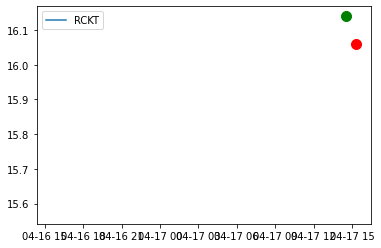

now=2020-04-17 10:18:16.698312
RM analysis for run 401 with profit -131.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2916.88,-2916.88,buy,2020-04-17 14:18:16.698312,14.44,"[12.79, 12.8168, 12.9006, 12.92, 12.9296, 12.97, 12.98, 12.985, 12.99, 12.995, 13.0, 13.0, 13.13, 13.17, 13.2422, 13.465, 13.52, 13.53, 13.6401, 14.0]",[15.1535],202,"{'avg': 13.8547, 'rsi': 73.9846284842418, 'macd': [0.2586085921820658, 0.24881814118439394, 0.26224364947756484, 0.2762990346134959, 0.29040055818593835], 'vwap': 14.4444, 'sell_macd': [0.15741217848032285, 0.1503218399348274, 0.15842908470541772, 0.16693824836165128, 0.17546307395921446], 'slow macd': [0.11901692517593077, 0.12363617395910786, 0.13248637258136142, 0.14172522165752355, 0.15124928836588758], 'macd_signal': [0.23731988362578044, 0.23961953513750314, 0.24414435800551548, 0.2505752933271116, 0.25854034629887696], 'resistances': [14.8, 15.1535], 'sell_macd_signal': [0.14677211841256904, 0.14748206271702072, 0.1496714671147001, 0.15312482336409033, 0.15759247348311517]}",15.9,13.98
1,-131.30,2785.58,sell,2020-04-17 14:49:50.582161,13.79,None,None,202,"{'avg': 13.8842, 'rsi': 44.13651428377487, 'vwap': 13.855, 'reasons': 'stopped', 'movement': -0.04218533886583687, 'sell_macd': [0.11399193918894568, 0.10420426187736176, 0.09256445797382362, 0.07715987755582177, 0.05532306323587477], 'sell_macd_signal': [0.13656797971220963, 0.13009523614524005, 0.12258908051095677, 0.11350323991992976, 0.10186720458311876]}",15.9,13.98


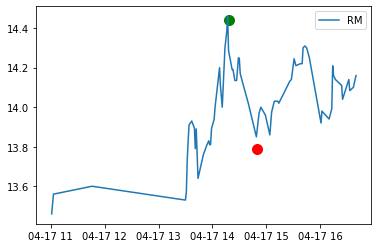

now=2020-04-17 09:57:03.475131
CHEF analysis for run 401 with profit -44.66


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2031.26,-2031.26,buy,2020-04-17 13:57:03.475131,13.19,"[12.5392, 12.63, 13.1]","[13.35, 13.51, 13.98]",154,"{'avg': 13.0028, 'rsi': 56.32036583684099, 'macd': [0.1724426306168496, 0.17338772239508238, 0.1750240453279428, 0.18008698728015027, 0.18625325818538307], 'vwap': 13.1639, 'sell_macd': [0.09945076124156138, 0.09993744523322334, 0.10088892048343823, 0.1040811230097951, 0.10798568182241297], 'slow macd': [0.14535985001906937, 0.14843873355346915, 0.15160976757123734, 0.1554426784887113, 0.159572929311242], 'macd_signal': [0.18297471776591484, 0.18105731869174835, 0.17985066401898725, 0.17989792867121984, 0.1811689945740525], 'resistances': [13.35, 13.5, 13.5, 13.5, 13.51, 13.51, 13.75, 13.98, 14.25, 15.0, 16.0], 'sell_macd_signal': [0.10763002898855685, 0.10609151223749015, 0.10505099388667977, 0.10485701971130283, 0.10548275213352486]}",15.12,12.55
1,-44.66,1986.60,sell,2020-04-17 14:18:34.627144,12.90,None,None,154,"{'avg': 13.0393, 'rsi': 38.306848242053945, 'vwap': 12.91, 'reasons': 'below cost & macd negative', 'movement': -0.021354336438821436, 'sell_macd': [0.03570885152658576, 0.023979036549201638, 0.013488543884367488, 0.005138958121063908, -0.004031354916849139], 'sell_macd_signal': [0.07008634040261044, 0.06086487963192868, 0.05138961248241644, 0.04213948161014593, 0.03290531430474692]}",15.12,12.55


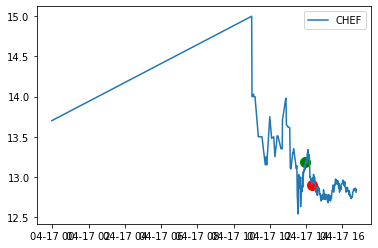

now=2020-04-17 10:07:00.399650
AQUA analysis for run 401 with profit -31.14


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2581.16,-2581.16,buy,2020-04-17 14:07:00.399650,14.92,"[14.31, 14.36]",[14.93],173,"{'avg': 14.5634, 'rsi': 74.34235199551918, 'macd': [0.11842447389327226, 0.1313866681288971, 0.15121304061402796, 0.16502329779623537, 0.17476041327749492], 'vwap': 14.94, 'sell_macd': [0.06206010651188798, 0.07080014967019821, 0.08396381771991912, 0.09313078220385762, 0.09958386125363106], 'slow macd': [0.16923620773773784, 0.17229166914743743, 0.1770663392902314, 0.18117599568423692, 0.18482718136191423], 'macd_signal': [0.1556542003398509, 0.15080069389766013, 0.1508831632409337, 0.15371119015199403, 0.1579210347770942], 'resistances': [15.19, 15.19, 15.6], 'sell_macd_signal': [0.08634161491748744, 0.08323332186802959, 0.0833794210384075, 0.08532969327149752, 0.08818052686792423]}",16.65,14.37
1,-31.14,2550.02,sell,2020-04-17 14:38:50.701023,14.74,None,None,173,"{'avg': 14.706, 'rsi': 40.09919345855542, 'vwap': 14.76, 'reasons': 'below cost & macd negative', 'movement': -0.012048192771084319, 'sell_macd': [0.02609174519130164, 0.023051728128383076, 0.013630263817947963, 0.006631327162830658, -0.00046695240171246155], 'sell_macd_signal': [0.03611656015776804, 0.03350359375189105, 0.02952892776510243, 0.024949407644648074, 0.019866135635375967]}",16.65,14.37


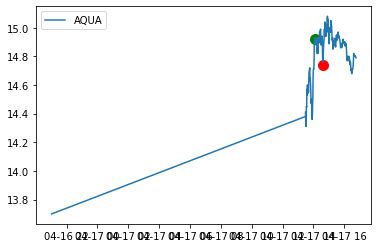

now=2020-04-17 09:56:55.839337
USX analysis for run 401 with profit -57.86


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1983.02,-1983.02,buy,2020-04-17 13:56:55.839337,3.77,"[3.37, 3.37, 3.38, 3.4, 3.449, 3.45, 3.52, 3.53, 3.685]",[3.84],526,"{'avg': 3.6673, 'rsi': 74.10581611121876, 'macd': [0.0382649014671288, 0.04500865534015075, 0.04937246643337101, 0.05263559516528593, 0.05618778325820761], 'vwap': 3.77, 'sell_macd': [0.0240983784880493, 0.0283712639930922, 0.031067392126981286, 0.03302973363225936, 0.035168834368420665], 'slow macd': [0.021738472832874223, 0.0238792243951389, 0.02572902545359179, 0.027471318989651383, 0.02935022028933787], 'macd_signal': [0.02081700529466632, 0.025655335303763203, 0.030398761529684765, 0.034846128256805, 0.039114459257085524], 'resistances': [3.84], 'sell_macd_signal': [0.012830113167786747, 0.015938343332847837, 0.018964153091674527, 0.021777269199791494, 0.024455582233517327]}",4.34,3.58
1,-57.86,1925.16,sell,2020-04-17 15:00:09.161217,3.66,None,None,526,"{'avg': 3.7071, 'rsi': 46.83328458004933, 'vwap': 3.6921, 'reasons': 'below cost & macd negative', 'movement': -0.020663129973474824, 'sell_macd': [0.003637755128468534, 0.0028706970702581103, 0.002235707712298307, 0.0001534340864557393, -0.0008425380127259352], 'sell_macd_signal': [0.01007046938972737, 0.008630514925833518, 0.007351553483126476, 0.005911929603792328, 0.004561036080488676]}",4.34,3.58


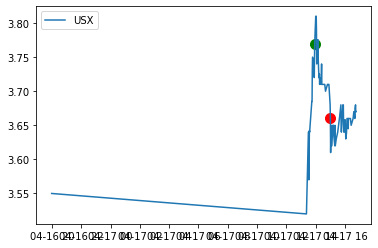

now=2020-04-17 10:59:58.156356
BHLB analysis for run 401 with profit -42.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4029.03,-4029.03,buy,2020-04-17 14:59:58.156356,15.09,"[13.54, 13.59, 13.79, 14.7, 14.7525]","[15.8, 15.8, 15.81]",267,"{'avg': 14.7524, 'rsi': 69.2452105382223, 'macd': [0.03463806759143573, 0.0468091889868969, 0.05262064661596888, 0.060562721435145406, 0.06609497126287422], 'vwap': 15.0764, 'sell_macd': [0.019535782402625657, 0.027526162493485273, 0.03131702798644653, 0.036461637098021527, 0.03999689566420983], 'slow macd': [0.09875208242205247, 0.09979523062460594, 0.09995560771040246, 0.10074297486097272, 0.10130625351511924], 'macd_signal': [0.02401622442903756, 0.02857481734060943, 0.03338398319568132, 0.03881973084357414, 0.04427477892743416], 'resistances': [15.8, 15.8, 15.81], 'sell_macd_signal': [0.01186098279550315, 0.014994018735099576, 0.01825862058536897, 0.02189922388789948, 0.02551875824316155]}",16.17,14.73
1,-42.72,3986.31,sell,2020-04-17 15:27:31.732476,14.93,None,None,267,"{'avg': 14.7771, 'rsi': 41.79512691309215, 'vwap': 14.94, 'reasons': 'below cost & macd negative', 'movement': -0.009940357852882727, 'sell_macd': [0.011448318313158623, 0.007758715766575719, 0.00634137981122862, 0.004115645562761117, -0.0013085063914051176], 'sell_macd_signal': [0.02484288043608213, 0.02142604750218085, 0.018409113963990403, 0.015550420283744546, 0.012178634948714613]}",16.17,14.73


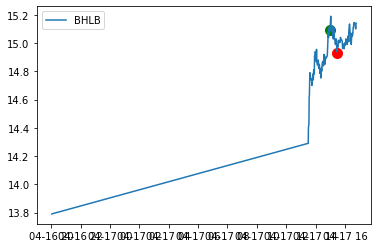

now=2020-04-17 10:00:05.518635
PLT analysis for run 401 with profit -58.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1660.4,-1660.4,buy,2020-04-17 14:00:05.518635,11.86,"[11.0, 11.05, 11.12, 11.21]","[12.63, 12.75]",140,"{'avg': 11.3469, 'rsi': 78.41219230405588, 'macd': [0.1707506143779831, 0.1742076238549739, 0.17931829938418353, 0.19125038648673431, 0.20400344177805962], 'vwap': 11.905, 'sell_macd': [0.1024156685496358, 0.10432436495212372, 0.10731394182481324, 0.11474330118243259, 0.1226786032639211], 'slow macd': [0.09982067094338021, 0.10435669763737465, 0.10924273147677077, 0.11556252073648388, 0.12231165508420716], 'macd_signal': [0.15459280142541165, 0.1585157659113241, 0.16267627260589598, 0.16839109538206365, 0.17551356466126283], 'resistances': [12.42], 'sell_macd_signal': [0.09332398943818891, 0.09552406454097587, 0.09788203999774334, 0.10125429223468119, 0.10553915444052916]}",14.04,11.2
1,-58.8,1601.6,sell,2020-04-17 14:31:59.758636,11.44,None,None,140,"{'avg': 11.4671, 'rsi': 35.32212889713434, 'vwap': 11.4742, 'reasons': 'below cost & macd negative', 'movement': -0.03946263643996647, 'sell_macd': [0.013534766280912436, 0.012855668498792383, 0.0119777264802714, 0.011138060927136095, -0.0010894454899457173], 'sell_macd_signal': [0.012801916021866398, 0.012812666517251594, 0.012645678509855556, 0.012344154993311663, 0.009657434896660187]}",14.04,11.2


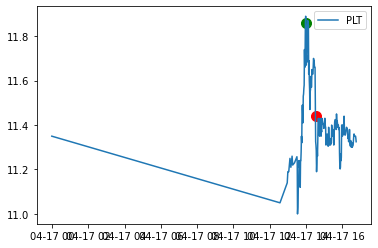

now=2020-04-17 09:52:37.815928
GCO analysis for run 401 with profit -86.14


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1975.32,-1975.32,buy,2020-04-17 13:52:37.815928,16.74,"[14.205, 14.27, 14.71, 15.3901]","[17.33, 17.41]",118,"{'avg': 15.9705, 'rsi': 73.40077350512391, 'macd': [0.4511942910142128, 0.4426100763195162, 0.44280637447814897, 0.45865468358274164, 0.4658446159742855], 'vwap': 16.74, 'sell_macd': [0.27240846664046003, 0.265650664016313, 0.26472704295832195, 0.27407581819939253, 0.2778011519171155], 'slow macd': [0.23787791211712062, 0.24694832841241166, 0.2572974825834695, 0.27056586075910616, 0.2823404608147264], 'macd_signal': [0.4468966458339756, 0.4460393319310837, 0.44539274044049676, 0.4480451290689457, 0.45160502645001366], 'resistances': [17.41], 'sell_macd_signal': [0.27546516989747893, 0.2735022687212457, 0.271747223568661, 0.2722129424948073, 0.27333058437926894]}",19.25,15.9
1,-86.14,1889.18,sell,2020-04-17 14:14:14.845135,16.01,None,None,118,"{'avg': 16.1811, 'rsi': 41.36584049231144, 'vwap': 16.06, 'reasons': 'below cost & macd negative', 'movement': -0.04062126642771803, 'sell_macd': [0.07957105383296437, 0.05618332843975793, 0.027878823867915514, 0.006240523891570149, -0.009402833543134648], 'sell_macd_signal': [0.16747262974833077, 0.1452147694866162, 0.12174758036287607, 0.09864616906861488, 0.07703636854626497]}",19.25,15.9


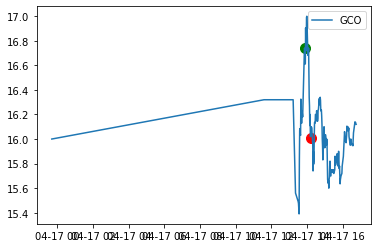

now=2020-04-17 09:55:11.797026
DVN analysis for run 401 with profit -26.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2831.4,-2831.4,buy,2020-04-17 13:55:11.797026,8.58,[8.3039],"[8.69, 8.7]",330,"{'avg': 8.3359, 'rsi': 66.59478922640342, 'macd': [0.0771752942056132, 0.07546666649392009, 0.07566114146061054, 0.07654671425262727, 0.07796365345716794], 'vwap': 8.5791, 'sell_macd': [0.047757580256723386, 0.04639186549168528, 0.04628362196709013, 0.046637151402897814, 0.04734591263335908], 'slow macd': [0.03146214388362978, 0.03313841093304504, 0.035107438056984464, 0.037182728604747695, 0.039352465764277866], 'macd_signal': [0.06505458600563697, 0.0671370021032936, 0.06884182997475699, 0.07038280683033105, 0.07189897615569843], 'resistances': [8.69, 8.7], 'sell_macd_signal': [0.040797745834229626, 0.04191656976572076, 0.04278998020599463, 0.04355941444537527, 0.04431671408297203]}",9.48,8.28
1,-26.4,2805.0,sell,2020-04-17 14:17:07.730011,8.50,None,None,330,"{'avg': 8.4447, 'rsi': 41.572997146641704, 'vwap': 8.52, 'reasons': 'below cost & macd negative', 'movement': -0.006993006993007051, 'sell_macd': [0.021412739351124088, 0.015318159818162869, 0.008811758106528345, 0.0036273962778974322, -0.0004594752285402848], 'sell_macd_signal': [0.035702736641348265, 0.03162582127671119, 0.027063008642674618, 0.02237588616971918, 0.017808813890067287]}",9.48,8.28


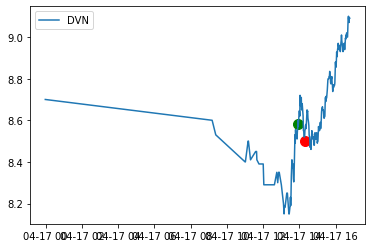

now=2020-04-17 09:48:25.787524
ERX analysis for run 400 with profit -2749.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2749.4,-2749.4,buy,2020-04-17 13:48:25.787524,11.65,"[10.8, 11.27]","[11.88, 11.88, 11.88, 11.89, 11.9, 11.9, 11.9]",236,"{'avg': 11.2732, 'rsi': 76.55451618180203, 'macd': [0.17455852228899715, 0.1794587718887417, 0.1881691238898089, 0.1924422586611314, 0.20078454648867883], 'vwap': 11.65, 'sell_macd': [0.10702405381204372, 0.10967160920391628, 0.11481422887026049, 0.11706543602753783, 0.12197981256531776], 'slow macd': [0.0849354788641783, 0.09017284090491451, 0.09623380799492587, 0.10157461169030135, 0.10776689112104876], 'macd_signal': [0.16317153989147362, 0.16642898629092723, 0.17077701381070357, 0.17511006278078914, 0.18024495952236708], 'resistances': [11.88, 11.89, 11.9, 11.9, 11.9], 'sell_macd_signal': [0.10193356762542605, 0.10348117594112409, 0.10574778652695137, 0.10801131642706865, 0.11080501565471848]}",12.91,11.23


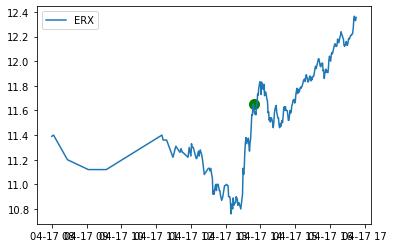

now=2020-04-17 09:48:21.836084
CNQ analysis for run 400 with profit -1912.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1912.16,-1912.16,buy,2020-04-17 13:48:21.836084,12.58,[11.99],[12.9],152,"{'avg': 12.2678, 'rsi': 66.04766646590396, 'macd': [0.054407612673310624, 0.06201309879051564, 0.06886055259982982, 0.07742923518433642, 0.10001234279117988], 'vwap': 12.5712, 'sell_macd': [0.03591275079152645, 0.04056219515053172, 0.04469731809065891, 0.04993640975711244, 0.06427938495490615], 'slow macd': [-0.00404655543383825, -0.0005112831134379547, 0.0030619702818821537, 0.007144260638341393, 0.014247328638205659], 'macd_signal': [0.03103719439971908, 0.03723237527787839, 0.04355801074226868, 0.05033225563068223, 0.060268273062781756], 'resistances': [12.9], 'sell_macd_signal': [0.02147028700151763, 0.025288668631320448, 0.02917039852318814, 0.033323600769973, 0.039514757606959626]}",14.53,11.93


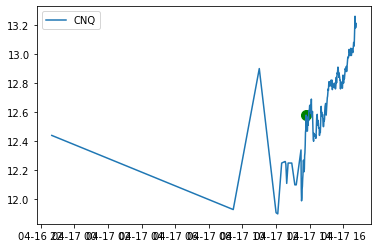

now=2020-04-17 09:48:26.259396
VET analysis for run 400 with profit -1100.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1100.8,-1100.8,buy,2020-04-17 13:48:26.259396,3.44,"[3.17, 3.31]","[3.5, 3.5, 3.5, 3.6, 3.6]",320,"{'avg': 3.2888, 'rsi': 65.33254612381052, 'macd': [0.020780876417693328, 0.02380733626566167, 0.028699208382837682, 0.03300253601443881, 0.038790014517665394], 'vwap': 3.44, 'sell_macd': [0.014218742563167464, 0.01604335489629216, 0.01907495730007369, 0.021708998688733327, 0.02529774524238082], 'slow macd': [-0.006229654134916274, -0.004760147337790954, -0.002840764798991202, -0.0009103920357071971, 0.0014268447881469193], 'macd_signal': [0.008946082397974411, 0.011918333171511863, 0.015274508213777026, 0.018820113773909384, 0.022814093922660587], 'resistances': [3.5, 3.5, 3.5, 3.6, 3.6], 'sell_macd_signal': [0.006880136561947889, 0.008712780228816743, 0.010785215643068133, 0.012969972252201171, 0.015435526850237101]}",4.37,3.13


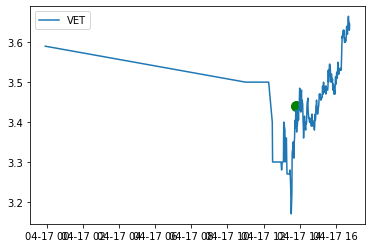

In [85]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d").date()
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
for run_id, count in runs.items():
    for symbol in minute_history:
        if symbol not in trade_details[run_id]:
            print(symobl)
            continue
           
        print (f'{symbol} analysis for run {run_id}')
        plt.plot(minute_history[symbol]['close'], label=symbol)

        for trade in trade_details[run_id][symbol]:
            print(f'operation {trade[0]} price {trade[2]} qty {trade[3]}')

            plt.scatter(parser.isoparse(trade[1]), trade[2], c='g' if trade[0] == 'buy' else 'r', s=100)
    
        plt.legend()
        plt.show()

        min_time = trade_details[run_id][symbol][0][0]
        max_time = trade_details[run_id][symbol][-1][2]
        delta = 0 
        accumulative_delta = []
        
  #      if min_time not in minute_history[symbol]['close'] or max_time not in minute_history[symbol]['close']:
  #          continue
        plt.plot(minute_history[symbol]['close'][min_time:max_time], label=symbol)
                

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
 #           t = parser.isoparse(trade[0])
 #           t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
 #           if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
 #               continue 

                
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            trade_delta = trade[3] - trade[1]
            delta += trade_delta 
            accumulative_delta.append(delta)
            
        plt.legend()
        plt.show()

        print(f'Delta = {delta}')
        plt.plot(range(len(accumulative_delta)), accumulative_delta)
        plt.show()

        for trade in trade_details[run_id][symbol]:
 #           if trade[1] < high_15m[symbol]:
 #               continue
#            t = parser.isoparse(trade[0])
#            t = t - timedelta(seconds=t.second, microseconds=t.microsecond)
#            if trade[1] < minute_history[symbol]['open'][pd.Timestamp(t)]:
#                continue

                
            plt.plot(minute_history[symbol]['close'][trade[0]:trade[2]])
            plt.scatter(parser.isoparse(trade[0]), trade[1], c='g', s=100)
            plt.scatter(parser.isoparse(trade[2]), trade[3], c='r', s=100)
            plt.show()
            print(f"buy time:{trade[0]} sell time:{trade[2]}")
            print(trade[4])
            print(trade[5])



In [60]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

Timestamp('2020-04-16 13:44:06.066000')

In [61]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

2416

In [62]:
minute_history['NURO'][:index]

,open,high,low,close,volume
timestamp,,,,,
2020-04-06 07:18:00-04:00,1.040,1.040,1.030,1.030,2689.0
2020-04-06 07:31:00-04:00,1.010,1.010,1.010,1.010,200.0
2020-04-06 07:49:00-04:00,1.030,1.030,1.030,1.030,300.0
2020-04-06 09:28:00-04:00,1.060,1.060,1.060,1.060,106.0
2020-04-06 09:30:00-04:00,1.000,1.090,1.000,1.090,9920.0
...,...,...,...,...,...
2020-04-06 12:39:00-04:00,0.990,0.990,0.990,0.990,100.0
2020-04-06 12:40:00-04:00,0.993,0.993,0.993,0.993,1000.0
2020-04-06 12:42:00-04:00,1.000,1.000,0.980,0.980,10461.0


In [68]:
series = minute_history['NURO'][:2417]['close']

In [70]:
MACD(series.dropna().between_time("9:30", "16:00"))

(timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04-06 09:32:00-04:00         NaN
 2020-04-06 09:35:00-04:00         NaN
 2020-04-06 09:38:00-04:00         NaN
 2020-04-06 09:39:00-04:00         NaN
                                ...   
 2020-04-16 13:40:00-04:00    0.190075
 2020-04-16 13:41:00-04:00    0.194543
 2020-04-16 13:42:00-04:00    0.189046
 2020-04-16 13:43:00-04:00    0.188320
 2020-04-16 13:44:00-04:00    0.179718
 Length: 1883, dtype: float64,
 timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04-06 09:32:00-04:00         NaN
 2020-04-06 09:35:00-04:00         NaN
 2020-04-06 09:38:00-04:00         NaN
 2020-04-06 09:39:00-04:00         NaN
                                ...   
 2020-04-16 13:40:00-04:00    0.111862
 2020-04-16 13:41:00-04:00    0.128398
 2020-04-16 13:42:00-04:00    0.140528
 2020-04-16 13:43:00-04:00    0.150086
 2020-04-16 13:44:00-04:00    0.156013
 Length: 1883, dtype: float64,
 timestamp
 2020-04-06 09:30:00-04:00         NaN
 2020-04